# Evacuation Route Finding Artefact

In [1]:
"""Import the necessary modules at the beginning of the notebook."""
import sys        # this module is used to create a maximum value (instead of infinity)
import heapq      # This module is used for both Dijkstra and A* to work with the priority queue
import timeit     # This module is used to measure the runtimes of the different implementations
import statistics # This module is used to measure the average runtime after multiple run throughs of computations
import math       # This module is used to use the squareroot for finding the standard error

# Floorplan Graphical Representations
## First Floor

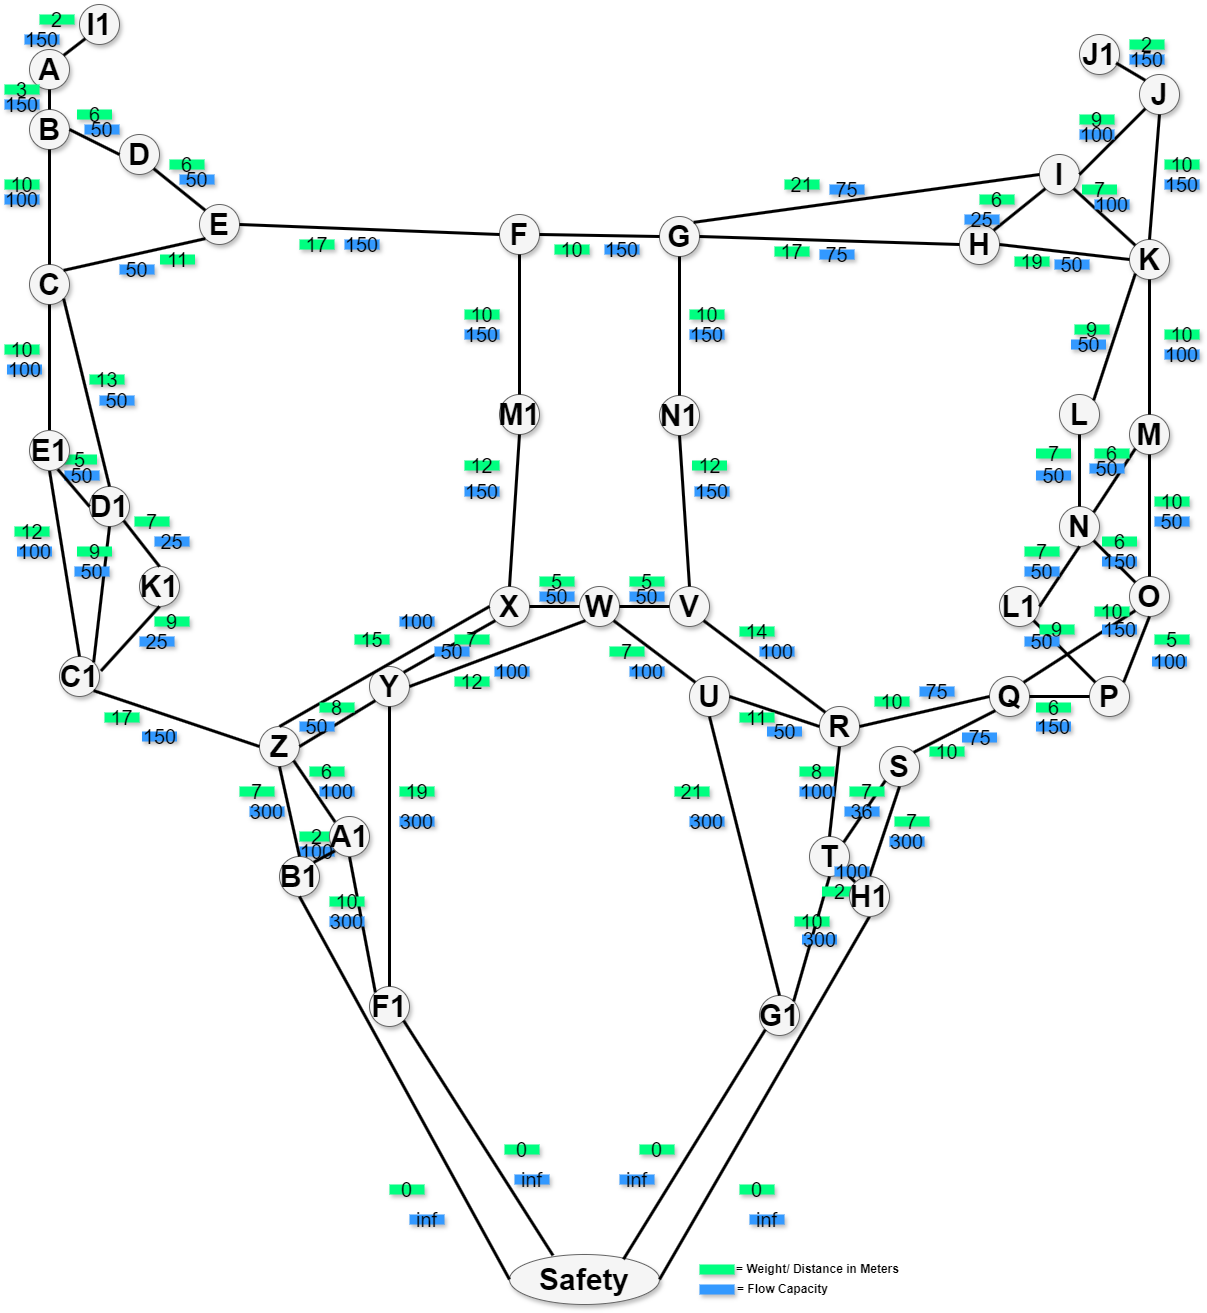

## Ground Floor

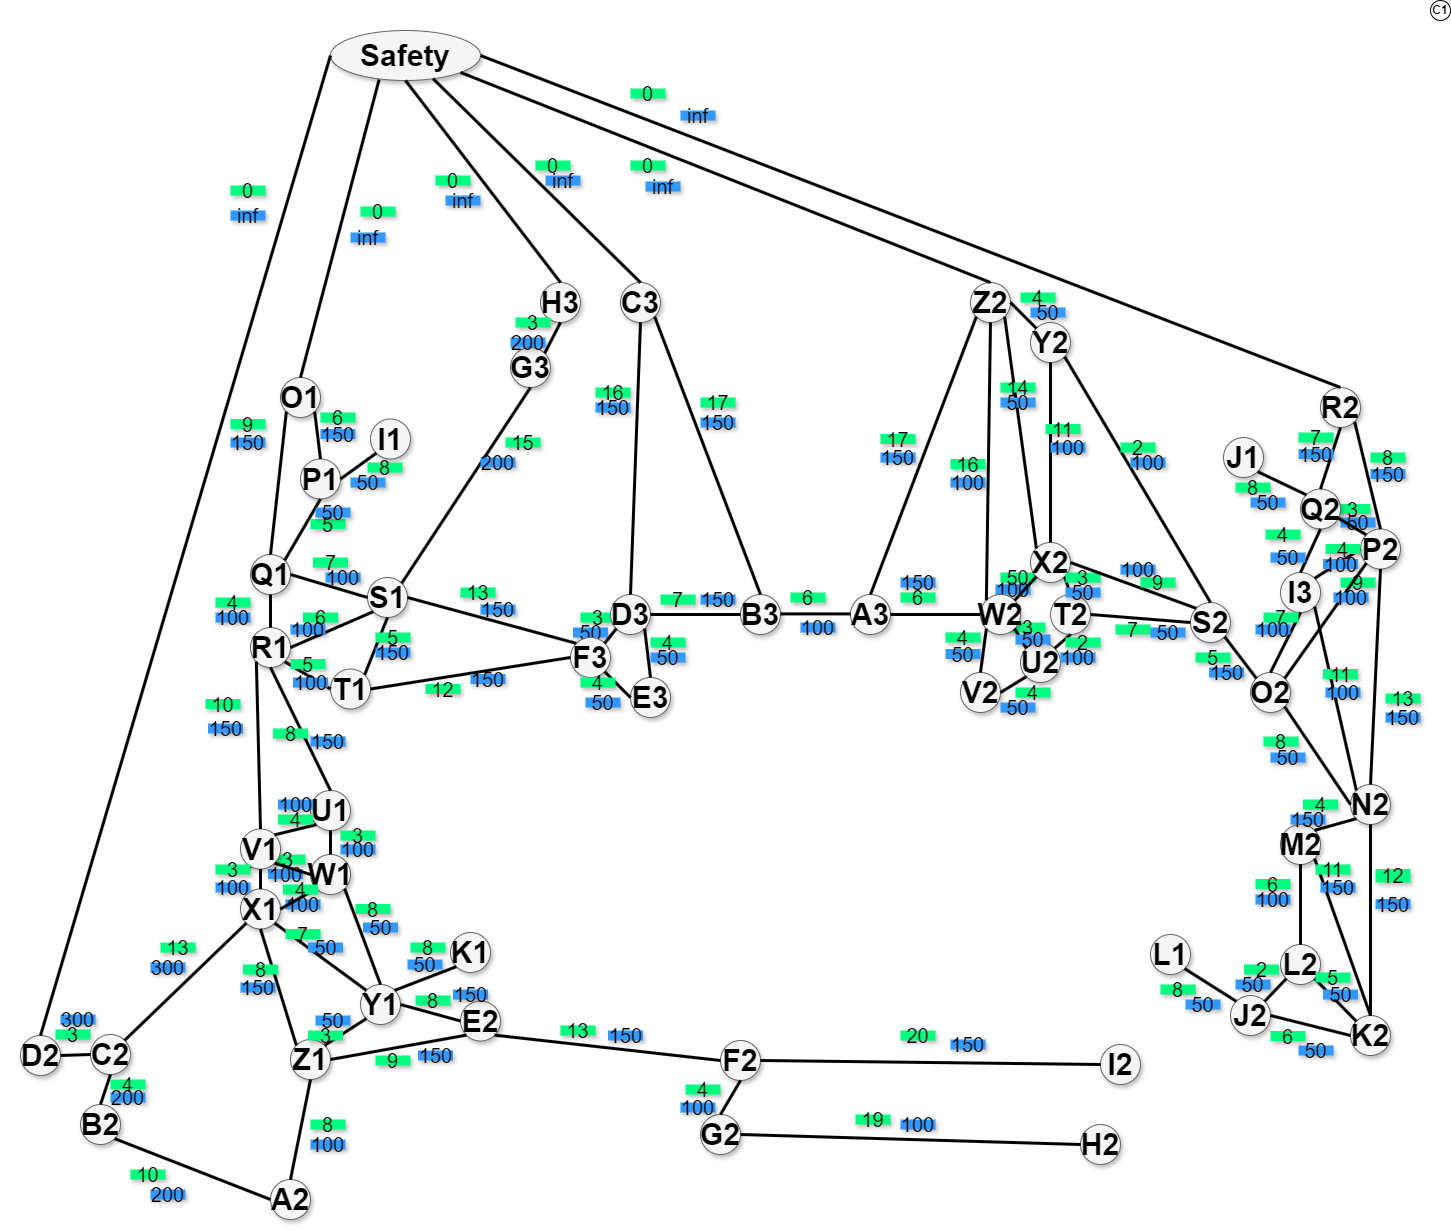

## Second Floor

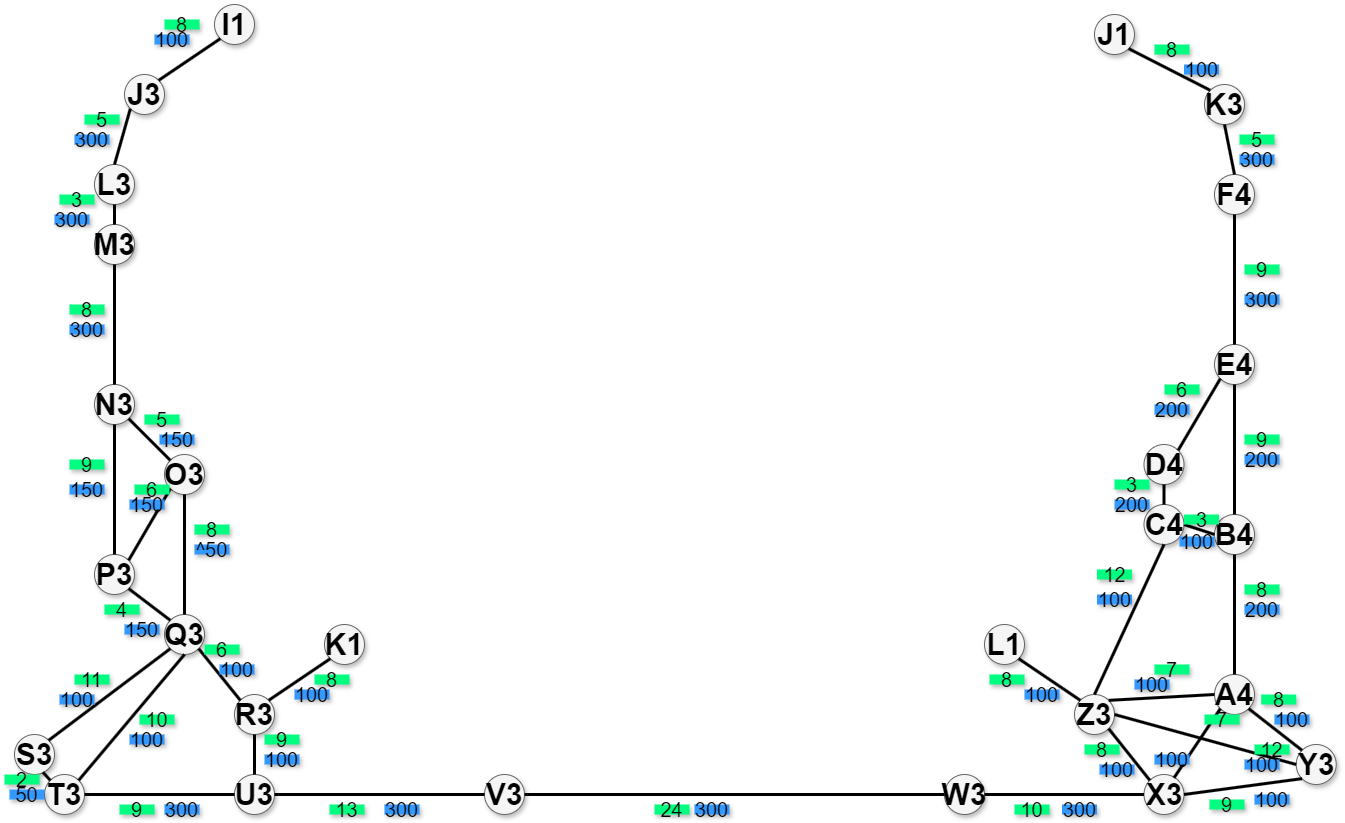

# Local Solution with Dijkstra and A*

In [2]:
"""
A Vertex class is defined in order to 
return the name of the vertices/ points in the graph
that contribute to the computation
of the different paths.
(The uses of repr, eq and the hash function are based on the sources: 
https://www.educative.io/answers/what-is-the-repr-method-in-python (Last accessed: 20.08.2024) ,
https://stackoverflow.com/questions/1227121/compare-object-instances-for-equality-by-their-attributes (Last accessed: 20.08.2024))
"""

class Vertex:                     
    def __init__(self, name):       
        self.name = name

    def __eq__(self, V):
        return self.name == V.name

    def __repr__(self):
        return self.name

    def __hash__(self):             # hash method facilitates using instances of this class
        return hash(self.name)      # in collections such as dictionaries or sets 
    
"""
The edge class defines the necessary instances implemented per egde
for the combination of Ford Fulkerson with Dijkstra and A*.
It consists of the two vertices creating the edge (connection),
the weight of the edge which reflects the distances between the two points in the graph,
the capacity which depicts the amount of flow allowed to pass through the edge and
a status variable (for A*) that informs the application,
whether an edge is safe to use in the path computation.
Depending on the status, the weight instance is recalculated before being used, 
so a real weight variable is introduced to not loop over re-caclucations.
"""
    
class Edge:                       
    def __init__(self, v1, v2, w=1, capacity=sys.maxsize, status="safe"): 
        # default of weight is 1 meter, default of capacity is a maximum value that will not be reached and the default status of the edges is safe
        self.v1 = v1                
        self.v2 = v2               
        self.weight = w             
        self.capacity = capacity    
        self.status = status        
        self.real_weight = w      

    def __eq__(self, E):            # checks for equality between instances of the class, allowing to compare edges
        t1 = (self.v1 == E.v1) and (self.v2 == E.v2) and (self.weight == E.weight) and (self.capacity == E.capacity) and (self.status == E.status)
        return t1              

    def __repr__(self):
        return f"({self.v1},{self.v2},{self.weight},{self.capacity},{self.status})"
    
"""
The Graph class defines the necessary instances to create the graphical representations 
of the floorplans. The graph variable refers to a matrix created with the vertices.
The vertices will be the list of the points in the graph, those being instances of the Vertex class.
A list containing the edges and their respectives information will be created, 
those defining the edges instance. A key-value pair for each Vertex in the vertices list and their respective
value for capacity will be stored as a dictionary. The same will be done for the weights.
"""

class Graph:                                      
    def __init__(self, graph, vertices, edges):  
        self.vertices = vertices                  
        self.edges = edges                        
        self.capacity = {v: {} for v in vertices} 
        self.weights = {v: {} for v in vertices} 

        for edge in edges:                                    # iterate over edges to initialize the capacity and weight matrices
            self.capacity[edge.v1][edge.v2] = edge.capacity   # use the capacity values of the edges
            self.weights[edge.v1][edge.v2] = edge.real_weight # and the real weight values between the vertices

def heuristic(e):   
    """ 
    This function allows A* to consider the status and create paths based on whether an edge is safe or not.
    When an edge is blocked, the algorithm should recognize the risk and should not consider sending people through it.
    To ensure this, the new weight considered in the computation of the paths is made excessively high.
    As long as the path is safe, or becomes safe after being unsafe, 
    the original weight is considered in the path computation.
    """ 
    if e.status == "blocked":     
        return e.real_weight*100  
    if e.status == "safe":        
        return e.real_weight      
    else:                         
        return e.real_weight
        
def find_closest_unvisited(vertices, distances, visited):
    """
    This function loops over the vertices and checks the distances between the 
    current point and its neighbours to find the closest one that has not been visited.
    """
    d = max(distances) + 1                    # define the highest distance plus one as a maximum as no greater distance can be achieved
    next_V = None                             # define a next vertex variable (default None)
    for idx in range(len(vertices)):          
        if distances[idx] < d:                # if the distance of a vertex is smaller than the max distance
            if vertices[idx] not in visited:  # as long as that vertex is not visited
                next_V = vertices[idx]        # have is be the next vertex to visit
                d = distances[idx]            # store the distance
    return next_V                             # that vertex is then the closest unvisited vertex, this is repeated until every vertex in the list has been visited


def Astar(G, s):
    """
    The A* function will be the same as Dijkstra's implementation with the difference
    of using the heuristic function.
    Both methods have a variable defined as inf which is simply the sum of all the weights/ distances plus 1,
    in order to set a maximum value that cannot be surpassed, as no path can be longer than the sum of all weights,
    so adding 1 makes it higher than the maximum.
    An empty list for the visited vertices is initialized and a variable depicting the next closest 
    unvisited vertex of the current one is found with the previous function. As long as that instance 
    belongs to the Vertex class, that neighbour will be added to the visited list. That vertex is defined as the
    variable idx_1 and its neighbours are checked by looping over the edges. In this implementation when starting
    the loop, the heuristic function is run on the weights to integrate the edge status.
    The vertices included in the edges that have the neighbours of the visited vertex are checked.
    If the neighbour is not yet visited, then that vertex is stored in the variable idx_2.
    A new distance is computed by adding the weight of the edge to the distance of idx_1.
    The same is done for the case of v not being a starting but an end point.
    Then the next closest unvisited vertex is identified and the process repeats.
    (The implementations of both A* and Dijkstra in this solution are based on a code snipped from a lab)
    """
    inf = 1
    for e in G.edges:
        inf += e.weight

    dist = [inf] * len(G.vertices)  # define distances inf
    dist[G.vertices.index(s)] = 0   # but as 0 for starting point 

    prev = [None] * len(G.vertices) # all prev defined as None

    visited = []                    # no vertices visited yet
    v = find_closest_unvisited(G.vertices, dist, visited)

    while isinstance(v, Vertex):
        visited.append(v)           # visit the vertex and store it

        idx_1 = G.vertices.index(v)

        for e in G.edges:           # loop to check all neighbors
            e.weight = heuristic(e) # integrate heuristic function to use a recomputed weight if applicable
            if e.v1 == v:
                if e.v2 not in visited:        # if the neighbour is not visited
                    idx_2 = G.vertices.index(e.v2)
                    d = dist[idx_1] + e.weight # compute the new distance
                    if d < dist[idx_2]:        # check and update if there is a shorter path
                        dist[idx_2] = d
                        prev[idx_2] = v
            elif e.v2 == v:                    # same done, treating v as end point
                if e.v1 not in visited:
                    idx_2 = G.vertices.index(e.v1)
                    d = dist[idx_1] + e.weight
                    if d < dist[idx_2]:
                        dist[idx_2] = d
                        prev[idx_2] = v

        v = find_closest_unvisited(G.vertices, dist, visited) # find the next unvisited closest neighbor

    return dist, prev

def Dijkstra(G, s):
    """
    The original Dijkstra implementation is identical to A* with the difference that the 
    heuristic function is not used. This means that the weight simply consists of the 
    previously measured distances between the vertices in the graph. The statuses 
    are not considered.
    """
    inf = 1
    for e in G.edges:
        inf += e.weight

    dist = [inf] * len(G.vertices)
    dist[G.vertices.index(s)] = 0

    prev = [None] * len(G.vertices)

    visited = []
    v = find_closest_unvisited(G.vertices, dist, visited)

    while isinstance(v, Vertex):
        visited.append(v)

        idx_1 = G.vertices.index(v)

        for e in G.edges: 
            # heuristic method here not integrated, that is the only difference to previously
            if e.v1 == v:
                if e.v2 not in visited:
                    idx_2 = G.vertices.index(e.v2)
                    d = dist[idx_1] + e.weight
                    if d < dist[idx_2]:
                        dist[idx_2] = d
                        prev[idx_2] = v
            elif e.v2 == v:
                if e.v1 not in visited:
                    idx_2 = G.vertices.index(e.v1)
                    d = dist[idx_1] + e.weight
                    if d < dist[idx_2]:
                        dist[idx_2] = d
                        prev[idx_2] = v

        v = find_closest_unvisited(G.vertices, dist, visited)

    return dist, prev

"""
Both Dijkstra and A* are used to find the shortest path from the source to the sink in the graph.
Those paths and the resulting distances (and risk from the statuses) are used to find the local solution
with the possible flow through the individual paths. To find the flows, Ford Fulkerson is used.
"""

def FordFulkerson(source, sink, graph, aug_method):
    """
    This implementation takes the source (the starting point), the sink (the end point),
    the graphical representation and the augmenting path finding method as input.
    The initial maximum flow is set to 0 and the augmenting path finding method is used to 
    initialize the dist and prev variables, which are the returned outputs of either Dijkstra or A*.
    The path variable is given by a path computation function (it will be explained at its respective place).
    The function returns the reconstructed path found with the outputs of either Dijkstra or A*.
    The flow of the path is initially defined as infinity and then by looping over the instances
    in the path, the minimum flow (bottleneck capacity) is identified and gets stored as the path flow
    variable. Once the path flow that remains on the path is 0, the computation stops,
    as there is no more capacity left on the path. The path flow is added to the previously
    defined maximum flow and makes up its value for that specific path. As this solution treats the paths
    one by one, ultimately, the path flow is identical to the max flow as no further flows are added to 
    the max flow, having no further augmenting paths (or alternatives) considered.
    The residual capacities on the path are updated in order to ensure that an edge in further computation
    is not overloaded. As this solution treats the paths one by one and offers experimental testing possibilities,
    this step is not necessary as the graph gets re-created after each run through, but it is the necessary practice
    in the Ford Fulkerson implementations.
    (The Ford Fulkerson implementations throughout the artefact are slight variations, depending on the path finding methods, of 
     the snippets in the sources
     https://www.w3schools.com/dsa/dsa_algo_graphs_fordfulkerson.php (Last accessed: 20.08.2024)
     https://www.geeksforgeeks.org/ford-fulkerson-algorithm-for-maximum-flow-problem/ (Last accessed: 20.08.2024)
     https://github.com/Mushahid2521/Data-Structures-and-Algorithms-in-Python/blob/master/graph/Maximul_flow_Ford_Fulkerson.py (Last accessed: 20.08.2024))
    """
    max_flow = 0
    while True:
        dist, prev = aug_method(graph, source)
        path = path_computation(source, sink, graph, aug_method)

        if not path or path[-1] != sink:
            break  

        path_flow = float('Inf')
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            path_flow = min(path_flow, graph.capacity[u][v])

        if path_flow == 0:
            break 

        max_flow += path_flow

        
        for i in range(len(path) - 1):         # Update residual capacities
            u = path[i]
            v = path[i + 1]
            graph.capacity[u][v] -= path_flow  # the capacity from the direction that was followed will decrease by the value of the path flow
            graph.capacity[v][u] = graph.capacity.get(v, {}).get(u, 0) + path_flow # the reverse capacity will increase

    return max_flow

def path_computation(A, B, G, aug_method):
    """
    This is the function that returns the vertices that have been identified by either 
    Dijkstra or A* in a list containing the computed graph with those vertices.
    It constructs the path backwards, by considering the sink first and its predecessor.
    P depicts the path variable and the sink is the first instance contained in the list. Its predecessor
    is added and then the predecessor's predecessor is added, until the starting point, the source,
    is reached. Once the backwards path is constructed, the list gets reversed, to start from 
    the source and finish at the sink. This path then gets returned by the function.
    """
    dist, prev = aug_method(G, A)
    idx_A = G.vertices.index(A)
    idx_B = G.vertices.index(B)
    if isinstance(prev[idx_B], Vertex):
        p = [B]
        backtracked = False
        while not backtracked:
            p.append(prev[G.vertices.index(p[-1])])
            backtracked = p[-1] == A
        p.reverse()
        
        return p
    

def path_distance(A, B, G, aug_method):
    """
    This function has been defined to calculate the total distance found by the original
    weight values stored in the edges. It then also computes the distance as more of a risk or
    potential cost considering the weights and the applied heuristic function, in order to show
    and compare how the different methods integrate the given information in their calculations 
    and path finding decisions.
    """
    p = path_computation(A, B, G, aug_method)     # the path is computed with the previous function
    total_distance = 0                            # both distances initialized at 0
    potential_distance = 0
    for i in range(len(p) - 1):                   # loop over the vertices in the path
        u = p[i]
        v = p[i + 1]
        total_distance += G.weights[u][v]         # add the original weights to the total distance variable
        for e in G.edges:                   
            if (e.v1 == u and e.v2 == v) or (e.v1 == v and e.v2 == u):
                edge = e                          # check if the edge exists
                break
        if edge:
            potential_distance += heuristic(edge) # compute the potential distance with the influence of the statuses
    return total_distance, potential_distance


"""
To create the graphical representations, all the vertices that exist in the floorplan
are defined and stored in a vertices list.
"""
A = Vertex("A")
B = Vertex("B")
C = Vertex("C")
D = Vertex("D")
E = Vertex("E")
F = Vertex("F")
G = Vertex("G")
H = Vertex("H")
I = Vertex("I")
J = Vertex("J")
K = Vertex("K")
L = Vertex("L")
M = Vertex("M")
N = Vertex("N")
O = Vertex("O")
P = Vertex("P")
Q = Vertex("Q")
R = Vertex("R")
S = Vertex("S")
T = Vertex("T")
U = Vertex("U")
V = Vertex("V")
W = Vertex("W")
X = Vertex("X")
Y = Vertex("Y")
Z = Vertex("Z")
A1 = Vertex("A1")
B1 = Vertex("B1")
C1 = Vertex("C1")
D1 = Vertex("D1")
E1 = Vertex("E1")
F1 = Vertex("F1")
G1 = Vertex("G1")
H1 = Vertex("H1")
I1 = Vertex("I1")
J1 = Vertex("J1")
K1 = Vertex("K1")
L1 = Vertex("L1")
M1 = Vertex("M1")
N1 = Vertex("N1")
Safety = Vertex("Safety")
O1 = Vertex("O1")
P1 = Vertex("P1")
Q1 = Vertex("Q1")
R1 = Vertex("R1")
S1 = Vertex("S1")
T1 = Vertex("T1")
U1 = Vertex("U1")
V1 = Vertex("V1")
W1 = Vertex("W1")
X1 = Vertex("X1")
Y1 = Vertex("Y1")
Z1 = Vertex("Z1")
A2 = Vertex("A2")
B2 = Vertex("B2")
C2 = Vertex("C2")
D2 = Vertex("D2")
E2 = Vertex("E2")
F2 = Vertex("F2")
G2 = Vertex("G2")
H2 = Vertex("H2")
I2 = Vertex("I2")
J2 = Vertex("J2")
K2 = Vertex("K2")
L2 = Vertex("L2")
M2 = Vertex("M2")
N2 = Vertex("N2")
O2 = Vertex("O2")
P2 = Vertex("P2")
Q2 = Vertex("Q2")
R2 = Vertex("R2")
S2 = Vertex("S2")
T2 = Vertex("T2")
U2 = Vertex("U2")
V2 = Vertex("V2")
W2 = Vertex("W2")
X2 = Vertex("X2")
Y2 = Vertex("Y2")
Z2 = Vertex("Z2")
A3 = Vertex("A3")
B3 = Vertex("B3")
C3 = Vertex("C3")
D3 = Vertex("D3")
E3 = Vertex("E3")
F3 = Vertex("F3")
G3 = Vertex("G3")
H3 = Vertex("H3")
I3 = Vertex("I3")
J3 = Vertex("J3")
L3 = Vertex("L3")
M3 = Vertex("M3")
N3 = Vertex("N3")
O3 = Vertex("O3")
P3 = Vertex("P3")
Q3 = Vertex("Q3")
R3 = Vertex("R3")
S3 = Vertex("S3")
T3 = Vertex("T3")
U3 = Vertex("U3")
V3 = Vertex("V3")
W3 = Vertex("W3")
X3 = Vertex("X3")
Y3 = Vertex("Y3")
Z3 = Vertex("Z3")
A4 = Vertex("A4")
B4 = Vertex("B4")
C4 = Vertex("C4")
D4 = Vertex("D4")
E4 = Vertex("E4")
F4 = Vertex("F4")
K3 = Vertex("K3")

vertices = [A, B, C, D, E, F, G, 
            H, I, J, K, L, M, N, 
            O, P, Q, R, S, T, U, 
            V, W, X, Y, Z, A1, B1, 
            C1, D1, E1, F1, G1, H1, I1, 
            J1, K1, L1, M1, N1, Safety, O1, 
            P1, Q1, R1, S1, T1, U1, V1, 
            W1, X1, Y1, Z1, A2, B2, C2, 
            D2, E2, F2, G2, H2, I2, J2, 
            K2, L2, M2, N2, O2, P2, Q2, 
            R2, S2, T2, U2, V2, W2, X2,
            Y2, Z2, A3, B3, C3, D3, E3, 
            F3, G3, H3, I3, J3, L3, M3, 
            N3, O3, P3, Q3, R3, S3, T3, 
            U3, V3, W3, X3, Y3, Z3, A4, 
            B4, C4, D4, E4, F4, K3
]

"""
An edge list is created storing all the edges that are connecting 2 vertices, with the respective
weights, capacities and statuses (the default status is "safe"). The reverse edge is also computed
to ensure that the graph is undirected. As there are various exits in the floorplan, the common safety 
vertex defined above is connected to all exit points with a weight of 0 and a maximum capacity.
"""
edges = [
    Edge(A, B, 3, 150), Edge(B, A, 3, 150), Edge(B, C, 10, 100), Edge(C, B, 10, 100), 
    Edge(B, D, 6, 50), Edge(D, B, 6, 50), Edge(C, E, 11, 50), Edge(E, C, 11, 50), 
    Edge(D, E, 6, 50), Edge(E, D, 6, 50), Edge(E, F, 17, 150), Edge(F, E, 17, 150), 
    Edge(F, G, 10, 150), Edge(G, F, 10, 150), Edge(G, H, 17, 75), Edge(H, G, 17, 75), 
    Edge(G, I, 21, 75), Edge(I, G, 21, 75), Edge(H, I, 6, 25), Edge(I, H, 6, 25),
    Edge(H, K, 10, 50), Edge(K, H, 10, 50), Edge(I, J, 9, 100), Edge(J, I, 9, 100), 
    Edge(I, K, 7, 100), Edge(K, I, 7, 100), Edge(J, K, 10, 150), Edge(K, J, 10, 150),
    Edge(K, L, 9, 50), Edge(L, K, 9, 50), Edge(K, M, 10, 100), Edge(M, K, 10, 100), 
    Edge(L, N, 7, 50), Edge(N, L, 7, 50), Edge(M, N, 6, 50), Edge(N, M, 6, 50), 
    Edge(M, O, 10, 50), Edge(O, M, 10, 50), Edge(N, O, 6, 150), Edge(O, N, 6, 150), 
    Edge(N, P, 9, 50), Edge(P, N, 9, 50), Edge(O, P, 5, 100), Edge(P, O, 5, 100), 
    Edge(O, Q, 10, 150), Edge(Q, O, 10, 150), Edge(P, Q, 6, 150), Edge(Q, P, 6, 150),
    Edge(Q, R, 10, 75), Edge(R, Q, 10, 75), Edge(Q, S, 10, 75), Edge(S, Q, 10, 75), 
    Edge(S, T, 7, 36), Edge(T, S, 7, 36), Edge(S, H1, 7, 300), Edge(H1, S, 7, 300), 
    Edge(T, H1, 2, 100), Edge(H1, T, 2, 100), Edge(T, G1, 10, 300), Edge(G1, T, 10, 300), 
    Edge(R, T, 8, 100), Edge(T, R, 8, 100), Edge(R, H1, 9, 300), Edge(H1, R, 9, 300), 
    Edge(R, U, 11, 50), Edge(U, R, 11, 50), Edge(R, V, 14, 100), Edge(V, R, 14, 100),
    Edge(U, V, 3, 50), Edge(V, U, 3, 50), Edge(U, W, 7, 100), Edge(W, U, 7, 100), 
    Edge(V, W, 5, 50), Edge(W, V, 5, 50), Edge(W, X, 5, 50), Edge(X, W, 5, 50), 
    Edge(W, Y, 12, 100), Edge(Y, W, 12, 100), Edge(X, Y, 7, 50), Edge(Y, X, 7, 50), 
    Edge(X, Z, 15, 100), Edge(Z, X, 15, 100), Edge(Y, Z, 8, 50), Edge(Z, Y, 8, 50), 
    Edge(Z, A1, 6, 100), Edge(A1, Z, 6, 100), Edge(Z, B1, 7, 300), Edge(B1, Z, 7, 300),
    Edge(A1, B1, 2, 100), Edge(B1, A1, 2, 100), Edge(A1, F1, 10, 300), Edge(F1, A1, 10, 300), 
    Edge(Z, C1, 17, 150), Edge(C1, Z, 17, 150), Edge(C1, D1, 9, 50), Edge(D1, C1, 9, 50), 
    Edge(C1, E1, 12, 100), Edge(E1, C1, 12, 100), Edge(E1, D1, 4, 50), Edge(D1, E1, 4, 50), 
    Edge(E1, C, 10, 100), Edge(C, E1, 10, 100), Edge(D1, C, 13, 50), Edge(C, D1, 13, 50), 
    Edge(A, I1, 2, 150), Edge(I1, A, 2, 150), Edge(F, M1, 10, 150, "blocked"), Edge(M1, F, 10, 150, "blocked"), 
    Edge(M1, X, 12, 150), Edge(X, M1, 12, 150), Edge(G, N1, 10, 150, "blocked"), Edge(N1, G, 10, 150, "blocked"),
    Edge(N1, V, 12, 150), Edge(V, N1, 12, 150), Edge(J, J1, 2, 150), Edge(J1, J, 2, 150), 
    Edge(N, L1, 7, 50), Edge(L1, N, 7, 50), Edge(L1, P, 9, 50), Edge(P, L1, 9, 50), 
    Edge(U, G1, 21, 300), Edge(G1, U, 21, 300), Edge(Y, F1, 19, 300), Edge(F1, Y, 19, 300), 
    Edge(C1, K1, 9, 25), Edge(K1, C1, 9, 25), Edge(K1, D1, 7, 25), Edge(D1, K1, 7, 25),
    # the following is the floorplan of the ground floor of the school building 
    Edge(O1, P1, 6, 150), Edge(P1, O1, 6, 150), Edge(O1, Q1, 9, 150), Edge(Q1, O1, 9, 150), 
    Edge(P1, Q1, 5, 50), Edge(Q1, P1, 5, 50), Edge(Q1, S1, 7, 100), Edge(S1, Q1, 7, 100), 
    Edge(Q1, R1, 4, 100), Edge(R1, Q1, 4, 100), Edge(R1, S1, 6, 100), Edge(S1, R1, 6, 100), 
    Edge(R1, T1, 5, 100), Edge(T1, R1, 5, 100), Edge(R1, U1, 8, 150), Edge(U1, R1, 8, 150), 
    Edge(S1, F3, 13, 150), Edge(F3, S1, 13, 150), Edge(S1, G3, 15, 200), Edge(G3, S1, 15, 200),
    Edge(G3, H3, 3, 200), Edge(H3, G3, 3, 200), Edge(T1, S1, 5, 150), Edge(S1, T1, 5, 150), 
    Edge(T1, F3, 12, 150), Edge(F3, T1, 12, 150), Edge(F3, E3, 4, 50), Edge(E3, F3, 4, 50),
    Edge(F3, D3, 3, 50), Edge(D3, F3, 3, 50), Edge(E3, D3, 4, 50), Edge(D3, E3, 4, 50), 
    Edge(D3, C3, 16, 150), Edge(C3, D3, 16, 150), Edge(D3, B3, 7, 150), Edge(B3, D3, 7, 150), 
    Edge(B3, C3, 17, 150), Edge(C3, B3, 17, 150), Edge(B3, A3, 6, 100), Edge(A3, B3, 6, 100), 
    Edge(R1, V1, 10, 150), Edge(V1, R1, 10, 150), Edge(U1, V1, 4, 100), Edge(V1, U1, 4, 100), 
    Edge(U1, W1, 3, 100), Edge(W1, U1, 3, 100), Edge(V1, W1, 3, 100), Edge(W1, V1, 3, 100),
    Edge(V1, W1, 3, 100), Edge(W1, V1, 3, 100), Edge(V1, X1, 3, 100), Edge(X1, V1, 3, 100), 
    Edge(W1, X1, 4, 100), Edge(X1, W1, 4, 100), Edge(W1, Y1, 8, 50), Edge(Y1, W1, 8, 50), 
    Edge(X1, Y1, 7, 50), Edge(Y1, X1, 7, 50), Edge(X1, C2, 13, 300), Edge(C2, X1, 13, 300), 
    Edge(X1, Z1, 8, 150), Edge(Z1, X1, 8, 150), Edge(C2, D2, 3, 300), Edge(D2, C2, 3, 300), 
    Edge(C2, B2, 4, 200), Edge(B2, C2, 4, 200), Edge(B2, A2, 10, 200), Edge(A2, B2, 10, 200),
    Edge(A2, Z1, 8, 100), Edge(Z1, A2, 8, 100), Edge(Z1, Y1, 3, 50), Edge(Y1, Z1, 3, 50), 
    Edge(Y1, E2, 8, 150), Edge(E2, Y1, 8, 150), Edge(Z1, E2, 9, 150), Edge(E2, Z1, 9, 150), 
    Edge(E2, F2, 13, 150), Edge(F2, E2, 13, 150), Edge(F2, I2, 20, 150), Edge(I2, F2, 20, 150), 
    Edge(F2, G2, 4, 100), Edge(G2, F2, 4, 100), Edge(G2, H2, 19, 100), Edge(H2, G2, 19, 100), 
    Edge(A3, Z2, 17, 150), Edge(Z2, A3, 17, 150), Edge(Z2, W2, 16, 100), Edge(W2, Z2, 16, 100),
    Edge(A3, W2, 6, 150), Edge(W2, A3, 6, 150), Edge(Z2, Y2, 4, 50), Edge(Y2, Z2, 4, 50), 
    Edge(Z2, X2, 14, 50), Edge(X2, Z2, 14, 50), Edge(W2, X2, 4, 50), Edge(X2, W2, 4, 50), 
    Edge(X2, Y2, 11, 100), Edge(Y2, X2, 11, 100), Edge(W2, V2, 4, 50), Edge(V2, W2, 4, 50), 
    Edge(W2, U2, 3, 50), Edge(U2, W2, 3, 50), Edge(V2, U2, 4, 50), Edge(U2, V2, 4, 50), 
    Edge(U2, T2, 2, 100), Edge(T2, U2, 2, 100), Edge(T2, X2, 3, 50), Edge(X2, T2, 3, 50), 
    Edge(T2, S2, 7, 50), Edge(S2, T2, 7, 50), Edge(X2, S2, 9, 100), Edge(S2, X2, 9, 100),
    Edge(Y2, S2, 16, 200), Edge(S2, Y2, 16, 200), Edge(S2, O2, 5, 150), Edge(O2, S2, 5, 150), 
    Edge(O2, I3, 7, 100), Edge(I3, O2, 7, 100), Edge(O2, P2, 9, 100), Edge(P2, O2, 9, 100), 
    Edge(O2, N2, 8, 50), Edge(N2, O2, 8, 50), Edge(I3, Q2, 4, 50), Edge(Q2, I3, 4, 50), 
    Edge(P2, Q2, 3, 50), Edge(Q2, P2, 3, 50), Edge(I3, P2, 4, 100), Edge(P2, I3, 4, 100), 
    Edge(Q2, R2, 7, 150), Edge(R2, Q2, 7, 150), Edge(P2, R2, 8, 150), Edge(R2, P2, 8, 150), 
    Edge(I3, N2, 11, 100), Edge(N2, I3, 11, 100), Edge(P2, N2, 13, 150), Edge(N2, P2, 13, 150), 
    Edge(N2, M2, 4, 150), Edge(M2, N2, 4, 150), Edge(N2, K2, 12, 150), Edge(K2, N2, 12, 150), 
    Edge(M2, K2, 11, 100), Edge(K2, M2, 11, 100), Edge(M2, L2, 6, 100), Edge(L2, M2, 6, 100), 
    Edge(L2, K2, 5, 50), Edge(K2, L2, 5, 50), Edge(L2, J2, 2, 50), Edge(J2, L2, 2, 50), 
    Edge(K2, J2, 6, 50), Edge(J2, K2, 6, 50), Edge(Y1, K1, 8, 50), Edge(K1, Y1, 8, 50), 
    Edge(J2, L1, 8, 50), Edge(L1, J2, 8, 50), Edge(P1, I1, 8, 50), Edge(I1, P1, 8, 50), 
    Edge(Q2, J1, 8, 50), Edge(J1, Q2, 8, 50),
    # the following is the floorplan of the second floor of the school building 
    Edge(I1, J3, 8, 100), Edge(J3, I1, 8, 100), Edge(J3, L3, 5, 300), Edge(L3, J3, 5, 300), 
    Edge(L3, M3, 3, 300), Edge(M3, L3, 3, 300), Edge(M3, N3, 8, 300), Edge(N3, M3, 8, 300), 
    Edge(N3, O3, 5, 150), Edge(O3, N3, 5, 150), Edge(N3, P3, 9, 150), Edge(P3, N3, 9, 150), 
    Edge(O3, P3, 6, 150), Edge(P3, O3, 6, 150), Edge(P3, Q3, 4, 150), Edge(Q3, P3, 4, 150), 
    Edge(Q3, R3, 6, 100), Edge(R3, Q3, 6, 100), Edge(Q3, S3, 11, 100), Edge(S3, Q3, 11, 100), 
    Edge(Q3, T3, 10, 100), Edge(T3, Q3, 10, 100), Edge(R3, K1, 8, 100), Edge(K1, R3, 8, 100), 
    Edge(S3, T3, 2, 50), Edge(T3, S3, 2, 50), Edge(T3, U3, 9, 300), Edge(U3, T3, 9, 300), 
    Edge(U3, R3, 9, 100), Edge(R3, U3, 9, 100), Edge(U3, V3, 13, 300), Edge(V3, U3, 13, 300), 
    Edge(V3, W3, 24, 300), Edge(W3, V3, 24, 300), Edge(W3, X3, 10, 300), Edge(X3, W3, 10, 300), 
    Edge(X3, Y3, 9, 100), Edge(Y3, X3, 9, 100), Edge(X3, Z3, 8, 100), Edge(Z3, X3, 8, 100), 
    Edge(X3, A4, 7, 100), Edge(A4, X3, 7, 100), Edge(Y3, A4, 8, 100), Edge(A4, Y3, 8, 100), 
    Edge(Y3, Z3, 12, 100), Edge(Z3, Y3, 12, 100), Edge(A4, Z3, 7, 100), Edge(Z3, A4, 7, 100), 
    Edge(A4, B4, 8, 200), Edge(B4, A4, 8, 200), Edge(Z3, L1, 8, 100), Edge(L1, Z3, 8, 100), 
    Edge(Z3, C4, 12, 100), Edge(C4, Z3, 12, 100), Edge(B4, C4, 3, 100), Edge(C4, B4, 3, 100), 
    Edge(B4, E4, 9, 200), Edge(E4, B4, 9, 200), Edge(C4, D4, 3, 200), Edge(D4, C4, 3, 200), 
    Edge(D4, E4, 6, 200), Edge(E4, D4, 6, 200), Edge(E4, F4, 9, 300), Edge(F4, E4, 9, 300), 
    Edge(F4, K3, 5, 300), Edge(K3, F4, 5, 300), Edge(K3, J1, 8, 100), Edge(J1, K3, 8, 100), 
    Edge(O3, Q3, 8, 150), Edge(Q3, O3, 8, 150)
]


safety_edges = [(Edge(Safety,B1,0, sys.maxsize)), (Edge(B1,Safety,0, sys.maxsize)), # first floor exits
                (Edge(Safety,F1,0, sys.maxsize)), (Edge(F1,Safety,0, sys.maxsize)),
                (Edge(Safety,G1,0, sys.maxsize)), (Edge(G1,Safety,0, sys.maxsize)), 
                (Edge(Safety,H1,0, sys.maxsize)), (Edge(H1,Safety,0, sys.maxsize)),
                (Edge(Safety,D2,0, sys.maxsize)), (Edge(D2,Safety,0, sys.maxsize)),  # ground floor exits
                (Edge(Safety,O1,0, sys.maxsize)), (Edge(O1,Safety,0, sys.maxsize)), 
                (Edge(Safety,H3,0, sys.maxsize)), (Edge(H3,Safety,0, sys.maxsize)), 
                (Edge(Safety,C3,0, sys.maxsize)), (Edge(C3,Safety,0, sys.maxsize)),
                (Edge(Safety,Z2,0, sys.maxsize)), (Edge(Z2,Safety,0, sys.maxsize)), 
                (Edge(Safety,R2,0, sys.maxsize)), (Edge(R2,Safety,0, sys.maxsize))
]               # The safety edges have been added seperately, to facilitate differentiating them

for safe_edge in safety_edges:
    edges.append(safe_edge)

def update_status(v1, v2, status):
    """
    This function allows the user to update statuses of the edges. 
    Should an edge suddenly suffer an event like a collapse or spread of fire,
    then it counts as a blocked edge and the status can be updated with this function.
    The same can be done, should a previously blocked edge open up, such as a jammed
    door that has become unblocked, then the status can be changed from blocked to safe.
    """
    if v1 and v2:
        for edge in edges:
            if v1 == edge.v1 and v2 == edge.v2: # It needs to change the status from e.g. A -> B
                edge.status = status
            if v2 == edge.v1 and v1 == edge.v2: # and from B -> A as it is not possible for the status to only change in one direction
                edge.status = status


def check_path_validity(v1, v2, path):
    """
    This function will be used after updating an edge status. It checks,
    whether the path it is given is still valid, meaning it is still safe, or not.
    If it is not safe, it returns False and if it is still safe and therefore valid, 
    it returns True.
    """
    for i in range(len(path) - 1):        # Iterate over the consecutive pairs of vertices in path
        v1, v2 = path[i], path[i + 1]     # find edges
        for edge in edges:                # iterate over the edges in the path
            if (edge.v1 == v1 and edge.v2 == v2) or (edge.v1 == v2 and edge.v2 == v1):
                if edge.status != "safe": # if any edge is not safe
                    return False          # return false
    return True


def recalculate_path(source, sink, g, aug, path):
    """
    Depending on the outcome of the validity function, this function is used
    to re-compute a safe alternative of the path that is no longer safe.
    It iterates over the path and checks from which edge onwards it needs to be
    recreated. It recreates the path from the affected edge onwards and adds it to the 
    snippet of the initial path that did not need to be re-computed to create a new
    alternative path that is safe.
    """
    for i in range(len(path) - 1):
        v1, v2 = path[i], path[i + 1]
        for edge in edges:
            if (edge.v1 == v1 and edge.v2 == v2) or (edge.v1 == v2 and edge.v2 == v1):
                if edge.status != "safe":
                    new_source = path[i]
                    new_path = path_computation(new_source, sink, g, aug)
                    path = path[:i] + new_path
                    break
    return path


def test(source, sink, aug):
    """
    This test function takes the starting point, the end point and the path finding method
    as inputs. It creates a matrix which is then used to create the instance of the Graph class
    forming the graphical representation of the floorplan, along with the vertices list and edges list.
    The path is created with the function that computes it based on the predecessors found
    by either Dijkstra or A*. In order to compare how the different methods choose a path, the 
    total and potential distances are also computed. This function prints the maximum flow from the
    specified starting point to the end point, and the list of vertices making up the said path. It then
    also prints the actual distance that is based on the original weights and the potential cost
    calculated with the use of the heuristic function. The function returns the source, the sink, 
    the path, the path finding method, the actual distance and the potential distance for further
    testing.
    """
    matrix = [[0] * len(vertices) for _ in range(len(vertices))]
    g = Graph(matrix, vertices, edges)
    path = path_computation(source, sink, g, aug)
    actual_dist, pot_dist = path_distance(source, sink, g, aug)
    print(f"The maximum possible flow from {source} to {sink} is {FordFulkerson(source, sink, g, aug)}, the path is: {path}")
    print(f"The distance of the path is {actual_dist} m , with the potential cost of {pot_dist}, taking into account the risk factors.")
    return source, sink, path, aug, actual_dist, pot_dist
    
    
def test_cascade(source, sink, path, aug, v1, v2, status, act_dist, pot_dist_og):
    """
    To test the effect updating the statuses has on the individual paths,
    this function if created to experiment with the cascading effect. The graph is recreated,
    to prevent any overwriting in the multiple runs of the function. It takes the starting point,
    the end point, the initial path, 2 vertices that define an edge, a status input and the actual
    and potential distance previously calculated along with the initial path. The inputs are based on
    what the prior test function returns, except for the 2 vertices and the status which are the inputs
    fed into the status update function to simulate a dynamic change in the situation.
    Those vertices and the initial path returned by the test function are also fed into the validity function. 
    Should it be re-computed, then the new actual distance and potential
    distance are calculated. The function prints the initial path and its distances and costs.
    Then it also prints the new path and its new distances and costs if applicable. If the initial
    path remained valid, a confirmation statement of this is printed.
    """
    matrix = [[0] * len(vertices) for _ in range(len(vertices))]
    g = Graph(matrix, vertices, edges)
    print(f"The initial path from {source} to {sink} is: {path}")
    print(f"The initial distance of the path is {act_dist} m, with the potential cost of {pot_dist_og}, taking into account the risk factors.")
    
    update_status(v1, v2, status)
    
    if not check_path_validity(v1, v2, path):
        path = recalculate_path(source, sink, g, aug, path)
        actual_dist, pot_dist = path_distance(source, sink, g, aug)
        print(f"After updating status of edge ({v1}, {v2}) to {status}, the new path is: {path}")
        print(f"The distance of the new path is {actual_dist} m, with the potential cost of {pot_dist}, taking into account the risk factors.")
    else:
        print(f"The path remains valid after updating status of edge ({v1}, {v2}) to {status}.")

dijkstra = test(F, Safety, Dijkstra)    # Testing a run through from vertex F to Safety with Dijkstra
astar = test(F, Safety, Astar)          # Repeat the test with A* to compare

dijkstra2 = test(U1, Safety, Dijkstra)  # run further tests with different starting points
astar2 = test(U1, Safety, Astar)

dijkstra3 = test(O3, Safety, Dijkstra)
astar3 = test(O3, Safety, Astar)

source, sink, path, aug, actual_dist1, pot_dist1 = dijkstra2  # Take the outputs of the test function

source2, sink2, path2, aug2, actual_dist2, pot_dist2 = astar2 

cascade_dijkstra = test_cascade(source, sink,  path, aug, Q1, O1, "blocked", actual_dist1, pot_dist1) # Feed the outputs into the cascade test function

cascade_astar = test_cascade(source2, sink2, path2, aug2, Q1, O1, "blocked", actual_dist2, pot_dist2 )# run scenarios of information changes and compare Dijkstra and A*

cascade_astar = test_cascade(source2, sink2, path2, aug2, Q1, O1, "safe", actual_dist2, pot_dist2 )   # to re-create the original output path

cascade_astar = test_cascade(source2, sink2, path2, aug2, M3, L3, "blocked", actual_dist2, pot_dist2 )# Try different information changes

The maximum possible flow from F to Safety is 100, the path is: [F, M1, X, Z, B1, Safety]
The distance of the path is 44 m , with the potential cost of 1034, taking into account the risk factors.
The maximum possible flow from F to Safety is 50, the path is: [F, E, D, B, A, I1, P1, O1, Safety]
The distance of the path is 48 m , with the potential cost of 48, taking into account the risk factors.
The maximum possible flow from U1 to Safety is 100, the path is: [U1, R1, Q1, O1, Safety]
The distance of the path is 21 m , with the potential cost of 21, taking into account the risk factors.
The maximum possible flow from U1 to Safety is 100, the path is: [U1, R1, Q1, O1, Safety]
The distance of the path is 21 m , with the potential cost of 21, taking into account the risk factors.
The maximum possible flow from O3 to Safety is 50, the path is: [O3, N3, M3, L3, J3, I1, P1, O1, Safety]
The distance of the path is 43 m , with the potential cost of 43, taking into account the risk factors.
The 

# Global Solution with Dijkstra and A*

In [3]:
class Graph:
    """
    A different Graph class to the previous is defined for the Global Solution
    (but using the same Vertex and Edge classes). Additional, to the vertices, edges' capacity and weight instances, 
    a vertex index variable is created which is a dictionary holding key-value pairs where the 
    vertices (their names) are the key and their respective indices are the values. Another variable 
    holds the dictionary of those pairs but reversed, where the indices are the key and the names
    are the values. The last instance that differs from the previous Graph class is an additional row instance
    which depicts the length of the graph.
    """
    def __init__(self, graph, vertices, edges):
        self.vertices = vertices
        self.edges = edges
        self.vertex_index = {self.vertices[i]: i for i in range(len(vertices))}
        self.index_vertex = {i: self.vertices[i] for i in range(len(vertices))}
        self.capacity = {v: {} for v in vertices}
        self.weights = {v: {} for v in vertices}
        self.ROW = len(graph)

        for edge in edges:
            self.capacity[edge.v1][edge.v2] = edge.capacity
            self.weights[edge.v1][edge.v2] = edge.weight
    
def heuristic(e):
    """This function is identical to the previously defined heuristic function."""
    if e.status == "blocked":
        return e.real_weight*100
    if e.status == "safe":
        return e.real_weight
    else:
        return e.real_weight


def astar(source, sink, graph):
    """
    In the global solution, the A* implementation is used to find 
    all augmenting paths, therefore it is different from the previous 
    implementation, where only a single shortest path had to be identified.
    It takes the starting point, the end point and the graphical representation
    as inputs. The index value of the source vertex is stored and the distances of that
    source vertex to each point in the graph is initially defined as infinity. The initial 
    definition of the predecessors of the source vertex is None. A priority queue is initialized,
    with the source vertex's index and its distance to itself (0). An empty list for the 
    visited vertices is initialized in order to store the vertices, once visited.
    The module Heapq is used to remove and return the tuple with the smallest distance
    that is stored in the priority queue. That tuple gets unpacked in form of the current_dist 
    and the u_idx variables. If the vertex corresponding to u_idx is already stored in the visited list,
    then it is skipped as it was already processed. If it was not, then it will now be added to that list.
    The name of the corresponding the vertex of that index will be stored as u. The application
    will now iterate over u's neighbours (v). The index of the neighbour vertex v is retrieved and the 
    edge starting at u and ending in v gets searched. If an edge is found, it gets assigned to the
    edge variable. Additionally, for this A* implementation, if an edge is found between u and v the
    weight is calculated with the heuristic function to incorporate the statuses of the edges in the paths.
    If no edge is found, then the weight is infinity. If a shorter path is found by comparing the distances 
    of v through u and the current distance of v (having the capacity above 0), then the distance is
    updated to the shorter option. The predecessor of v then becomes u. The updated distance and 
    index of v are then pushed into the priority queue.
    (The A* and Dijkstra implementations throughout the global solutions are created with the sources:
     https://www.geeksforgeeks.org/dijkstras-shortest-path-algorithm-using-priority_queue-stl/ (Last accessed: 20.08.2024)
     https://stackoverflow.com/questions/71663362/performance-improvement-for-dijkstra-algorithm-using-heaps-in-python (this
     source helped for clarification) (Last accessed: 20.08.2024)
     The difference between the two implementation being the presence or absence of the heuristic function.)
    """
    source_index = graph.vertex_index[source]

    dist = [float('inf')] * graph.ROW
    prev = [None] * graph.ROW
    dist[source_index] = 0              # distance from source to itself is 0

    pq = [(0, source_index)]            # priority queue
    visited = []

    while pq:
        current_dist, u_idx = heapq.heappop(pq)
        if u_idx in visited:
            continue
        visited.append(u_idx)

        u = graph.index_vertex[u_idx]
        for v, capacity in graph.capacity[u].items():
            v_idx = graph.vertex_index[v]
            edge = next((e for e in graph.edges if e.v1 == u and e.v2 == v), None)
            if edge:
                weight = heuristic(edge)
            else:
                weight = float('inf')

            if dist[u_idx] + weight < dist[v_idx] and capacity > 0:
                dist[v_idx] = dist[u_idx] + weight
                prev[v_idx] = u_idx
                heapq.heappush(pq, (dist[v_idx], v_idx))

    return dist, prev

def dijkstra(source, sink, graph):
    """
    The implementation of Dijkstra in the global solution is identical to the implementation 
    of A* for the same solution. The difference is again that the weights are not influenced
    by the statuses of the involved edges, as the heuristic function is not used. The weight is 
    retrieved from the edge between u and v using the weight dictionary of the Graph. The set method 
    returns the weight if the edge exists and as previously, should it not exits, then the assigned 
    weight is infinity.
    """
    source_index = graph.vertex_index[source]

    dist = [float('inf')] * graph.ROW
    prev = [None] * graph.ROW
    dist[source_index] = 0

    pq = [(0, source_index)]
    visited = []

    while pq:
        current_dist, u_idx = heapq.heappop(pq)
        if u_idx in visited:
            continue
        visited.append(u_idx)

        u = graph.index_vertex[u_idx]
        for v, capacity in graph.capacity[u].items():
            v_idx = graph.vertex_index[v]
            weight = graph.weights[u].get(v, float('inf')) # as explained, no heuristic function involved

            if dist[u_idx] + weight < dist[v_idx] and capacity > 0:
                dist[v_idx] = dist[u_idx] + weight
                prev[v_idx] = u_idx
                heapq.heappush(pq, (dist[v_idx], v_idx))

    return dist, prev

def FordFulkerson(graph, source, sink, aug_method, printed=True):
    """
    Dijkstra and A* will be the possible augmenting path finding methods for the Ford Fulkerson 
    implementation in the global solution. The function takes the graph, the starting point, the 
    end point, the augmenting path finding method and an additionally "printed" (boolean) variable
    as inputs. Similar to its prior implementation, the initial maximum flow is 0. The augmenting path
    finding method's returned objects are unpacked in form of the dist and prev variables.
    Unlike before, the path will be directly constructed within the function itself. An empty list
    is initiallized for the path. V is initially the end point defined as its index. Whilst this v variable is
    given a value, it will be added to the path having its predecessor overwrite the v variable. As long as
    those predecessors exist, meaning until the source vertex is reached, the vertices are added to the path,
    as before, building the path from the end point backwards to the source vertex. To return the path
    starting from the source, the reverse method is used. The names of the vertices stored in the path get
    stored in another list variable. If no path is found, or the last object in a constructed path
    is not the sink vertex, then the computation ends, as no more augmenting paths exist. The path flow
    has the default value of infinity and gets updated with the smallest possible capacity/ flow that can 
    be identified on one of the edges in the path. To show all augmenting paths for analysis of the results and their 
    respective flows, as long as the first object in the path list is not the sink and as long as the boolean 
    for the printed input of this function equals True, then the found paths, their flows and their distances
    get printed. (This choice of printing or not enables observing how printing the outputs affects the runtime
    of the application.) Once the sink is the first object stored in the path, the computation ends. It also stops
    once the path flow reaches 0. The path flows of all identified augmenting paths are gradually added to the 
    maximum flow of the network. Finally (in this implementation more important than in the local solution), to ensure
    for a path to not get overloaded, the residual capacities are updated, having the path flow subtracted from the capacity
    of the edge in which the direction of the path goes (u->v) and adding the path flow to the capacity in the 
    opposite direction.
    """
    max_flow = 0
    while True:
        dist, prev = aug_method(source, sink, graph)
        
        path = []
        v = graph.vertex_index[sink]
        while v is not None:
            path.append(graph.index_vertex[v])
            v = prev[v]
        path.reverse()
        path_names = [node for node in path]

        if not path or path[-1] != sink:
            break

        path_flow = float('Inf')
        path_dist = 0
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            path_flow = min(path_flow, graph.capacity[u][v])
            path_dist += graph.weights[u][v]
            
        if path[0] != sink and printed == True:
            print(path_names, path_flow, path_dist)
        else:
            break
            
        if path_flow == 0: # no capacity remains
            break 

        max_flow += path_flow

        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            graph.capacity[u][v] -= path_flow
            graph.capacity[v][u] = graph.capacity.get(v, {}).get(u, 0) + path_flow

    return max_flow

"""
To construct the graphical representation of the floorplans, the same steps as previously are 
taken. Additionally, a source vertex is defined in the global solution, which, similar
to the safety vertex, all points in the graph that are not exit points are connected to this common
node. The weight (distance) between all points connected to the source vertex is 0. The flow capacity
has been manually decided to depict the expected population at each of the points in the floorplans.
This serves as a common point, enabling the global solution to search for all paths by running the 
application from the common Source vertex to the common Safety vertex. As the manually decided capacities
from the Source vertex to the points in the graph amounts to a total of 900, the expected maximum possible 
flow in the network should amount to 900, having the paths printed to show how that number is reached.
"""
A = Vertex("A")
B = Vertex("B")
C = Vertex("C")
D = Vertex("D")
E = Vertex("E")
F = Vertex("F")
G = Vertex("G")
H = Vertex("H")
I = Vertex("I")
J = Vertex("J")
K = Vertex("K")
L = Vertex("L")
M = Vertex("M")
N = Vertex("N")
O = Vertex("O")
P = Vertex("P")
Q = Vertex("Q")
R = Vertex("R")
S = Vertex("S")
T = Vertex("T")
U = Vertex("U")
V = Vertex("V")
W = Vertex("W")
X = Vertex("X")
Y = Vertex("Y")
Z = Vertex("Z")
A1 = Vertex("A1")
B1 = Vertex("B1")
C1 = Vertex("C1")
D1 = Vertex("D1")
E1 = Vertex("E1")
F1 = Vertex("F1")
G1 = Vertex("G1")
H1 = Vertex("H1")
I1 = Vertex("I1")
J1 = Vertex("J1")
K1 = Vertex("K1")
L1 = Vertex("L1")
M1 = Vertex("M1")
N1 = Vertex("N1")
Safety = Vertex("Safety")
O1 = Vertex("O1")
P1 = Vertex("P1")
Q1 = Vertex("Q1")
R1 = Vertex("R1")
S1 = Vertex("S1")
T1 = Vertex("T1")
U1 = Vertex("U1")
V1 = Vertex("V1")
W1 = Vertex("W1")
X1 = Vertex("X1")
Y1 = Vertex("Y1")
Z1 = Vertex("Z1")
A2 = Vertex("A2")
B2 = Vertex("B2")
C2 = Vertex("C2")
D2 = Vertex("D2")
E2 = Vertex("E2")
F2 = Vertex("F2")
G2 = Vertex("G2")
H2 = Vertex("H2")
I2 = Vertex("I2")
J2 = Vertex("J2")
K2 = Vertex("K2")
L2 = Vertex("L2")
M2 = Vertex("M2")
N2 = Vertex("N2")
O2 = Vertex("O2")
P2 = Vertex("P2")
Q2 = Vertex("Q2")
R2 = Vertex("R2")
S2 = Vertex("S2")
T2 = Vertex("T2")
U2 = Vertex("U2")
V2 = Vertex("V2")
W2 = Vertex("W2")
X2 = Vertex("X2")
Y2 = Vertex("Y2")
Z2 = Vertex("Z2")
A3 = Vertex("A3")
B3 = Vertex("B3")
C3 = Vertex("C3")
D3 = Vertex("D3")
E3 = Vertex("E3")
F3 = Vertex("F3")
G3 = Vertex("G3")
H3 = Vertex("H3")
I3 = Vertex("I3")
J3 = Vertex("J3")
L3 = Vertex("L3")
M3 = Vertex("M3")
N3 = Vertex("N3")
O3 = Vertex("O3")
P3 = Vertex("P3")
Q3 = Vertex("Q3")
R3 = Vertex("R3")
S3 = Vertex("S3")
T3 = Vertex("T3")
U3 = Vertex("U3")
V3 = Vertex("V3")
W3 = Vertex("W3")
X3 = Vertex("X3")
Y3 = Vertex("Y3")
Z3 = Vertex("Z3")
A4 = Vertex("A4")
B4 = Vertex("B4")
C4 = Vertex("C4")
D4 = Vertex("D4")
E4 = Vertex("E4")
F4 = Vertex("F4")
K3 = Vertex("K3")
Source = Vertex("Source")

vertices = [A, B, C, D, E, F, G, 
            H, I, J, K, L, M, N, 
            O, P, Q, R, S, T, U,
            V, W, X, Y, Z, A1, B1, 
            C1, D1, E1, F1, G1, H1, I1, 
            J1, K1, L1, M1, N1, Safety, Source, 
            O1, P1, Q1, R1, S1, T1, U1, 
            V1, W1, X1, Y1, Z1, A2, B2, 
            C2, D2, E2, F2, G2, H2, I2, 
            J2, K2, L2, M2, N2, O2, P2, 
            Q2, R2, S2, T2, U2, V2, W2, 
            X2, Y2, Z2, A3, B3, C3, D3, 
            E3, F3, G3, H3, I3, J3, L3, 
            M3, N3, O3, P3, Q3, R3, S3, 
            T3, U3, V3, W3, X3, Y3, Z3, 
            A4, B4, C4, D4, E4, F4, K3
]


edges = [
    Edge(A, B, 3, 150), Edge(B, A, 3, 150), Edge(B, C, 10, 100), Edge(C, B, 10, 100), 
    Edge(B, D, 6, 50), Edge(D, B, 6, 50), Edge(C, E, 11, 50), Edge(E, C, 11, 50), 
    Edge(D, E, 6, 50), Edge(E, D, 6, 50), Edge(E, F, 17, 150), Edge(F, E, 17, 150), 
    Edge(F, G, 10, 150), Edge(G, F, 10, 150), Edge(G, H, 17, 75), Edge(H, G, 17, 75), 
    Edge(G, I, 21, 75), Edge(I, G, 21, 75), Edge(H, I, 6, 25), Edge(I, H, 6, 25),
    Edge(H, K, 10, 50), Edge(K, H, 10, 50), Edge(I, J, 9, 100), Edge(J, I, 9, 100), 
    Edge(I, K, 7, 100), Edge(K, I, 7, 100), Edge(J, K, 10, 150), Edge(K, J, 10, 150),
    Edge(K, L, 9, 50), Edge(L, K, 9, 50), Edge(K, M, 10, 100), Edge(M, K, 10, 100), 
    Edge(L, N, 7, 50), Edge(N, L, 7, 50), Edge(M, N, 6, 50), Edge(N, M, 6, 50), 
    Edge(M, O, 10, 50), Edge(O, M, 10, 50), Edge(N, O, 6, 150), Edge(O, N, 6, 150), 
    Edge(N, P, 9, 50), Edge(P, N, 9, 50), Edge(O, P, 5, 100), Edge(P, O, 5, 100), 
    Edge(O, Q, 10, 150), Edge(Q, O, 10, 150), Edge(P, Q, 6, 150), Edge(Q, P, 6, 150),
    Edge(Q, R, 10, 75), Edge(R, Q, 10, 75), Edge(Q, S, 10, 75), Edge(S, Q, 10, 75), 
    Edge(S, T, 7, 36), Edge(T, S, 7, 36), Edge(S, H1, 7, 300), Edge(H1, S, 7, 300), 
    Edge(T, H1, 2, 100), Edge(H1, T, 2, 100), Edge(T, G1, 10, 300), Edge(G1, T, 10, 300), 
    Edge(R, T, 8, 100), Edge(T, R, 8, 100), Edge(R, H1, 9, 300), Edge(H1, R, 9, 300), 
    Edge(R, U, 11, 50), Edge(U, R, 11, 50), Edge(R, V, 14, 100), Edge(V, R, 14, 100),
    Edge(U, V, 3, 50), Edge(V, U, 3, 50), Edge(U, W, 7, 100), Edge(W, U, 7, 100), 
    Edge(V, W, 5, 50), Edge(W, V, 5, 50), Edge(W, X, 5, 50), Edge(X, W, 5, 50), 
    Edge(W, Y, 12, 100), Edge(Y, W, 12, 100), Edge(X, Y, 7, 50), Edge(Y, X, 7, 50), 
    Edge(X, Z, 15, 100), Edge(Z, X, 15, 100), Edge(Y, Z, 8, 50), Edge(Z, Y, 8, 50), 
    Edge(Z, A1, 6, 100), Edge(A1, Z, 6, 100), Edge(Z, B1, 7, 300, "blocked"), Edge(B1, Z, 7, 300, "blocked"),
    Edge(A1, B1, 2, 100), Edge(B1, A1, 2, 100), Edge(A1, F1, 10, 300), Edge(F1, A1, 10, 300), 
    Edge(Z, C1, 17, 150), Edge(C1, Z, 17, 150), Edge(C1, D1, 9, 50), Edge(D1, C1, 9, 50), 
    Edge(C1, E1, 12, 100), Edge(E1, C1, 12, 100), Edge(E1, D1, 4, 50), Edge(D1, E1, 4, 50), 
    Edge(E1, C, 10, 100), Edge(C, E1, 10, 100), Edge(D1, C, 13, 50), Edge(C, D1, 13, 50), 
    Edge(A, I1, 2, 150), Edge(I1, A, 2, 150), Edge(F, M1, 10, 150, "blocked"), Edge(M1, F, 10, 150, "blocked"), 
    Edge(M1, X, 12, 150), Edge(X, M1, 12, 150), Edge(G, N1, 10, 150, "blocked"), Edge(N1, G, 10, 150, "blocked"),
    Edge(N1, V, 12, 150), Edge(V, N1, 12, 150), Edge(J, J1, 2, 150), Edge(J1, J, 2, 150), 
    Edge(N, L1, 7, 50), Edge(L1, N, 7, 50), Edge(L1, P, 9, 50), Edge(P, L1, 9, 50), 
    Edge(U, G1, 21, 300), Edge(G1, U, 21, 300), Edge(Y, F1, 19, 300), Edge(F1, Y, 19, 300), 
    Edge(C1, K1, 9, 25), Edge(K1, C1, 9, 25), Edge(K1, D1, 7, 25), Edge(D1, K1, 7, 25),
    # the following is the floorplan of the ground floor of the school building 
    Edge(O1, P1, 6, 150), Edge(P1, O1, 6, 150), Edge(O1, Q1, 9, 150), Edge(Q1, O1, 9, 150), 
    Edge(P1, Q1, 5, 50), Edge(Q1, P1, 5, 50), Edge(Q1, S1, 7, 100), Edge(S1, Q1, 7, 100), 
    Edge(Q1, R1, 4, 100), Edge(R1, Q1, 4, 100), Edge(R1, S1, 6, 100), Edge(S1, R1, 6, 100), 
    Edge(R1, T1, 5, 100), Edge(T1, R1, 5, 100), Edge(R1, U1, 8, 150), Edge(U1, R1, 8, 150), 
    Edge(S1, F3, 13, 150), Edge(F3, S1, 13, 150), Edge(S1, G3, 15, 200), Edge(G3, S1, 15, 200),
    Edge(G3, H3, 3, 200), Edge(H3, G3, 3, 200), Edge(T1, S1, 5, 150), Edge(S1, T1, 5, 150), 
    Edge(T1, F3, 12, 150), Edge(F3, T1, 12, 150), Edge(F3, E3, 4, 50), Edge(E3, F3, 4, 50),
    Edge(F3, D3, 3, 50), Edge(D3, F3, 3, 50), Edge(E3, D3, 4, 50), Edge(D3, E3, 4, 50), 
    Edge(D3, C3, 16, 150), Edge(C3, D3, 16, 150), Edge(D3, B3, 7, 150), Edge(B3, D3, 7, 150), 
    Edge(B3, C3, 17, 150), Edge(C3, B3, 17, 150), Edge(B3, A3, 6, 100), Edge(A3, B3, 6, 100), 
    Edge(R1, V1, 10, 150), Edge(V1, R1, 10, 150), Edge(U1, V1, 4, 100), Edge(V1, U1, 4, 100), 
    Edge(U1, W1, 3, 100), Edge(W1, U1, 3, 100), Edge(V1, W1, 3, 100), Edge(W1, V1, 3, 100),
    Edge(V1, W1, 3, 100), Edge(W1, V1, 3, 100), Edge(V1, X1, 3, 100), Edge(X1, V1, 3, 100), 
    Edge(W1, X1, 4, 100), Edge(X1, W1, 4, 100), Edge(W1, Y1, 8, 50), Edge(Y1, W1, 8, 50), 
    Edge(X1, Y1, 7, 50), Edge(Y1, X1, 7, 50), Edge(X1, C2, 13, 300), Edge(C2, X1, 13, 300), 
    Edge(X1, Z1, 8, 150), Edge(Z1, X1, 8, 150), Edge(C2, D2, 3, 300), Edge(D2, C2, 3, 300), 
    Edge(C2, B2, 4, 200), Edge(B2, C2, 4, 200), Edge(B2, A2, 10, 200), Edge(A2, B2, 10, 200),
    Edge(A2, Z1, 8, 100), Edge(Z1, A2, 8, 100), Edge(Z1, Y1, 3, 50), Edge(Y1, Z1, 3, 50), 
    Edge(Y1, E2, 8, 150), Edge(E2, Y1, 8, 150), Edge(Z1, E2, 9, 150), Edge(E2, Z1, 9, 150), 
    Edge(E2, F2, 13, 150), Edge(F2, E2, 13, 150), Edge(F2, I2, 20, 150), Edge(I2, F2, 20, 150), 
    Edge(F2, G2, 4, 100), Edge(G2, F2, 4, 100), Edge(G2, H2, 19, 100), Edge(H2, G2, 19, 100), 
    Edge(A3, Z2, 17, 150), Edge(Z2, A3, 17, 150), Edge(Z2, W2, 16, 100), Edge(W2, Z2, 16, 100),
    Edge(A3, W2, 6, 150), Edge(W2, A3, 6, 150), Edge(Z2, Y2, 4, 50), Edge(Y2, Z2, 4, 50), 
    Edge(Z2, X2, 14, 50), Edge(X2, Z2, 14, 50), Edge(W2, X2, 4, 50), Edge(X2, W2, 4, 50), 
    Edge(X2, Y2, 11, 100), Edge(Y2, X2, 11, 100), Edge(W2, V2, 4, 50), Edge(V2, W2, 4, 50), 
    Edge(W2, U2, 3, 50), Edge(U2, W2, 3, 50), Edge(V2, U2, 4, 50), Edge(U2, V2, 4, 50), 
    Edge(U2, T2, 2, 100), Edge(T2, U2, 2, 100), Edge(T2, X2, 3, 50), Edge(X2, T2, 3, 50), 
    Edge(T2, S2, 7, 50), Edge(S2, T2, 7, 50), Edge(X2, S2, 9, 100), Edge(S2, X2, 9, 100),
    Edge(Y2, S2, 16, 200), Edge(S2, Y2, 16, 200), Edge(S2, O2, 5, 150), Edge(O2, S2, 5, 150), 
    Edge(O2, I3, 7, 100), Edge(I3, O2, 7, 100), Edge(O2, P2, 9, 100), Edge(P2, O2, 9, 100), 
    Edge(O2, N2, 8, 50), Edge(N2, O2, 8, 50), Edge(I3, Q2, 4, 50), Edge(Q2, I3, 4, 50), 
    Edge(P2, Q2, 3, 50), Edge(Q2, P2, 3, 50), Edge(I3, P2, 4, 100), Edge(P2, I3, 4, 100), 
    Edge(Q2, R2, 7, 150), Edge(R2, Q2, 7, 150), Edge(P2, R2, 8, 150), Edge(R2, P2, 8, 150), 
    Edge(I3, N2, 11, 100), Edge(N2, I3, 11, 100), Edge(P2, N2, 13, 150), Edge(N2, P2, 13, 150), 
    Edge(N2, M2, 4, 150), Edge(M2, N2, 4, 150), Edge(N2, K2, 12, 150), Edge(K2, N2, 12, 150), 
    Edge(M2, K2, 11, 100), Edge(K2, M2, 11, 100), Edge(M2, L2, 6, 100), Edge(L2, M2, 6, 100),
    Edge(L2, K2, 5, 50), Edge(K2, L2, 5, 50), Edge(L2, J2, 2, 50), Edge(J2, L2, 2, 50), 
    Edge(K2, J2, 6, 50), Edge(J2, K2, 6, 50), Edge(Y1, K1, 8, 50), Edge(K1, Y1, 8, 50), 
    Edge(J2, L1, 8, 50), Edge(L1, J2, 8, 50), Edge(P1, I1, 8, 50), Edge(I1, P1, 8, 50), 
    Edge(Q2, J1, 8, 50), Edge(J1, Q2, 8, 50),
    # the following is the floorplan of the second floor of the school building 
    Edge(I1, J3, 8, 100), Edge(J3, I1, 8, 100), Edge(J3, L3, 5, 300), Edge(L3, J3, 5, 300), 
    Edge(L3, M3, 3, 300), Edge(M3, L3, 3, 300), Edge(M3, N3, 8, 300), Edge(N3, M3, 8, 300), 
    Edge(N3, O3, 5, 150), Edge(O3, N3, 5, 150), Edge(N3, P3, 9, 150), Edge(P3, N3, 9, 150), 
    Edge(O3, P3, 6, 150), Edge(P3, O3, 6, 150), Edge(P3, Q3, 4, 150), Edge(Q3, P3, 4, 150), 
    Edge(Q3, R3, 6, 100), Edge(R3, Q3, 6, 100), Edge(Q3, S3, 11, 100), Edge(S3, Q3, 11, 100), 
    Edge(Q3, T3, 10, 100), Edge(T3, Q3, 10, 100), Edge(R3, K1, 8, 100), Edge(K1, R3, 8, 100), 
    Edge(S3, T3, 2, 50), Edge(T3, S3, 2, 50), Edge(T3, U3, 9, 300), Edge(U3, T3, 9, 300), 
    Edge(U3, R3, 9, 100), Edge(R3, U3, 9, 100), Edge(U3, V3, 13, 300), Edge(V3, U3, 13, 300), 
    Edge(V3, W3, 24, 300), Edge(W3, V3, 24, 300), Edge(W3, X3, 10, 300), Edge(X3, W3, 10, 300), 
    Edge(X3, Y3, 9, 100), Edge(Y3, X3, 9, 100), Edge(X3, Z3, 8, 100), Edge(Z3, X3, 8, 100), 
    Edge(X3, A4, 7, 100), Edge(A4, X3, 7, 100), Edge(Y3, A4, 8, 100), Edge(A4, Y3, 8, 100), 
    Edge(Y3, Z3, 12, 100), Edge(Z3, Y3, 12, 100), Edge(A4, Z3, 7, 100), Edge(Z3, A4, 7, 100), 
    Edge(A4, B4, 8, 200), Edge(B4, A4, 8, 200), Edge(Z3, L1, 8, 100), Edge(L1, Z3, 8, 100), 
    Edge(Z3, C4, 12, 100), Edge(C4, Z3, 12, 100), Edge(B4, C4, 3, 100), Edge(C4, B4, 3, 100), 
    Edge(B4, E4, 9, 200), Edge(E4, B4, 9, 200), Edge(C4, D4, 3, 200), Edge(D4, C4, 3, 200), 
    Edge(D4, E4, 6, 200), Edge(E4, D4, 6, 200), Edge(E4, F4, 9, 300), Edge(F4, E4, 9, 300), 
    Edge(F4, K3, 5, 300), Edge(K3, F4, 5, 300), Edge(K3, J1, 8, 100), Edge(J1, K3, 8, 100), 
    Edge(O3, Q3, 8, 150), Edge(Q3, O3, 8, 150)
]


safety_edges = [(Edge(Safety,B1,0, sys.maxsize)), (Edge(B1,Safety,0, sys.maxsize)), # first floor exits
                (Edge(Safety,F1,0, sys.maxsize)), (Edge(F1,Safety,0, sys.maxsize)),
                (Edge(Safety,G1,0, sys.maxsize)), (Edge(G1,Safety,0, sys.maxsize)), 
                (Edge(Safety,H1,0, sys.maxsize)), (Edge(H1,Safety,0, sys.maxsize)),
                (Edge(Safety,D2,0, sys.maxsize)), (Edge(D2,Safety,0, sys.maxsize)),  # ground floor exits
                (Edge(Safety,O1,0, sys.maxsize)), (Edge(O1,Safety,0, sys.maxsize)), 
                (Edge(Safety,H3,0, sys.maxsize)), (Edge(H3,Safety,0, sys.maxsize)), 
                (Edge(Safety,C3,0, sys.maxsize)), (Edge(C3,Safety,0, sys.maxsize)),
                (Edge(Safety,Z2,0, sys.maxsize)), (Edge(Z2,Safety,0, sys.maxsize)), 
                (Edge(Safety,R2,0, sys.maxsize)), (Edge(R2,Safety,0, sys.maxsize))
]

for safe_edge in safety_edges:
    edges.append(safe_edge)

source_edges = [(Edge(Source,I1,0, 0)), (Edge(I1,Source,0, 0)),
                (Edge(Source,A,0, 20)), (Edge(A,Source,0, 20)),
                (Edge(Source,B,0, 20)), (Edge(B,Source,0, 20)),
                (Edge(Source,C,0, 20)), (Edge(C,Source,0, 20)),
                (Edge(Source,E1,0, 20)), (Edge(E1,Source,0, 20)),
                (Edge(Source,D1,0, 20)), (Edge(D1,Source,0, 20)),
                (Edge(Source,K1,0, 0)), (Edge(K1,Source,0, 0)),
                (Edge(Source,C1,0, 10)), (Edge(C1,Source,0, 10)),
                (Edge(Source,Z,0, 10)), (Edge(Z,Source,0, 10)),
                (Edge(Source,A1,0, 0)), (Edge(A1,Source,0, 0)),
                (Edge(Source,Y,0, 0)), (Edge(Y,Source,0, 0)),
                (Edge(Source,X,0, 0)), (Edge(X,Source,0, 0)),
                (Edge(Source,W,0, 0)), (Edge(W,Source,0, 0)),
                (Edge(Source,V,0, 0)), (Edge(V,Source,0, 0)),
                (Edge(Source,U,0, 0)), (Edge(U,Source,0, 0)),
                (Edge(Source,U,0, 0)), (Edge(U,Source,0, 0)),
                (Edge(Source,R,0, 0)), (Edge(R,Source,0, 0)),
                (Edge(Source,T,0, 0)), (Edge(T,Source,0, 0)),
                (Edge(Source,S,0, 0)), (Edge(S,Source,0, 0)),
                (Edge(Source,Q,0, 0)), (Edge(Q,Source,0, 0)),
                (Edge(Source,P,0, 30)), (Edge(P,Source,0, 30)),
                (Edge(Source,O,0, 20)), (Edge(O,Source,0, 20)),
                (Edge(Source,L1,0, 0)), (Edge(L1,Source,0, 0)),
                (Edge(Source,N,0, 10)), (Edge(N,Source,0, 10)),
                (Edge(Source,M,0, 20)), (Edge(M,Source,0, 20)),
                (Edge(Source,L,0, 20)), (Edge(L,Source,0, 20)),
                (Edge(Source,K,0, 20)), (Edge(K,Source,0, 20)),
                (Edge(Source,J,0, 0)), (Edge(J,Source,0, 0)),
                (Edge(Source,J1,0, 0)), (Edge(J1,Source,0, 0)),
                (Edge(Source,I,0, 20)), (Edge(I,Source,0, 20)),
                (Edge(Source,H,0, 10)), (Edge(H,Source,0, 10)),
                (Edge(Source,G,0, 0)), (Edge(G,Source,0, 0)),
                (Edge(Source,F,0, 0)), (Edge(F,Source,0, 0)),
                (Edge(Source,E,0, 10)), (Edge(E,Source,0, 10)),
                (Edge(Source,N1,0, 0)), (Edge(N1,Source,0, 0)),
                (Edge(Source,M1,0, 0)), (Edge(M1,Source,0, 0)),
                (Edge(Source,D,0, 20)), (Edge(D,Source,0, 20)),
                # following are the ground floor vertices
                (Edge(Source,P1,0, 0)), (Edge(P1,Source,0, 0)),
                (Edge(Source,Q1,0, 20)), (Edge(Q1,Source,0, 20)),
                (Edge(Source,R1,0, 10)), (Edge(R1,Source,0, 10)),
                (Edge(Source,S1,0, 4)), (Edge(S1,Source,0, 4)),
                (Edge(Source,T1,0, 1)), (Edge(T1,Source,0, 1)),
                (Edge(Source,U1,0, 10)), (Edge(U1,Source,0, 10)),
                (Edge(Source,V1,0, 10)), (Edge(V1,Source,0, 10)),
                (Edge(Source,W1,0, 10)), (Edge(W1,Source,0, 10)),
                (Edge(Source,X1,0, 20)), (Edge(X1,Source,0, 20)),
                (Edge(Source,Y1,0, 0)), (Edge(Y1,Source,0, 0)),
                (Edge(Source,Z1,0, 10)), (Edge(Z1,Source,0, 10)),
                (Edge(Source,A2,0, 10)), (Edge(A2,Source,0, 10)),
                (Edge(Source,B2,0, 0)), (Edge(B2,Source,0, 0)),
                (Edge(Source,C2,0, 0)), (Edge(C2,Source,0, 0)),
                (Edge(Source,E2,0, 10)), (Edge(E2,Source,0, 10)),
                (Edge(Source,F2,0, 0)), (Edge(F2,Source,0, 0)),
                (Edge(Source,G2,0, 0)), (Edge(G2,Source,0, 0)),
                (Edge(Source,H2,0, 0)), (Edge(H2,Source,0, 0)),
                (Edge(Source,I2,0, 10)), (Edge(I2,Source,0, 10)),
                (Edge(Source,J2,0, 0)), (Edge(J2,Source,0, 0)),
                (Edge(Source,K2,0, 20)), (Edge(K2,Source,0, 20)),
                (Edge(Source,L2,0, 10)), (Edge(L2,Source,0, 10)),
                (Edge(Source,M2,0, 10)), (Edge(M2,Source,0, 10)),
                (Edge(Source,N2,0, 20)), (Edge(N2,Source,0, 20)),
                (Edge(Source,O2,0, 5)), (Edge(O2,Source,0, 5)),
                (Edge(Source,P2,0, 20)), (Edge(P2,Source,0, 20)),
                (Edge(Source,Q2,0, 0)), (Edge(Q2,Source,0, 0)),
                (Edge(Source,S2,0, 30)), (Edge(S2,Source,0, 30)),
                (Edge(Source,T2,0, 0)), (Edge(T2,Source,0, 0)),
                (Edge(Source,U2,0, 0)), (Edge(U2,Source,0, 0)),
                (Edge(Source,V2,0, 0)), (Edge(V2,Source,0, 0)),
                (Edge(Source,W2,0, 0)), (Edge(W2,Source,0, 0)),
                (Edge(Source,X2,0, 0)), (Edge(X2,Source,0, 0)),
                (Edge(Source,Y2,0, 0)), (Edge(Y2,Source,0, 0)),
                (Edge(Source,A3,0, 0)), (Edge(A3,Source,0, 0)),
                (Edge(Source,B3,0, 0)), (Edge(B3,Source,0, 0)),
                (Edge(Source,D3,0, 0)), (Edge(D3,Source,0, 0)),
                (Edge(Source,E3,0, 20)), (Edge(E3,Source,0, 20)),
                (Edge(Source,F3,0, 0)), (Edge(F3,Source,0, 0)),
                (Edge(Source,G3,0, 0)), (Edge(G3,Source,0, 0)),
                (Edge(Source,I3,0, 0)), (Edge(I3,Source,0, 0)),
                # following are the second floor vertices
                (Edge(J3,Source,0, 0)), (Edge(Source,J3,0, 0)),
                (Edge(L3,Source,0, 20)), (Edge(Source,L3,0, 20)),
                (Edge(M3,Source,0, 20)), (Edge(Source,M3,0, 20)),
                (Edge(N3,Source,0, 20)), (Edge(Source,N3,0, 20)),
                (Edge(O3,Source,0, 10)), (Edge(Source,O3,0, 10)),
                (Edge(P3,Source,0, 20)), (Edge(Source,P3,0, 20)),
                (Edge(Q3,Source,0, 20)), (Edge(Source,Q3,0, 20)),
                (Edge(R3,Source,0, 0)), (Edge(Source,R3,0, 0)),
                (Edge(S3,Source,0, 20)), (Edge(Source,S3,0, 20)),
                (Edge(T3,Source,0, 20)), (Edge(Source,T3,0, 20)),
                (Edge(U3,Source,0, 20)), (Edge(Source,U3,0, 20)),
                (Edge(V3,Source,0, 0)), (Edge(Source,V3,0, 0)),
                (Edge(W3,Source,0, 20)), (Edge(Source,W3,0, 20)),
                (Edge(X3,Source,0, 20)), (Edge(Source,X3,0, 20)),
                (Edge(Y3,Source,0, 20)), (Edge(Source,Y3,0, 20)),
                (Edge(Z3,Source,0, 0)), (Edge(Source,Z3,0, 0)),
                (Edge(A4,Source,0, 20)), (Edge(Source,A4,0, 20)),
                (Edge(B4,Source,0, 20)), (Edge(Source,B4,0, 20)),
                (Edge(C4,Source,0, 20)), (Edge(Source,C4,0, 20)),
                (Edge(D4,Source,0, 10)), (Edge(Source,D4,0, 10)),
                (Edge(E4,Source,0, 20)), (Edge(Source,E4,0, 20)),
                (Edge(F4,Source,0, 20)), (Edge(Source,F4,0, 20)),
                (Edge(K3,Source,0, 0)), (Edge(Source,K3,0, 0))
]

for source_edge in source_edges:
    edges.append(source_edge)

def test(source, sink, aug):
        matrix = [[0] * len(vertices) for _ in range(len(vertices))]
        g = Graph(matrix, vertices, edges)
        print(f"The maximum possible flow from {source} to {sink} is {FordFulkerson(g, source, sink, aug)}")


test(Source, Safety, dijkstra)
test(Source, Safety, astar)


[Source, Z, B1, Safety] 10 7
[Source, P2, R2, Safety] 20 8
[Source, Q1, O1, Safety] 20 9
[Source, R1, Q1, O1, Safety] 10 13
[Source, S1, Q1, O1, Safety] 4 16
[Source, A, I1, P1, O1, Safety] 20 16
[Source, X1, C2, D2, Safety] 20 16
[Source, A2, B2, C2, D2, Safety] 10 17
[Source, O2, P2, R2, Safety] 5 17
[Source, T1, R1, Q1, O1, Safety] 1 18
[Source, B, A, I1, P1, O1, Safety] 20 19
[Source, V1, X1, C2, D2, Safety] 10 19
[Source, W1, X1, C2, D2, Safety] 10 20
[Source, S2, Y2, Z2, Safety] 30 20
[Source, E3, D3, C3, Safety] 20 20
[Source, U1, R1, Q1, O1, Safety] 10 21
[Source, N2, P2, R2, Safety] 20 21
[Source, P, Q, S, H1, Safety] 30 23
[Source, C1, Z, B1, Safety] 10 24
[Source, Z1, X1, C2, D2, Safety] 10 24
[Source, D, B, A, I1, P1, O1, Safety] 10 25
[Source, M2, N2, P2, R2, Safety] 10 25
[Source, I, J, J1, Q2, R2, Safety] 20 26
[Source, O, Q, S, H1, Safety] 20 27
[Source, K, J, J1, Q2, R2, Safety] 20 27
[Source, F4, K3, J1, Q2, R2, Safety] 10 28
[Source, E2, Y1, X1, C2, D2, Safety] 10 31

## Runtimes of the Global Solution with Dijkstra and A*

In [4]:
"""
The runtimes of both the global application that uses Dijkstra and 
the application that uses A* will be measured without 
and with printing the solutions. The applications will
be run repeately to find the average runtimes to mitigate 
influences such as background functionalities that are running
on the device that is used to run the application.
"""
def no_print_dijkstra():
    matrix = [[0] * len(vertices) for _ in range(len(vertices))]
    g = Graph(matrix, vertices, edges)
    source = Source
    sink = Safety
    FordFulkerson(g, source, sink, dijkstra, False)
    return

def print_dijkstra():
    matrix = [[0] * len(vertices) for _ in range(len(vertices))]
    g = Graph(matrix, vertices, edges)
    source = Source
    sink = Safety
    print(f"The maximum possible flow from {source} to {sink} is {FordFulkerson(g, source, sink, dijkstra)}")
    return

time_no_print = timeit.timeit(no_print_dijkstra, number=10)/10
print(f"Avg execution time for Dijkstra not printing: {time_no_print} seconds")

time_print = timeit.timeit(print_dijkstra, number=10)/10
print(f"Avg execution time for Dijkstra printing: {time_print} seconds")


Avg execution time for Dijkstra not printing: 0.007231400000000221 seconds
[Source, Z, B1, Safety] 10 7
[Source, P2, R2, Safety] 20 8
[Source, Q1, O1, Safety] 20 9
[Source, R1, Q1, O1, Safety] 10 13
[Source, S1, Q1, O1, Safety] 4 16
[Source, A, I1, P1, O1, Safety] 20 16
[Source, X1, C2, D2, Safety] 20 16
[Source, A2, B2, C2, D2, Safety] 10 17
[Source, O2, P2, R2, Safety] 5 17
[Source, T1, R1, Q1, O1, Safety] 1 18
[Source, B, A, I1, P1, O1, Safety] 20 19
[Source, V1, X1, C2, D2, Safety] 10 19
[Source, W1, X1, C2, D2, Safety] 10 20
[Source, S2, Y2, Z2, Safety] 30 20
[Source, E3, D3, C3, Safety] 20 20
[Source, U1, R1, Q1, O1, Safety] 10 21
[Source, N2, P2, R2, Safety] 20 21
[Source, P, Q, S, H1, Safety] 30 23
[Source, C1, Z, B1, Safety] 10 24
[Source, Z1, X1, C2, D2, Safety] 10 24
[Source, D, B, A, I1, P1, O1, Safety] 10 25
[Source, M2, N2, P2, R2, Safety] 10 25
[Source, I, J, J1, Q2, R2, Safety] 20 26
[Source, O, Q, S, H1, Safety] 20 27
[Source, K, J, J1, Q2, R2, Safety] 20 27
[Source, F

[Source, K, J, J1, Q2, R2, Safety] 20 27
[Source, F4, K3, J1, Q2, R2, Safety] 10 28
[Source, E2, Y1, X1, C2, D2, Safety] 10 31
[Source, L2, M2, N2, P2, R2, Safety] 10 31
[Source, N, P, Q, S, H1, Safety] 10 32
[Source, D1, C1, Z, B1, Safety] 20 33
[Source, K2, N2, P2, R2, Safety] 20 33
[Source, E1, C1, Z, B1, Safety] 20 36
[Source, M, O, Q, S, H1, Safety] 15 37
[Source, M, O, Q, R, H1, Safety] 5 39
[Source, L, N, P, Q, R, H1, Safety] 20 41
[Source, Q3, R3, K1, Y1, X1, C2, D2, Safety] 20 45
[Source, C, E1, C1, Z, B1, Safety] 20 46
[Source, U3, R3, K1, Y1, X1, C2, D2, Safety] 20 48
[Source, A4, Z3, L1, P, Q, R, H1, Safety] 20 49
[Source, X3, Z3, L1, P, Q, R, H1, Safety] 20 50
[Source, P3, Q3, R3, K1, C1, Z, B1, Safety] 20 51
[Source, Y3, Z3, L1, P, Q, R, H1, Safety] 10 54
[Source, O3, Q3, R3, K1, C1, Z, B1, Safety] 5 55
[Source, E, C, E1, C1, Z, B1, Safety] 10 57
[Source, O3, Q3, R3, K1, Y1, Z1, X1, C2, D2, Safety] 5 57
[Source, T3, Q3, R3, K1, Y1, Z1, X1, C2, D2, Safety] 5 59
[Source, Y3

[Source, L2, M2, N2, P2, R2, Safety] 10 31
[Source, N, P, Q, S, H1, Safety] 10 32
[Source, D1, C1, Z, B1, Safety] 20 33
[Source, K2, N2, P2, R2, Safety] 20 33
[Source, E1, C1, Z, B1, Safety] 20 36
[Source, M, O, Q, S, H1, Safety] 15 37
[Source, M, O, Q, R, H1, Safety] 5 39
[Source, L, N, P, Q, R, H1, Safety] 20 41
[Source, Q3, R3, K1, Y1, X1, C2, D2, Safety] 20 45
[Source, C, E1, C1, Z, B1, Safety] 20 46
[Source, U3, R3, K1, Y1, X1, C2, D2, Safety] 20 48
[Source, A4, Z3, L1, P, Q, R, H1, Safety] 20 49
[Source, X3, Z3, L1, P, Q, R, H1, Safety] 20 50
[Source, P3, Q3, R3, K1, C1, Z, B1, Safety] 20 51
[Source, Y3, Z3, L1, P, Q, R, H1, Safety] 10 54
[Source, O3, Q3, R3, K1, C1, Z, B1, Safety] 5 55
[Source, E, C, E1, C1, Z, B1, Safety] 10 57
[Source, O3, Q3, R3, K1, Y1, Z1, X1, C2, D2, Safety] 5 57
[Source, T3, Q3, R3, K1, Y1, Z1, X1, C2, D2, Safety] 5 59
[Source, Y3, Z3, L1, J2, L2, M2, N2, P2, R2, Safety] 10 61
[Source, C4, Z3, L1, J2, L2, M2, N2, P2, R2, Safety] 20 61
[Source, D, B, C, E1

[Source, M, O, Q, S, H1, Safety] 15 37
[Source, M, O, Q, R, H1, Safety] 5 39
[Source, L, N, P, Q, R, H1, Safety] 20 41
[Source, Q3, R3, K1, Y1, X1, C2, D2, Safety] 20 45
[Source, C, E1, C1, Z, B1, Safety] 20 46
[Source, U3, R3, K1, Y1, X1, C2, D2, Safety] 20 48
[Source, A4, Z3, L1, P, Q, R, H1, Safety] 20 49
[Source, X3, Z3, L1, P, Q, R, H1, Safety] 20 50
[Source, P3, Q3, R3, K1, C1, Z, B1, Safety] 20 51
[Source, Y3, Z3, L1, P, Q, R, H1, Safety] 10 54
[Source, O3, Q3, R3, K1, C1, Z, B1, Safety] 5 55
[Source, E, C, E1, C1, Z, B1, Safety] 10 57
[Source, O3, Q3, R3, K1, Y1, Z1, X1, C2, D2, Safety] 5 57
[Source, T3, Q3, R3, K1, Y1, Z1, X1, C2, D2, Safety] 5 59
[Source, Y3, Z3, L1, J2, L2, M2, N2, P2, R2, Safety] 10 61
[Source, C4, Z3, L1, J2, L2, M2, N2, P2, R2, Safety] 20 61
[Source, D, B, C, E1, C1, Z, B1, Safety] 10 62
[Source, H, G, N1, V, R, H1, Safety] 10 62
[Source, T3, Q3, R3, K1, D1, C1, Z, B1, Safety] 15 64
[Source, B4, C4, Z3, L1, J2, L2, M2, N2, P2, R2, Safety] 20 64
[Source, S

In [5]:
def no_print_astar():
    matrix = [[0] * len(vertices) for _ in range(len(vertices))]
    g = Graph(matrix, vertices, edges)
    source = Source
    sink = Safety
    FordFulkerson(g, source, sink, astar, False)
    return

def print_astar():
    matrix = [[0] * len(vertices) for _ in range(len(vertices))]
    g = Graph(matrix, vertices, edges)
    source = Source
    sink = Safety
    print(f"The maximum possible flow from {source} to {sink} is {FordFulkerson(g, source, sink, astar)}")
    return

time_no_print_star = timeit.timeit(no_print_astar, number=10)/10
print(f"Avg execution time for A* not printing: {time_no_print_star} seconds")

time_print_star = timeit.timeit(print_astar, number=10)/10
print(f"Avg execution time for A* printing: {time_print_star} seconds")

Avg execution time for A* not printing: 0.13737269999999988 seconds
[Source, Z, A1, B1, Safety] 10 8
[Source, P2, R2, Safety] 20 8
[Source, Q1, O1, Safety] 20 9
[Source, R1, Q1, O1, Safety] 10 13
[Source, S1, Q1, O1, Safety] 4 16
[Source, A, I1, P1, O1, Safety] 20 16
[Source, X1, C2, D2, Safety] 20 16
[Source, A2, B2, C2, D2, Safety] 10 17
[Source, O2, P2, R2, Safety] 5 17
[Source, T1, R1, Q1, O1, Safety] 1 18
[Source, B, A, I1, P1, O1, Safety] 20 19
[Source, V1, X1, C2, D2, Safety] 10 19
[Source, W1, X1, C2, D2, Safety] 10 20
[Source, S2, Y2, Z2, Safety] 30 20
[Source, E3, D3, C3, Safety] 20 20
[Source, U1, R1, Q1, O1, Safety] 10 21
[Source, N2, P2, R2, Safety] 20 21
[Source, P, Q, S, H1, Safety] 30 23
[Source, Z1, X1, C2, D2, Safety] 10 24
[Source, C1, Z, A1, B1, Safety] 10 25
[Source, D, B, A, I1, P1, O1, Safety] 10 25
[Source, M2, N2, P2, R2, Safety] 10 25
[Source, I, J, J1, Q2, R2, Safety] 20 26
[Source, O, Q, S, H1, Safety] 20 27
[Source, K, J, J1, Q2, R2, Safety] 20 27
[Source, 

[Source, T3, Q3, R3, K1, D1, C1, Z, Y, F1, Safety] 15 84
[Source, S3, Q3, R3, K1, D1, C1, Z, Y, F1, Safety] 10 85
[Source, L3, J3, I1, A, B, C, E1, C1, Z, X, Y, F1, Safety] 10 108
[Source, H, G, N1, V, R, H1, Safety] 10 62
[Source, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 10 90
[Source, L3, J3, I1, A, B, D, E, F, M1, X, Y, F1, Safety] 10 95
[Source, M3, L3, J3, I1, A, B, D, E, F, M1, X, Y, F1, Safety] 20 98
[Source, E4, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 20 99
[Source, D4, E4, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 10 105
[Source, N3, M3, L3, J3, I1, A, B, D, E, F, M1, X, Y, F1, Safety] 10 106
[Source, N3, M3, L3, J3, I1, A, B, D, E, F, M1, X, W, U, R, H1, Safety] 10 112
[Source, W3, X3, A4, B4, E4, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 20 133
[Source, S3, Q3, P3, N3, M3, L3, J3, I1, A, B, C, E, F, M1, X, W, U, R, H1, Safety] 10 145
The maximum possible flow from Source to Safety is 900
[Source, Z, A1, B1, Safety] 10 8
[Source, P2, R2, Safety] 20 8
[Source, Q1, O1, S

[Source, M, O, Q, R, H1, Safety] 5 39
[Source, L, N, P, Q, R, H1, Safety] 20 41
[Source, Q3, R3, K1, Y1, X1, C2, D2, Safety] 20 45
[Source, C, E1, C1, Z, A1, B1, Safety] 20 47
[Source, U3, R3, K1, Y1, X1, C2, D2, Safety] 20 48
[Source, A4, Z3, L1, P, Q, R, H1, Safety] 20 49
[Source, X3, Z3, L1, P, Q, R, H1, Safety] 20 50
[Source, P3, Q3, R3, K1, C1, Z, A1, B1, Safety] 20 52
[Source, Y3, Z3, L1, P, Q, R, H1, Safety] 10 54
[Source, O3, Q3, R3, K1, Y1, Z1, X1, C2, D2, Safety] 10 57
[Source, Y3, Z3, L1, J2, L2, M2, N2, P2, R2, Safety] 10 61
[Source, C4, Z3, L1, J2, L2, M2, N2, P2, R2, Safety] 20 61
[Source, B4, C4, Z3, L1, J2, L2, M2, N2, P2, R2, Safety] 20 64
[Source, I2, F2, E2, Z1, X1, C2, D2, Safety] 10 66
[Source, E, C, E1, C1, Z, Y, F1, Safety] 10 77
[Source, T3, Q3, R3, K1, C1, Z, Y, F1, Safety] 5 77
[Source, D, B, C, E1, C1, Z, Y, F1, Safety] 10 82
[Source, T3, Q3, R3, K1, D1, C1, Z, Y, F1, Safety] 15 84
[Source, S3, Q3, R3, K1, D1, C1, Z, Y, F1, Safety] 10 85
[Source, L3, J3, I1, 

[Source, V1, X1, C2, D2, Safety] 10 19
[Source, W1, X1, C2, D2, Safety] 10 20
[Source, S2, Y2, Z2, Safety] 30 20
[Source, E3, D3, C3, Safety] 20 20
[Source, U1, R1, Q1, O1, Safety] 10 21
[Source, N2, P2, R2, Safety] 20 21
[Source, P, Q, S, H1, Safety] 30 23
[Source, Z1, X1, C2, D2, Safety] 10 24
[Source, C1, Z, A1, B1, Safety] 10 25
[Source, D, B, A, I1, P1, O1, Safety] 10 25
[Source, M2, N2, P2, R2, Safety] 10 25
[Source, I, J, J1, Q2, R2, Safety] 20 26
[Source, O, Q, S, H1, Safety] 20 27
[Source, K, J, J1, Q2, R2, Safety] 20 27
[Source, F4, K3, J1, Q2, R2, Safety] 10 28
[Source, E2, Y1, X1, C2, D2, Safety] 10 31
[Source, L2, M2, N2, P2, R2, Safety] 10 31
[Source, N, P, Q, S, H1, Safety] 10 32
[Source, K2, N2, P2, R2, Safety] 20 33
[Source, D1, C1, Z, A1, B1, Safety] 20 34
[Source, E1, C1, Z, A1, B1, Safety] 20 37
[Source, M, O, Q, S, H1, Safety] 15 37
[Source, M, O, Q, R, H1, Safety] 5 39
[Source, L, N, P, Q, R, H1, Safety] 20 41
[Source, Q3, R3, K1, Y1, X1, C2, D2, Safety] 20 45
[So

In [6]:
"""
The average runtime here is computed with the statistics module and 
the application is repeated 10 times.
(Source for standard error: 
https://www.investopedia.com/ask/answers/042415/what-difference-between-standard-error-means-and-standard-deviation.asp
(Last accessed: 21.08.2024))
"""
def no_print_dijkstra():
    matrix = [[0] * len(vertices) for _ in range(len(vertices))]
    g = Graph(matrix, vertices, edges)
    source = Source
    sink = Safety
    FordFulkerson(g, source, sink, dijkstra, False)
    return

def print_dijkstra():
    matrix = [[0] * len(vertices) for _ in range(len(vertices))]
    g = Graph(matrix, vertices, edges)
    source = Source
    sink = Safety
    print(f"The maximum possible flow from {source} to {sink} is {FordFulkerson(g, source, sink, dijkstra)}")
    return

no_print_times = [timeit.timeit(no_print_dijkstra, number=1) for _ in range(10)]
print_times = [timeit.timeit(print_dijkstra, number=1) for _ in range(10)]

no_print_mean = statistics.mean(no_print_times)
no_print_stdev = statistics.stdev(no_print_times)
no_print_sem = no_print_stdev / math.sqrt(10) # value of n is 10 
print_mean = statistics.mean(print_times)
print_stdev = statistics.stdev(print_times)
print_sem = print_stdev / math.sqrt(10)       # the true population would be running the application an infinite number of times to find the true mean

print(f"Average execution time for Dijkstra not printing: {no_print_mean} seconds")
print(f"Standard deviation for Dijkstra not printing: {no_print_stdev} seconds")
print(f"Standard error for Dijkstra not printing: {no_print_sem} seconds")
print(f"Average execution time for Dijkstra printing: {print_mean} seconds")
print(f"Standard deviation for Dijkstra printing: {print_stdev} seconds")
print(f"Standard error for Dijkstra printing: {print_sem} seconds")

[Source, Z, B1, Safety] 10 7
[Source, P2, R2, Safety] 20 8
[Source, Q1, O1, Safety] 20 9
[Source, R1, Q1, O1, Safety] 10 13
[Source, S1, Q1, O1, Safety] 4 16
[Source, A, I1, P1, O1, Safety] 20 16
[Source, X1, C2, D2, Safety] 20 16
[Source, A2, B2, C2, D2, Safety] 10 17
[Source, O2, P2, R2, Safety] 5 17
[Source, T1, R1, Q1, O1, Safety] 1 18
[Source, B, A, I1, P1, O1, Safety] 20 19
[Source, V1, X1, C2, D2, Safety] 10 19
[Source, W1, X1, C2, D2, Safety] 10 20
[Source, S2, Y2, Z2, Safety] 30 20
[Source, E3, D3, C3, Safety] 20 20
[Source, U1, R1, Q1, O1, Safety] 10 21
[Source, N2, P2, R2, Safety] 20 21
[Source, P, Q, S, H1, Safety] 30 23
[Source, C1, Z, B1, Safety] 10 24
[Source, Z1, X1, C2, D2, Safety] 10 24
[Source, D, B, A, I1, P1, O1, Safety] 10 25
[Source, M2, N2, P2, R2, Safety] 10 25
[Source, I, J, J1, Q2, R2, Safety] 20 26
[Source, O, Q, S, H1, Safety] 20 27
[Source, K, J, J1, Q2, R2, Safety] 20 27
[Source, F4, K3, J1, Q2, R2, Safety] 10 28
[Source, E2, Y1, X1, C2, D2, Safety] 10 31

[Source, V1, X1, C2, D2, Safety] 10 19
[Source, W1, X1, C2, D2, Safety] 10 20
[Source, S2, Y2, Z2, Safety] 30 20
[Source, E3, D3, C3, Safety] 20 20
[Source, U1, R1, Q1, O1, Safety] 10 21
[Source, N2, P2, R2, Safety] 20 21
[Source, P, Q, S, H1, Safety] 30 23
[Source, C1, Z, B1, Safety] 10 24
[Source, Z1, X1, C2, D2, Safety] 10 24
[Source, D, B, A, I1, P1, O1, Safety] 10 25
[Source, M2, N2, P2, R2, Safety] 10 25
[Source, I, J, J1, Q2, R2, Safety] 20 26
[Source, O, Q, S, H1, Safety] 20 27
[Source, K, J, J1, Q2, R2, Safety] 20 27
[Source, F4, K3, J1, Q2, R2, Safety] 10 28
[Source, E2, Y1, X1, C2, D2, Safety] 10 31
[Source, L2, M2, N2, P2, R2, Safety] 10 31
[Source, N, P, Q, S, H1, Safety] 10 32
[Source, D1, C1, Z, B1, Safety] 20 33
[Source, K2, N2, P2, R2, Safety] 20 33
[Source, E1, C1, Z, B1, Safety] 20 36
[Source, M, O, Q, S, H1, Safety] 15 37
[Source, M, O, Q, R, H1, Safety] 5 39
[Source, L, N, P, Q, R, H1, Safety] 20 41
[Source, Q3, R3, K1, Y1, X1, C2, D2, Safety] 20 45
[Source, C, E1,

[Source, S3, Q3, R3, K1, D1, C1, Z, B1, Safety] 10 65
[Source, I2, F2, E2, Z1, X1, C2, D2, Safety] 10 66
[Source, L3, J3, I1, A, B, C, E1, C1, Z, B1, Safety] 10 74
[Source, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 10 90
[Source, L3, J3, I1, A, B, D, E, F, M1, X, Z, B1, Safety] 10 91
[Source, M3, L3, J3, I1, A, B, D, E, F, M1, X, Z, B1, Safety] 20 94
[Source, E4, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 20 99
[Source, N3, M3, L3, J3, I1, A, B, D, E, F, M1, X, Z, B1, Safety] 20 102
[Source, D4, E4, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 10 105
[Source, W3, X3, A4, B4, E4, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 20 133
[Source, S3, Q3, P3, N3, M3, L3, J3, I1, A, B, C, E, F, M1, X, Z, B1, Safety] 10 135
The maximum possible flow from Source to Safety is 900
[Source, Z, B1, Safety] 10 7
[Source, P2, R2, Safety] 20 8
[Source, Q1, O1, Safety] 20 9
[Source, R1, Q1, O1, Safety] 10 13
[Source, S1, Q1, O1, Safety] 4 16
[Source, A, I1, P1, O1, Safety] 20 16
[Source, X1, C2, D2, Safety] 

[Source, H, G, N1, V, R, H1, Safety] 10 62
[Source, T3, Q3, R3, K1, D1, C1, Z, B1, Safety] 15 64
[Source, B4, C4, Z3, L1, J2, L2, M2, N2, P2, R2, Safety] 20 64
[Source, S3, Q3, R3, K1, D1, C1, Z, B1, Safety] 10 65
[Source, I2, F2, E2, Z1, X1, C2, D2, Safety] 10 66
[Source, L3, J3, I1, A, B, C, E1, C1, Z, B1, Safety] 10 74
[Source, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 10 90
[Source, L3, J3, I1, A, B, D, E, F, M1, X, Z, B1, Safety] 10 91
[Source, M3, L3, J3, I1, A, B, D, E, F, M1, X, Z, B1, Safety] 20 94
[Source, E4, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 20 99
[Source, N3, M3, L3, J3, I1, A, B, D, E, F, M1, X, Z, B1, Safety] 20 102
[Source, D4, E4, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 10 105
[Source, W3, X3, A4, B4, E4, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 20 133
[Source, S3, Q3, P3, N3, M3, L3, J3, I1, A, B, C, E, F, M1, X, Z, B1, Safety] 10 135
The maximum possible flow from Source to Safety is 900
Average execution time for Dijkstra not printing: 0.0037955400000

In [7]:
def no_print_astar():
    matrix = [[0] * len(vertices) for _ in range(len(vertices))]
    g = Graph(matrix, vertices, edges)
    source = Source
    sink = Safety
    FordFulkerson(g, source, sink, astar, False)
    return

def print_astar():
    matrix = [[0] * len(vertices) for _ in range(len(vertices))]
    g = Graph(matrix, vertices, edges)
    source = Source
    sink = Safety
    print(f"The maximum possible flow from {source} to {sink} is {FordFulkerson(g, source, sink, astar)}")
    return

no_print_times_star = [timeit.timeit(no_print_astar, number=1) for _ in range(10)]
print_times_star = [timeit.timeit(print_astar, number=1) for _ in range(10)]

no_print_mean_star = statistics.mean(no_print_times_star)
no_print_stdev_star = statistics.stdev(no_print_times_star)
no_print_sem_star = no_print_stdev_star / math.sqrt(10) 
print_mean_star = statistics.mean(print_times_star)
print_stdev_star = statistics.stdev(print_times_star)
print_sem_star = print_stdev_star / math.sqrt(10)       

print(f"Average execution time for A* not printing: {no_print_mean_star} seconds")
print(f"Standard deviation for A* not printing: {no_print_stdev_star} seconds")
print(f"Standard error for A* not printing: {no_print_sem_star} seconds")
print(f"Average execution time for A* printing: {print_mean_star} seconds")
print(f"Standard deviation for A* printing: {print_stdev_star} seconds")
print(f"Standard error for A* printing: {print_sem_star} seconds")

[Source, Z, A1, B1, Safety] 10 8
[Source, P2, R2, Safety] 20 8
[Source, Q1, O1, Safety] 20 9
[Source, R1, Q1, O1, Safety] 10 13
[Source, S1, Q1, O1, Safety] 4 16
[Source, A, I1, P1, O1, Safety] 20 16
[Source, X1, C2, D2, Safety] 20 16
[Source, A2, B2, C2, D2, Safety] 10 17
[Source, O2, P2, R2, Safety] 5 17
[Source, T1, R1, Q1, O1, Safety] 1 18
[Source, B, A, I1, P1, O1, Safety] 20 19
[Source, V1, X1, C2, D2, Safety] 10 19
[Source, W1, X1, C2, D2, Safety] 10 20
[Source, S2, Y2, Z2, Safety] 30 20
[Source, E3, D3, C3, Safety] 20 20
[Source, U1, R1, Q1, O1, Safety] 10 21
[Source, N2, P2, R2, Safety] 20 21
[Source, P, Q, S, H1, Safety] 30 23
[Source, Z1, X1, C2, D2, Safety] 10 24
[Source, C1, Z, A1, B1, Safety] 10 25
[Source, D, B, A, I1, P1, O1, Safety] 10 25
[Source, M2, N2, P2, R2, Safety] 10 25
[Source, I, J, J1, Q2, R2, Safety] 20 26
[Source, O, Q, S, H1, Safety] 20 27
[Source, K, J, J1, Q2, R2, Safety] 20 27
[Source, F4, K3, J1, Q2, R2, Safety] 10 28
[Source, E2, Y1, X1, C2, D2, Safet

[Source, L3, J3, I1, A, B, C, E1, C1, Z, X, Y, F1, Safety] 10 108
[Source, H, G, N1, V, R, H1, Safety] 10 62
[Source, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 10 90
[Source, L3, J3, I1, A, B, D, E, F, M1, X, Y, F1, Safety] 10 95
[Source, M3, L3, J3, I1, A, B, D, E, F, M1, X, Y, F1, Safety] 20 98
[Source, E4, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 20 99
[Source, D4, E4, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 10 105
[Source, N3, M3, L3, J3, I1, A, B, D, E, F, M1, X, Y, F1, Safety] 10 106
[Source, N3, M3, L3, J3, I1, A, B, D, E, F, M1, X, W, U, R, H1, Safety] 10 112
[Source, W3, X3, A4, B4, E4, F4, K3, J1, J, I, G, N1, V, R, H1, Safety] 20 133
[Source, S3, Q3, P3, N3, M3, L3, J3, I1, A, B, C, E, F, M1, X, W, U, R, H1, Safety] 10 145
The maximum possible flow from Source to Safety is 900
[Source, Z, A1, B1, Safety] 10 8
[Source, P2, R2, Safety] 20 8
[Source, Q1, O1, Safety] 20 9
[Source, R1, Q1, O1, Safety] 10 13
[Source, S1, Q1, O1, Safety] 4 16
[Source, A, I1, P1, O1, Safety] 2

[Source, Q3, R3, K1, Y1, X1, C2, D2, Safety] 20 45
[Source, C, E1, C1, Z, A1, B1, Safety] 20 47
[Source, U3, R3, K1, Y1, X1, C2, D2, Safety] 20 48
[Source, A4, Z3, L1, P, Q, R, H1, Safety] 20 49
[Source, X3, Z3, L1, P, Q, R, H1, Safety] 20 50
[Source, P3, Q3, R3, K1, C1, Z, A1, B1, Safety] 20 52
[Source, Y3, Z3, L1, P, Q, R, H1, Safety] 10 54
[Source, O3, Q3, R3, K1, Y1, Z1, X1, C2, D2, Safety] 10 57
[Source, Y3, Z3, L1, J2, L2, M2, N2, P2, R2, Safety] 10 61
[Source, C4, Z3, L1, J2, L2, M2, N2, P2, R2, Safety] 20 61
[Source, B4, C4, Z3, L1, J2, L2, M2, N2, P2, R2, Safety] 20 64
[Source, I2, F2, E2, Z1, X1, C2, D2, Safety] 10 66
[Source, E, C, E1, C1, Z, Y, F1, Safety] 10 77
[Source, T3, Q3, R3, K1, C1, Z, Y, F1, Safety] 5 77
[Source, D, B, C, E1, C1, Z, Y, F1, Safety] 10 82
[Source, T3, Q3, R3, K1, D1, C1, Z, Y, F1, Safety] 15 84
[Source, S3, Q3, R3, K1, D1, C1, Z, Y, F1, Safety] 10 85
[Source, L3, J3, I1, A, B, C, E1, C1, Z, X, Y, F1, Safety] 10 108
[Source, H, G, N1, V, R, H1, Safety

[Source, S2, Y2, Z2, Safety] 30 20
[Source, E3, D3, C3, Safety] 20 20
[Source, U1, R1, Q1, O1, Safety] 10 21
[Source, N2, P2, R2, Safety] 20 21
[Source, P, Q, S, H1, Safety] 30 23
[Source, Z1, X1, C2, D2, Safety] 10 24
[Source, C1, Z, A1, B1, Safety] 10 25
[Source, D, B, A, I1, P1, O1, Safety] 10 25
[Source, M2, N2, P2, R2, Safety] 10 25
[Source, I, J, J1, Q2, R2, Safety] 20 26
[Source, O, Q, S, H1, Safety] 20 27
[Source, K, J, J1, Q2, R2, Safety] 20 27
[Source, F4, K3, J1, Q2, R2, Safety] 10 28
[Source, E2, Y1, X1, C2, D2, Safety] 10 31
[Source, L2, M2, N2, P2, R2, Safety] 10 31
[Source, N, P, Q, S, H1, Safety] 10 32
[Source, K2, N2, P2, R2, Safety] 20 33
[Source, D1, C1, Z, A1, B1, Safety] 20 34
[Source, E1, C1, Z, A1, B1, Safety] 20 37
[Source, M, O, Q, S, H1, Safety] 15 37
[Source, M, O, Q, R, H1, Safety] 5 39
[Source, L, N, P, Q, R, H1, Safety] 20 41
[Source, Q3, R3, K1, Y1, X1, C2, D2, Safety] 20 45
[Source, C, E1, C1, Z, A1, B1, Safety] 20 47
[Source, U3, R3, K1, Y1, X1, C2, D2,

# Global Solution with BFS and DFS

In [8]:
class Graph:
    """
    To compare the created combination of algorithms with the original Ford Fulkerson and 
    Edmonds Karp impelmentations using Depth First Search (DFS) and Breadth First Search (BFS)
    respectively, a new Graph class and representation have been created.
    Compared to previously, where the functions had been defined explicitly and seperate from
    the Graph class, for the following implementation, all functions are defined within the Graph class.
    A new instance of the Graph class is instantiated, where the size equals the number of vertices
    in the graph. An adjacency matrix (size * size) initially filled with zeros is created.
    A list for vertex data is created to store the names (strings) of the vertices, the instance initially being an
    empty string.
    (The following are based on the following sources:
    https://www.w3schools.com/dsa/dsa_algo_graphs_edmondskarp.php (Last accessed: 20.08.2024),
    https://www.w3schools.com/dsa/dsa_algo_graphs_fordfulkerson.php (Last accessed: 20.08.2024))
    """
    def __init__(self, size):
        self.adj_matrix = [[0] * size for _ in range(size)]
        self.size = size
        self.vertex_data = [''] * size

    def add_edge(self, u, v, c):
        """
        This function is created to add an edge to the Graph instance, 
        having u and v as the vertices that form the edge and c being the capacity.
        """
        self.adj_matrix[u][v] = c

    def add_vertex_data(self, vertex, data):
        """This function enables adding the defined vertex data to the respective instances."""
        if 0 <= vertex < self.size:
            self.vertex_data[vertex] = data

    def bfs(self, s, t, parent):
        """
        Breadth First Search is defined as the first augmenting path finding method.
        As it is part of the Graph instance, it has access to its components (through "self").
        It takes the starting point (s), the end point (t) and the parent (predecessor) as inputs.
        A list to store the visited vertices is initialized, having its length equal the number
        of vertices (depicting them by their respective indices) in the graph and their initial 
        elements initialized as False, indicating that they have not been visited. An empty list
        is initialzed for the queue variable. The source vertex is added to the queue and its 
        element in the visited list is updated to True. As long as the queue exists, meaning it is 
        not empty, the first element in it is retrieved and stored as the u variable. The computation
        loops over the index and its value for its capacity of the vertex stored in the u variable. If 
        the vertex is not yet visited and the capacity is positive, then it gets added to the queue, its 
        element in the visited list is updated to True and the predecessor of that vertex overwrites the
        u variable and the process repeats until the queue finishes. At this point, the element of the sink 
        vertex in the visited list should have become True, meaning that both the source and the sink have 
        been visited.
        (The BFS function and Edmonds Karp function are based on the source:
         https://www.w3schools.com/dsa/dsa_algo_graphs_edmondskarp.php (Last accessed: 20.08.2024))
        """
        visited = [False] * self.size
        queue = [] 
        queue.append(s)
        visited[s] = True

        while queue:
            u = queue.pop(0) 

            for ind, val in enumerate(self.adj_matrix[u]):
                if not visited[ind] and val > 0:
                    queue.append(ind)
                    visited[ind] = True
                    parent[ind] = u

        return visited[t]
    
    def dfs(self, s, t, visited=None, path=None):
        """
        The second augmenting path finding method for this solution is Depth First Search.
        It takes the source, the sink, a visited instance with its default set to None and a 
        path instance with its default set to None, as inputs. If the default value
        persists, then a visited instance is initialzed, identical to the one created in BFS.
        Additionally, if the default of None is True for the path, then an empty list is initialzed
        for the path. The element in the visited list for the source vertex is set to True as it is the
        vertex that will be visited in the computation of the path from source to sink, therefore it 
        also gets added as the first vertex in the path list. If the source equals the sink, the
        computation ends and returns the path. In the loop over the matrix, if the vertex in question is 
        not yet visited, and the value of the capacity is positive, a result path gets constructed.
        If this step happens, meaning the result path exists, then it is returned, otehrwise the 
        application returns None.
        (DFS and Ford Fulkerson has been created with the help of the source:
         https://www.w3schools.com/dsa/dsa_algo_graphs_fordfulkerson.php (Last accessed: 20.08.2024))
        """
        if visited is None:
            visited = [False] * self.size
        if path is None:
            path = []

        visited[s] = True
        path.append(s)

        if s == t:
            return path

        for ind, val in enumerate(self.adj_matrix[s]):
            if not visited[ind] and val > 0:
                result_path = self.dfs(ind, t, visited, path.copy())
                if result_path:
                    return result_path

        return None
    
    def edmonds_karp(self, source, sink, printed=True):
        """
        For the use of BFS, the implementation of Ford Fulkerson going by the name 
        Edmonds Karp algorithm is defined as the function to use to compute the maximum 
        flow in the network. It takes the source vertex and sink vertex as inputs (and, as in
        the previous solution, the "printed" statement for the runtime comparison).
        The parent instance is defined as a list, its length equal to the number of vertices, 
        identifying them by their indices and initializing each element to -1.
        As before, the maximum flow is initially set to 0. While BFS returns True, firstly, 
        the path flow is defined as infinity. The sink defined the s variable and while this
        variable does not equal the source vertex, the smallest capacity of the edge between 
        s and its predecessor (parent) is set as the path flow. That predecessor then overwrites the 
        s variable (this process repeats until this s variable becomes the source node as it works backwards.).
        The maximum flow is the sum of all path flows. The v variable gets initialized as the sink vertex
        and until it is overwritten as the source vertex, the residual capacities of the edges in the 
        paths are updated accordingly. The path is initialzed as an empty list where v is defiend as the
        sink again and until the source vertex is reached, v gets added to the path list as before,
        reconstructing the path backwards from the sink over its predecessors to the source. The list 
        is reversed to start at the source, the names of the included vertices are stored and the paths
        with the respective names of the vertices, making up the paths and their flows, get printed.
        """
        parent = [-1] * self.size
        max_flow = 0

        while self.bfs(source, sink, parent):
            path_flow = float("Inf")
            s = sink
            while(s != source):
                path_flow = min(path_flow, self.adj_matrix[parent[s]][s])
                s = parent[s]

            max_flow += path_flow
            v = sink
            while(v != source):
                u = parent[v]
                self.adj_matrix[u][v] -= path_flow
                self.adj_matrix[v][u] += path_flow
                v = parent[v]

            path = []
            v = sink
            while(v != source):
                path.append(v)
                v = parent[v]
            path.append(source)
            path.reverse()
            path_names = [self.vertex_data[node] for node in path]
            if printed == True:
                print("Path:", ", ".join(path_names), ", Flow:", path_flow)

        return max_flow
    
    def ford_fulkerson(self, source, sink, printed=True):
        """
        Ford Fulkerson is the algorithm defined that utilitizes Depth first Search to find
        the augmenting paths. As before the maximum flow is set to 0. As DFS already returns a
        result path, this returned object is defined as the path in this function. Whilst a path
        exists, the initial path flow is set to infinity. The process iterates over the integers 
        in the range of the path length minus one as it iterates over pairs. Again, the minimum
        capacity value of the edges in the path is set as the path flow and afterwards the residual
        capacities are updated accordingly. The maximum flow equals the sum of all path flows and the 
        paths and their corresponding flows get printed.
        """
        max_flow = 0

        path = self.dfs(source, sink)
        while path:
            path_flow = float("Inf")
            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                path_flow = min(path_flow, self.adj_matrix[u][v])

            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                self.adj_matrix[u][v] -= path_flow
                self.adj_matrix[v][u] += path_flow

            max_flow += path_flow

            path_names = [self.vertex_data[node] for node in path]
            if printed == True:
                print("Path:", ", ".join(path_names), ", Flow:", path_flow)

            path = self.dfs(source, sink)

        return max_flow


vertex_names = ["A", "B", "C", "D", "E", "F", "G", 
                "H", "I", "J", "K", "L", "M", "N", 
                "O", "P", "Q", "R", "S", "T", "U", 
                "V", "W", "X", "Y", "Z", "A1", "B1", 
                "C1", "D1", "E1", "F1", "G1", "H1", "I1",
                "J1", "K1", "L1", "M1", "N1", "Safety", "Source",  
                "O1", "P1", "Q1", "R1", "S1", "T1", "U1", 
                "V1", "W1", "X1", "Y1", "Z1", "A2", "B2", 
                "C2", "D2", "E2", "F2", "G2", "H2", "I2", 
                "J2", "K2", "L2", "M2", "N2", "O2", "P2", 
                "Q2", "R2", "S2", "T2", "U2", "V2", "W2", 
                "X2", "Y2", "Z2", "A3", "B3", "C3", "D3", 
                "E3", "F3", "G3", "H3", "I3", "J3", "L3", 
                "M3", "N3", "O3", "P3", "Q3", "R3", "S3", 
                "T3", "U3", "V3", "W3", "X3", "Y3", "Z3", 
                "A4", "B4", "C4", "D4", "E4", "F4", "K3"
]

"""
The Graph instance is created with the given number if vertices. The vertex
names are defined and added as vertex data to the graph, having the name correspond
to its index in the list. 
"""
g = Graph(len(vertex_names))

for i, name in enumerate(vertex_names):
    g.add_vertex_data(i, name)
    
def ford_fulkerson_bfs_dfs(aug, printed=True):
    """
    In this function, the application is tested and the graphical
    representation is computed by adding the created edge data. This means 
    that the edges which have the indices of the included vertices and the 
    corresponding capacity values, are appended to the graph using the previously 
    defined add_edge function. If the input of the augmenting path finding method
    in this function is the BFS method, then the Edmonds Karp algorithm is used to
    compute the maximum flow and show the paths found by BFS. If it is the DFS
    method, then the Ford Fulkerson algorithm is run to find the maximum flow and print
    the paths found by DFS.
    """
    edges_add = [(0, 1, 150), (1, 0, 150), (1, 2, 100), (2, 1, 100), 
                 (1, 3, 50), (3, 1, 50), (2, 4, 50), (4, 2, 50), 
                 (3, 4, 50), (4, 3, 50), (4, 5, 150), (5, 4, 150),    
                 (5, 6, 150), (6, 5, 150), (6, 7, 75), (7, 6, 75),   
                 (6, 8, 75), (8, 6, 75), (7, 8, 25), (8, 7, 25),    
                 (7, 10, 50), (10, 7, 50), (8, 9, 100), (9, 8, 100),   
                 (8, 10, 100), (10, 8, 100), (9, 10, 150), (10, 9, 150),
                 (10, 11, 50), (11, 10, 50), (10, 12, 100), (12, 10, 100), 
                 (11, 13, 50), (13, 11, 50), (12, 13, 50), (13, 12, 50),     
                 (12, 14, 50), (14, 12, 50), (13, 14, 150), (14, 13, 150),     
                 (13, 15, 50), (15, 13, 50), (14, 15, 100), (15, 14, 100), 
                 (14, 16, 150), (16, 14, 150), (15, 16, 150), (16, 15, 150),   
                 (16, 17, 75), (17, 16, 75), (16, 18, 75), (18, 16, 75),    
                 (18, 19, 36), (19, 18, 36), (18, 33, 300), (33, 18, 300),     
                 (19, 33, 100), (33, 19, 100), (19, 32, 300), (32, 19, 300),    
                 (17, 19, 100), (19, 17, 100), (17, 33, 300), (33, 17, 300),     
                 (17, 20, 50), (20, 17, 50), (17, 21, 100), (21, 17, 100),   
                 (20, 21, 50), (21, 20, 50), (20, 22, 100), (22, 20, 100),    
                 (21, 22, 50), (22, 21, 50), (22, 23, 50), (23, 22, 50),     
                 (22, 24, 100), (24, 22, 100), (23, 24, 50), (24, 23, 50), 
                 (23, 25, 100), (25, 23, 100), (24, 25, 50), (25, 24, 50),     
                 (25, 26, 100), (26, 25, 100), (25, 27, 300), (27, 25, 300),   
                 (26, 27, 100), (27, 26, 100), (26, 31, 300), (31, 26, 300),    
                 (25, 28, 150), (28, 25, 150), (28, 29, 50), (29, 28, 50),    
                 (28, 30, 100), (30, 28, 100), (30, 29, 50), (29, 30, 50),    
                 (30, 2, 100), (2, 30, 100), (29, 2, 50), (2, 29, 50),    
                 (0, 34, 150), (34, 0, 150), (5, 38, 150), (38, 5, 150),    
                 (38, 23, 150), (23, 38, 150), (6, 39, 150), (39, 6, 150),    
                 (39, 21, 150), (21, 39, 150), (9, 35, 150), (35, 9, 150),     
                 (13, 37, 50),  (37, 13, 50), (37, 15, 50), (15, 37, 50),     
                 (20, 32, 300), (32, 20, 300), (24, 31, 300), (31, 24, 300),   
                 (28, 36, 25), (36, 28, 25), (36, 29, 25), (29, 36, 25),
    # floorplan of ground floor connnected
                 (42, 43, 150), (43, 42, 150), (42, 44, 150), (44, 42, 150),    
                 (43, 44, 50), (44, 43, 50), (44, 46, 100), (46, 44, 100),   
                 (44, 45, 100), (45, 44, 100), (45, 46, 100), (46, 45, 100), 
                 (45, 47, 100), (47, 45, 100), (45, 48, 150), (48, 45, 150),     
                 (46, 85, 150), (85, 46, 150), (46, 86, 200), (86, 46, 200),
                 (86, 87, 200), (87, 86, 200), (47, 46, 150), (46, 47, 150),   
                 (47, 85, 150), (85, 47, 150), (85, 84, 50),  (84, 85, 50), 
                 (85, 83, 50), (83, 85, 50), (84, 83, 50), (83, 84, 50),    
                 (83, 82, 150), (82, 83, 150), (83, 81, 150), (81, 83, 150), 
                 (81, 82, 150), (82, 81, 150), (81, 80, 100), (80, 81, 100), 
                 (45, 49, 150), (49, 45, 150), (48, 49, 100), (49, 48, 100), 
                 (48, 50, 100), (50, 48, 100), (49, 50, 100), (50, 49, 100),  
                 (49, 51, 100), (51, 49, 100), (50, 51, 100), (51, 50, 100),  
                 (50, 52, 50), (52, 50, 50), (51, 52, 50), (52, 51, 50),  
                 (51, 56, 300), (56, 51, 300), (51, 53, 150), (53, 51, 150),
                 (56, 57, 300), (57, 56, 300), (56, 55, 200), (55, 56, 200),   
                 (55, 54, 200), (54, 55, 200), (54, 53, 100), (53, 54, 100),   
                 (53, 52, 50), (52, 53, 50), (52, 58, 150), (58, 52, 150),   
                 (53, 58, 150), (58, 53, 150), (58, 59, 150), (59, 58, 150),    
                 (59, 62, 150), (62, 59, 150), (59, 60, 100), (60, 59, 100),  
                 (60, 61, 100), (61, 60, 100), (80, 79, 150), (79, 80, 150),   
                 (79, 76, 100), (76, 79, 100), (80, 76, 150), (76, 80, 150),  
                 (79, 78, 50), (78, 79, 50), (79, 77, 50), (77, 79, 50),   
                 (76, 77, 50), (77, 76, 50), (77, 78, 100), (78, 77, 100),  
                 (76, 75, 50), (75, 76, 50), (76, 74, 50), (74, 76, 50),  
                 (75, 74, 50), (74, 75, 50), (74, 73, 100), (73, 74, 100),     
                 (73, 77, 50), (77, 73, 50), (73, 72, 50), (72, 73, 50), 
                 (77, 72, 100), (72, 77, 100), (78, 72, 200), (72, 78, 200),   
                 (72, 68, 150), (68, 72, 150), (68, 88, 100), (88, 68, 100), 
                 (68, 69, 100), (69, 68, 100), (68, 67, 50), (67, 68, 50),   
                 (88, 70, 50), (70, 88, 50), (69, 70, 50), (70, 69, 50), 
                 (88, 69, 100), (69, 88, 100), (70, 71, 150), (71, 70, 150),   
                 (69, 71, 150), (71, 69, 150), (88, 67, 100), (67, 88, 100),  
                 (69, 67, 150), (67, 69, 150), (67, 66, 150), (66, 67, 150),  
                 (67, 64, 150), (64, 67, 150), (66, 64, 100), (64, 66, 100),   
                 (66, 65, 100), (65, 66, 100), (65, 64, 50), (64, 65, 50),  
                 (65, 63, 50), (63, 65, 50), (64, 63, 50), (63, 64, 50),    
                 (52, 36, 50), (36, 52, 50), (63, 37, 50), (37, 63, 50),  
                 (43, 34, 50), (34, 43, 50), (70, 35, 50), (35, 70, 50),
    # floorplan second floor connected
                 (34, 89, 100), (89, 34, 100), (89, 90, 300), (90, 89, 300),    
                 (90, 91, 300), (91, 90, 300), (91, 92, 300), (92, 91, 300),    
                 (92, 93, 150), (93, 92, 150), (92, 94, 150), (94, 92, 150),    
                 (93, 94, 150), (94, 93, 150), (94, 95, 150), (95, 94, 150),  
                 (95, 96, 100), (96, 95, 100), (95, 97, 100), (97, 95, 100),    
                 (95, 98, 100), (98, 95, 100), (96, 36, 100), (36, 96, 100),   
                 (97, 98, 50), (98, 97, 50), (98, 99, 300), (99, 98, 300),   
                 (99, 96, 100), (96, 99, 100), (99, 100, 300), (100, 99, 300),
                 (100, 101, 300), (101, 100, 300), (101, 102, 300), (102, 101, 300),   
                 (102, 103, 100), (103, 102, 100), (102, 104, 100), (104, 102, 100),    
                 (102, 105, 100), (105, 102, 100), (103, 105, 100), (105, 103, 100), 
                 (103, 104, 100), (104, 103, 100), (105, 104, 100), (104, 105, 100),   
                 (105, 106, 200), (106, 105, 200), (104, 37, 100), (37, 104, 100),   
                 (104, 107, 100), (107, 104, 100), (106, 107, 100), (107, 106, 100),  
                 (106, 109, 200), (109, 106, 200), (107, 108, 200), (108, 107, 200),     
                 (108, 109, 200), (109, 108, 200), (109, 110, 300), (110, 109, 300),  
                 (110, 111, 300), (111, 110, 300), (111, 35, 100),  (35, 111, 100),   
                 (93, 95, 150), (95, 93, 150),
# common safety
                 (40,27, sys.maxsize), (27,40, sys.maxsize), (40,31, sys.maxsize), (31,40, sys.maxsize),
                 (40,32, sys.maxsize), (32,40, sys.maxsize), (40,33, sys.maxsize), (33,40, sys.maxsize),
                 (40,57, sys.maxsize), (57,40, sys.maxsize), (40,42, sys.maxsize), (42,40, sys.maxsize), 
                 (40,87, sys.maxsize), (87,40, sys.maxsize), (40,82, sys.maxsize), (82,40, sys.maxsize),
                 (40,79, sys.maxsize), (79,40, sys.maxsize), (40,71, sys.maxsize), (71,40, sys.maxsize),
    # common source
                 (41,34, 0), (34,41, 0), (41,0, 20), (0,41, 20),  
                 (41,1, 20), (1,41, 20), (41,2, 20), (2,41, 20), 
                 (41,30, 20), (30,41, 20), (41,29, 20), (29,41, 20),  
                 (41,36, 0), (36,41, 0), (41,28, 10), (28,41, 10),  
                 (41,25, 10), (25,41, 10), (41,26, 0), (26,41, 0),  
                 (41,24, 0), (24,41, 0), (41,23, 0), (23,41, 0),   
                 (41,22, 0), (22,41, 0), (41,21, 0), (21,41, 0),  
                 (41,20, 0), (20,41, 0), (41,17, 0), (17,41, 0),    
                 (41,19, 0), (19,41, 0), (41,18, 0), (18,41, 0),  
                 (41,16, 0), (16,41, 0), (41,15, 30), (15,41, 30), 
                 (41,14, 20), (14,41, 20), (41,37, 0), (37,41, 0),  
                 (41,13, 10), (13,41, 10), (41,12, 20), (12,41, 20),   
                 (41,11, 20), (11,41, 20), (41,10, 20), (10,41, 20),  
                 (41,9, 0), (9,41, 0), (41,35, 0), (35,41, 0),  
                 (41,8, 20), (8,41, 20), (41,7, 10), (7,41, 10), 
                 (41,6, 0), (6,41, 0), (41,5, 0), (5,41, 0),   
                 (41,4, 10), (4,41, 10), (41,39, 0), (39,41, 0), 
                 (41,38, 0), (38,41, 0), (41,3, 20), (3,41, 20), 
                 (41,43, 0), (43,41, 0), (41,44, 20), (44,41, 20),   
                 (41,45, 10), (45,41, 10), (41,46, 4), (46,41, 4),  
                 (41,47, 1), (47,41, 1), (41,48, 10), (48,41, 10),   
                 (41,49, 10), (49,41, 10), (41,50, 10), (50,41, 10), 
                 (41,51, 20), (51,41, 20), (41,52, 0), (52,41, 0),   
                 (41,53, 10), (53,41, 10), (41,54, 10), (54,41, 10),   
                 (41,56, 0), (56,41, 0), (41,58, 10), (58,41, 10),  
                 (41,59, 0), (59,41, 0), (41,60, 0), (60,41, 0),  
                 (41,61, 0), (61,41, 0), (41,62, 10), (62,41, 10),   
                 (41,63, 0), (63,41, 0), (41,64, 20), (64,41, 20),  
                 (41,65, 10), (65,41, 10), (41,66, 10), (66,41, 10),  
                 (41,67, 20), (67,41, 20), (41,68, 5), (68,41, 5),  
                 (41,69, 20), (69,41, 20), (41,70, 0), (70,41, 0),   
                 (41,72, 30), (72,41, 30), (41,73, 0), (73,41, 0),    
                 (41,74, 0), (74,41, 0), (41,75, 0), (75,41, 0),   
                 (41,76, 0), (76,41, 0), (41,77, 0), (77,41, 0),    
                 (41,78, 0), (78,41, 0), (41,80, 0), (80,41, 0),  
                 (41,81, 0), (81,41, 0), (41,83, 0), (83,41, 0),  
                 (41,84, 20), (84,41, 20), (41,85, 0), (85,41, 0),   
                 (41,86, 0), (86,41, 0), (41,88, 0), (88,41, 0),
    # second floor
                 (89,41, 0), (41,89, 0), (90,41, 20), (41,90, 20),
                 (91,41, 20), (41,91, 20), (92,41, 20), (41,92, 20), 
                 (93,41, 10), (41,93, 10), (94,41, 20), (41,94, 20), 
                 (95,41, 20), (41,95, 20), (96,41, 0), (41,96, 0),  
                 (97,41, 20), (41,97, 20), (98,41, 20), (41,98, 20), 
                 (99,41, 20), (41,99, 20), (100,41, 0), (41,100, 0),  
                 (101,41, 20), (41,101, 20), (102,41, 20), (41,102, 20),   
                 (103,41, 20), (41,103, 20), (104,41, 0), (41,104, 0),   
                 (105,41, 20), (41,105, 20), (106,41, 20), (41,106, 20),  
                 (107,41, 20), (41,107, 20), (108,41, 10), (41,108, 10),   
                 (109,41, 20), (41,109, 20), (110,41, 20), (41,110, 20),   
                 (111,41, 0), (41,111, 0)
                ]
    for u, v, c in edges_add:
        g.add_edge(u, v, c)
        
    source = 41 
    sink = 40
   
    if aug == Graph.bfs:
        x = g.edmonds_karp(source, sink, printed)
        if printed == True:
            print("The maximum possible flow is %d " % x)
            
    if aug == Graph.dfs:
        y = g.ford_fulkerson(source, sink, printed)
        if printed == True:
            print("The maximum possible flow is %d " % y)

bfs = ford_fulkerson_bfs_dfs(Graph.bfs)
dfs = ford_fulkerson_bfs_dfs(Graph.dfs)


Path: Source, Z, B1, Safety , Flow: 10
Path: Source, Q1, O1, Safety , Flow: 20
Path: Source, P2, R2, Safety , Flow: 20
Path: Source, C1, Z, B1, Safety , Flow: 10
Path: Source, R1, Q1, O1, Safety , Flow: 10
Path: Source, S1, Q1, O1, Safety , Flow: 4
Path: Source, X1, C2, D2, Safety , Flow: 20
Path: Source, N2, P2, R2, Safety , Flow: 20
Path: Source, O2, P2, R2, Safety , Flow: 5
Path: Source, S2, X2, Z2, Safety , Flow: 30
Path: Source, E3, D3, C3, Safety , Flow: 20
Path: Source, A, I1, P1, O1, Safety , Flow: 20
Path: Source, O, Q, R, H1, Safety , Flow: 20
Path: Source, P, Q, R, H1, Safety , Flow: 30
Path: Source, D1, C1, Z, B1, Safety , Flow: 20
Path: Source, E1, C1, Z, B1, Safety , Flow: 20
Path: Source, T1, R1, Q1, O1, Safety , Flow: 1
Path: Source, U1, R1, Q1, O1, Safety , Flow: 10
Path: Source, V1, R1, Q1, O1, Safety , Flow: 10
Path: Source, W1, X1, C2, D2, Safety , Flow: 10
Path: Source, Z1, X1, C2, D2, Safety , Flow: 10
Path: Source, A2, B2, C2, D2, Safety , Flow: 10
Path: Source, 

## Runtimes of the Global Solution with BFS and DFS

In [9]:
"""Again the runtimes off these methods are measured and printed. Here singularily, but the average of multiple runs are needed."""
def time_edm_noprint():
    source = 41 
    sink = 40
    ford_fulkerson_bfs_dfs(Graph.bfs, False)
    return

def time_ford_noprint():
    source = 41
    sink = 40
    ford_fulkerson_bfs_dfs(Graph.dfs, False)
    return 

def time_edm_print():
    source = 41 
    sink = 40
    ford_fulkerson_bfs_dfs(Graph.bfs)
    return

def time_ford_print():
    source = 41
    sink = 40
    ford_fulkerson_bfs_dfs(Graph.dfs)
    return 

time_test1 = timeit.timeit(time_edm_noprint, number=1)
print(f"Execution time Edmonds Karp not printed: {time_test1} seconds")
time_print1 = timeit.timeit(time_edm_print, number=1)
print(f"Execution time Edmonds Karp printed: {time_test1} seconds")
time_test2 = timeit.timeit(time_ford_noprint, number=1)
print(f"Execution time Ford Fulkerson not printed: {time_test2} seconds")
time_print2 = timeit.timeit(time_ford_print, number=1)
print(f"Execution time Ford Fulkerson printed: {time_test2} seconds")

Execution time Edmonds Karp not printed: 0.12108870000000138 seconds
Path: Source, Z, B1, Safety , Flow: 10
Path: Source, Q1, O1, Safety , Flow: 20
Path: Source, P2, R2, Safety , Flow: 20
Path: Source, C1, Z, B1, Safety , Flow: 10
Path: Source, R1, Q1, O1, Safety , Flow: 10
Path: Source, S1, Q1, O1, Safety , Flow: 4
Path: Source, X1, C2, D2, Safety , Flow: 20
Path: Source, N2, P2, R2, Safety , Flow: 20
Path: Source, O2, P2, R2, Safety , Flow: 5
Path: Source, S2, X2, Z2, Safety , Flow: 30
Path: Source, E3, D3, C3, Safety , Flow: 20
Path: Source, A, I1, P1, O1, Safety , Flow: 20
Path: Source, O, Q, R, H1, Safety , Flow: 20
Path: Source, P, Q, R, H1, Safety , Flow: 30
Path: Source, D1, C1, Z, B1, Safety , Flow: 20
Path: Source, E1, C1, Z, B1, Safety , Flow: 20
Path: Source, T1, R1, Q1, O1, Safety , Flow: 1
Path: Source, U1, R1, Q1, O1, Safety , Flow: 10
Path: Source, V1, R1, Q1, O1, Safety , Flow: 10
Path: Source, W1, X1, C2, D2, Safety , Flow: 10
Path: Source, Z1, X1, C2, D2, Safety , Fl

Path: Source, T3, Q3, O3, N3, M3, L3, J3, I1, A, B, D, E, C, E1, C1, D1, K1, R3, U3, V3, W3, X3, Z3, L1, J2, K2, M2, N2, P2, O2, S2, X2, W2, Z2, Safety , Flow: 5
Path: Source, T3, Q3, O3, N3, M3, L3, J3, I1, A, B, D, E, C, E1, D1, C1, K1, R3, U3, V3, W3, X3, Z3, L1, J2, K2, M2, N2, P2, O2, S2, X2, W2, Z2, Safety , Flow: 5
Path: Source, T3, Q3, O3, N3, M3, L3, J3, I1, A, B, D, E, C, E1, D1, C1, K1, R3, U3, V3, W3, X3, Z3, L1, J2, K2, M2, N2, P2, O2, S2, X2, W2, A3, Z2, Safety , Flow: 10
Path: Source, U3, R3, K1, C1, D1, C, B, D, E, F, G, H, I, J, K, L, N, O, Q, P, L1, J2, K2, M2, N2, P2, O2, S2, X2, W2, A3, Z2, Safety , Flow: 10
Path: Source, U3, R3, K1, C1, D1, C, B, D, E, F, G, H, K, J, J1, Q2, P2, N2, K2, J2, L1, P, O, Q, R, U, W, X, Z, B1, A1, F1, Safety , Flow: 5
Path: Source, U3, R3, K1, D1, C, B, D, E, F, G, H, K, J, J1, Q2, P2, N2, K2, J2, L1, P, O, Q, R, U, W, X, Z, B1, A1, F1, Safety , Flow: 5
Path: Source, W3, V3, U3, R3, K1, D1, C, B, D, E, F, G, H, K, J, J1, K3, F4, E4, B4,

In [10]:
no_print_times_edm = [timeit.timeit(time_edm_noprint, number=1) for _ in range(10)]
print_times_edm = [timeit.timeit(time_edm_print, number=1) for _ in range(10)]

no_print_mean_edm = statistics.mean(no_print_times_edm)
no_print_stdev_edm = statistics.stdev(no_print_times_edm)
no_print_sem_edm = no_print_stdev_edm / math.sqrt(10) 
print_mean_edm = statistics.mean(print_times_edm)
print_stdev_edm = statistics.stdev(print_times_edm)
print_sem_edm = print_stdev_edm / math.sqrt(10)       

print(f"Average execution time for Edmonds Karp not printing: {no_print_mean_edm} seconds")
print(f"Standard deviation for Edmonds Karp not printing: {no_print_stdev_edm} seconds")
print(f"Standard error for Edmonds Karp not printing: {no_print_sem_edm} seconds")
print(f"Average execution time for Edmonds Karp printing: {print_mean_edm} seconds")
print(f"Standard deviation for Edmonds Karp printing: {print_stdev_edm} seconds")
print(f"Standard error for Edmonds Karp printing: {print_sem_edm} seconds")

Path: Source, Z, B1, Safety , Flow: 10
Path: Source, Q1, O1, Safety , Flow: 20
Path: Source, P2, R2, Safety , Flow: 20
Path: Source, C1, Z, B1, Safety , Flow: 10
Path: Source, R1, Q1, O1, Safety , Flow: 10
Path: Source, S1, Q1, O1, Safety , Flow: 4
Path: Source, X1, C2, D2, Safety , Flow: 20
Path: Source, N2, P2, R2, Safety , Flow: 20
Path: Source, O2, P2, R2, Safety , Flow: 5
Path: Source, S2, X2, Z2, Safety , Flow: 30
Path: Source, E3, D3, C3, Safety , Flow: 20
Path: Source, A, I1, P1, O1, Safety , Flow: 20
Path: Source, O, Q, R, H1, Safety , Flow: 20
Path: Source, P, Q, R, H1, Safety , Flow: 30
Path: Source, D1, C1, Z, B1, Safety , Flow: 20
Path: Source, E1, C1, Z, B1, Safety , Flow: 20
Path: Source, T1, R1, Q1, O1, Safety , Flow: 1
Path: Source, U1, R1, Q1, O1, Safety , Flow: 10
Path: Source, V1, R1, Q1, O1, Safety , Flow: 10
Path: Source, W1, X1, C2, D2, Safety , Flow: 10
Path: Source, Z1, X1, C2, D2, Safety , Flow: 10
Path: Source, A2, B2, C2, D2, Safety , Flow: 10
Path: Source, 

Path: Source, Z1, X1, C2, D2, Safety , Flow: 10
Path: Source, A2, B2, C2, D2, Safety , Flow: 10
Path: Source, K2, N2, P2, R2, Safety , Flow: 20
Path: Source, M2, N2, P2, R2, Safety , Flow: 10
Path: Source, B, A, I1, P1, O1, Safety , Flow: 20
Path: Source, C, D1, C1, Z, B1, Safety , Flow: 20
Path: Source, I, J, J1, Q2, R2, Safety , Flow: 20
Path: Source, K, J, J1, Q2, R2, Safety , Flow: 20
Path: Source, M, O, Q, R, H1, Safety , Flow: 20
Path: Source, N, O, Q, R, H1, Safety , Flow: 5
Path: Source, N, O, Q, S, H1, Safety , Flow: 5
Path: Source, E2, Y1, X1, C2, D2, Safety , Flow: 10
Path: Source, L2, K2, N2, P2, R2, Safety , Flow: 10
Path: Source, L3, J3, I1, P1, O1, Safety , Flow: 10
Path: Source, F4, K3, J1, Q2, R2, Safety , Flow: 10
Path: Source, E, C, D1, C1, Z, B1, Safety , Flow: 10
Path: Source, H, G, N1, V, R, H1, Safety , Flow: 10
Path: Source, L, N, O, Q, S, H1, Safety , Flow: 20
Path: Source, Q3, R3, K1, C1, Z, B1, Safety , Flow: 20
Path: Source, U3, R3, K1, C1, Z, B1, Safety , F

Path: Source, K, J, J1, Q2, R2, Safety , Flow: 20
Path: Source, M, O, Q, R, H1, Safety , Flow: 20
Path: Source, N, O, Q, R, H1, Safety , Flow: 5
Path: Source, N, O, Q, S, H1, Safety , Flow: 5
Path: Source, E2, Y1, X1, C2, D2, Safety , Flow: 10
Path: Source, L2, K2, N2, P2, R2, Safety , Flow: 10
Path: Source, L3, J3, I1, P1, O1, Safety , Flow: 10
Path: Source, F4, K3, J1, Q2, R2, Safety , Flow: 10
Path: Source, E, C, D1, C1, Z, B1, Safety , Flow: 10
Path: Source, H, G, N1, V, R, H1, Safety , Flow: 10
Path: Source, L, N, O, Q, S, H1, Safety , Flow: 20
Path: Source, Q3, R3, K1, C1, Z, B1, Safety , Flow: 20
Path: Source, U3, R3, K1, C1, Z, B1, Safety , Flow: 5
Path: Source, D, B, C, E1, C1, Z, B1, Safety , Flow: 20
Path: Source, I2, F2, E2, Y1, X1, C2, D2, Safety , Flow: 10
Path: Source, U3, R3, K1, Y1, X1, C2, D2, Safety , Flow: 15
Path: Source, X3, Z3, L1, P, Q, S, H1, Safety , Flow: 20
Path: Source, Y3, Z3, L1, P, Q, S, H1, Safety , Flow: 20
Path: Source, A4, Z3, L1, P, Q, S, H1, Safety

In [11]:
no_print_times_ff = [timeit.timeit(time_ford_noprint, number=1) for _ in range(10)]
print_times_ff = [timeit.timeit(time_ford_print, number=1) for _ in range(10)]

no_print_mean_ff = statistics.mean(no_print_times_ff)
no_print_stdev_ff = statistics.stdev(no_print_times_ff)
no_print_sem_ff = no_print_stdev_ff / math.sqrt(10) 
print_mean_ff = statistics.mean(print_times_ff)
print_stdev_ff = statistics.stdev(print_times_ff)
print_sem_ff = print_stdev_ff / math.sqrt(10)       

print(f"Average execution time for Ford Fulkerson not printing: {no_print_mean_ff} seconds")
print(f"Standard deviation for Ford Fulkerson  not printing: {no_print_stdev_ff} seconds")
print(f"Standard error for Ford Fulkerson not printing: {no_print_sem_ff} seconds")
print(f"Average execution time for Ford Fulkerson  printing: {print_mean_ff} seconds")
print(f"Standard deviation for Ford Fulkerson  printing: {print_stdev_ff} seconds")
print(f"Standard error for Ford Fulkerson printing: {print_sem_ff} seconds")

Path: Source, A, B, C, E, F, G, H, I, J, K, L, N, M, O, P, Q, R, T, S, H1, Safety , Flow: 20
Path: Source, B, A, I1, P1, O1, Safety , Flow: 20
Path: Source, C, B, A, I1, P1, O1, Safety , Flow: 20
Path: Source, D, B, A, I1, P1, O1, Safety , Flow: 10
Path: Source, D, B, A, I1, J3, L3, M3, N3, O3, P3, Q3, R3, K1, C1, Z, X, W, U, R, Q, O, M, K, H, G, I, J, J1, Q2, P2, N2, O2, S2, T2, U2, V2, W2, X2, Y2, Z2, Safety , Flow: 10
Path: Source, E, C, B, A, I1, J3, L3, M3, N3, O3, P3, Q3, R3, K1, C1, Z, X, W, U, R, Q, O, M, K, H, G, I, J, J1, Q2, P2, N2, O2, S2, T2, U2, V2, W2, X2, Y2, Z2, Safety , Flow: 10
Path: Source, H, G, F, E, C, B, A, I1, J3, L3, M3, N3, O3, P3, Q3, R3, K1, C1, Z, X, W, U, R, Q, O, M, K, I, J, J1, Q2, P2, N2, O2, S2, T2, U2, V2, W2, X2, Y2, Z2, Safety , Flow: 5
Path: Source, H, G, F, E, C, B, A, I1, J3, L3, M3, N3, O3, P3, Q3, R3, K1, D1, C1, Z, X, W, U, R, Q, O, M, K, I, J, J1, Q2, P2, N2, O2, S2, T2, U2, V2, W2, X2, Y2, Z2, Safety , Flow: 5
Path: Source, I, G, F, E, C, B

Path: Source, P2, N2, K2, J2, L1, P, O, Q, R, U, W, V, N1, G, F, M1, X, Z, A1, F1, Safety , Flow: 5
Path: Source, P2, N2, K2, J2, L1, P, O, Q, R, U, W, X, Z, A1, F1, Safety , Flow: 5
Path: Source, P2, N2, K2, J2, L1, Z3, X3, W3, V3, U3, R3, Q3, O3, N3, M3, L3, J3, I1, A, B, C, E, F, G, H, K, L, N, M, O, P, Q, R, U, W, X, Z, A1, F1, Safety , Flow: 10
Path: Source, S2, O2, N2, K2, J2, L1, Z3, X3, W3, V3, U3, R3, Q3, O3, N3, M3, L3, J3, I1, A, B, C, E, F, G, H, K, L, N, M, O, P, Q, R, U, W, X, Z, A1, F1, Safety , Flow: 5
Path: Source, S2, O2, N2, P2, Q2, J1, J, I, H, G, F, E, C, D1, E1, C1, Z, X, W, U, R, Q, S, T, G1, Safety , Flow: 15
Path: Source, S2, O2, N2, P2, Q2, J1, J, I, H, G, F, M1, X, W, U, R, Q, O, M, N, P, L1, Z3, X3, W3, V3, U3, R3, Q3, O3, N3, M3, L3, J3, I1, A, B, C, D1, E1, C1, Z, A1, F1, Safety , Flow: 5
Path: Source, S2, O2, N2, P2, Q2, J1, J, I, H, G, F, M1, X, W, U, R, Q, O, M, N, P, L1, Z3, X3, W3, V3, U3, R3, Q3, O3, N3, M3, L3, J3, I1, A, B, C, E1, C1, Z, A1, F1, Sa

Path: Source, X1, V1, R1, S1, Q1, O1, Safety , Flow: 11
Path: Source, Z1, X1, V1, R1, S1, Q1, O1, Safety , Flow: 10
Path: Source, A2, Z1, X1, V1, R1, S1, Q1, O1, Safety , Flow: 5
Path: Source, A2, Z1, X1, V1, R1, S1, Q1, P1, I1, A, B, C, E, F, G, H, K, J, J1, K3, F4, E4, B4, A4, X3, Y3, Z3, L1, N, O, P, Q, R, U, W, X, Z, A1, B1, Safety , Flow: 5
Path: Source, E2, Y1, K1, R3, Q3, O3, N3, M3, L3, J3, I1, A, B, C, E, F, G, H, K, J, J1, K3, F4, E4, B4, A4, X3, Y3, Z3, L1, N, O, P, Q, R, U, W, X, Z, A1, B1, Safety , Flow: 5
Path: Source, E2, Y1, K1, R3, Q3, O3, N3, M3, L3, J3, I1, A, B, C, E, F, G, H, K, J, J1, K3, F4, E4, B4, A4, X3, Y3, Z3, L1, N, O, Q, R, U, W, X, Z, A1, B1, Safety , Flow: 5
Path: Source, I2, F2, E2, Y1, K1, R3, Q3, O3, N3, M3, L3, J3, I1, A, B, C, E, F, G, H, K, J, J1, K3, F4, E4, B4, A4, X3, Y3, Z3, L1, N, O, Q, R, U, W, X, Z, A1, B1, Safety , Flow: 10
Path: Source, K2, J2, L1, N, L, K, H, G, F, E, C, B, A, I1, P1, O1, Safety , Flow: 5
Path: Source, K2, J2, L1, P, N, L

Path: Source, E, C, B, A, I1, J3, L3, M3, N3, O3, P3, Q3, R3, K1, C1, Z, X, W, U, R, Q, O, M, K, H, G, I, J, J1, Q2, P2, N2, O2, S2, T2, U2, V2, W2, X2, Y2, Z2, Safety , Flow: 10
Path: Source, H, G, F, E, C, B, A, I1, J3, L3, M3, N3, O3, P3, Q3, R3, K1, C1, Z, X, W, U, R, Q, O, M, K, I, J, J1, Q2, P2, N2, O2, S2, T2, U2, V2, W2, X2, Y2, Z2, Safety , Flow: 5
Path: Source, H, G, F, E, C, B, A, I1, J3, L3, M3, N3, O3, P3, Q3, R3, K1, D1, C1, Z, X, W, U, R, Q, O, M, K, I, J, J1, Q2, P2, N2, O2, S2, T2, U2, V2, W2, X2, Y2, Z2, Safety , Flow: 5
Path: Source, I, G, F, E, C, B, A, I1, J3, L3, M3, N3, O3, P3, Q3, R3, K1, D1, C1, Z, X, W, U, R, Q, O, M, K, J, J1, Q2, P2, N2, O2, S2, T2, U2, V2, W2, X2, Y2, Z2, Safety , Flow: 20
Path: Source, K, H, G, F, E, C, B, A, I1, J3, L3, M3, N3, O3, P3, Q3, R3, K1, Y1, W1, U1, R1, Q1, O1, Safety , Flow: 20
Path: Source, L, K, H, G, F, E, C, B, A, I1, J3, L3, M3, N3, O3, P3, Q3, R3, K1, Y1, W1, U1, R1, Q1, O1, Safety , Flow: 10
Path: Source, L, K, I, G, F, 

Path: Source, T3, Q3, O3, N3, M3, L3, J3, I1, A, B, D, E, C, E1, D1, C1, K1, R3, U3, V3, W3, X3, Z3, L1, J2, K2, M2, N2, P2, O2, S2, X2, W2, A3, Z2, Safety , Flow: 10
Path: Source, U3, R3, K1, C1, D1, C, B, D, E, F, G, H, I, J, K, L, N, O, Q, P, L1, J2, K2, M2, N2, P2, O2, S2, X2, W2, A3, Z2, Safety , Flow: 10
Path: Source, U3, R3, K1, C1, D1, C, B, D, E, F, G, H, K, J, J1, Q2, P2, N2, K2, J2, L1, P, O, Q, R, U, W, X, Z, B1, A1, F1, Safety , Flow: 5
Path: Source, U3, R3, K1, D1, C, B, D, E, F, G, H, K, J, J1, Q2, P2, N2, K2, J2, L1, P, O, Q, R, U, W, X, Z, B1, A1, F1, Safety , Flow: 5
Path: Source, W3, V3, U3, R3, K1, D1, C, B, D, E, F, G, H, K, J, J1, K3, F4, E4, B4, A4, X3, Z3, L1, J2, K2, M2, N2, P2, O2, S2, Y2, X2, W2, A3, Z2, Safety , Flow: 10
Path: Source, W3, V3, U3, R3, K1, D1, C, B, D, E, F, G, I, J, K, L, N, O, P, Q, R, U, W, X, Z, B1, A1, F1, Safety , Flow: 10
Path: Source, X3, W3, V3, U3, R3, K1, D1, C, B, D, E, F, G, I, J, K, L, N, O, Q, P, L1, J2, K2, M2, N2, P2, O2, S2, 

# Bellman Ford vs Dijkstra

In [12]:

class Graph:
    """
    For the additional testing of the thesis of how Bellman Ford
    performs without negative weights in a graph, another implementation
    is created. The Graph instance is identical to the one created for BFS and
    DFS, except for the addition of another value in the edge representation, the
    distance between the edges that was measured and previously considered by 
    the implementation using Dijkstra and A*.
    (Implementation based on: https://www.w3schools.com/dsa/dsa_algo_graphs_bellmanford.php (last accessed: 22.08.2024))
    """
    def __init__(self, size):
        self.size = size
        self.vertex_data = [''] * size
        self.adj_matrix = [[(0, 0)] * size for _ in range(size)] # rather than one 0, two are initialzed for the capacity and now distance values

    def add_edge(self, u, v, capacity, weight):
        if 0 <= u < self.size and 0 <= v < self.size:
            self.adj_matrix[u][v] = (capacity, weight)

    def add_vertex_data(self, vertex, data):
        if 0 <= vertex < self.size:
            self.vertex_data[vertex] = data

    def bellman_ford(self, start_vertex_data):
        """
        The function created to represent Bellman Ford takes the starting point 
        as an input as it computes the distances from that one point to all other points
        in the weighted graph. The index of that vertex is stored as the start vertex variable.
        The distances are initialized as infinity in a list with the length of the number
        of vertices. The same type of list is created for the predecessors, where the 
        initial elements are defined as None. The distance of the start vertex is initialized
        as 0. It loops over the vertices u and v in the graph to find edges connecting them.
        If there is an edge, the capacity and weight values of that edge are unpacked and if 
        the capacity is positive and the path from v through u is shorter than the current distance of v,
        then a shorter path was found and the distances are updated and the u vertex is set as the predecessor 
        of v. Bellman Ford also checks for negative cycles and whilst it is not expected, it has still been 
        implemented. Iterating over the vertex pairs again, should a shorter path be found again, after
        having adorned to V-1 relaxations, then a negative weight cycle is indicated and the function returns
        (True, None, None) to inform of the detection.
        (This implementation is based on the source:
         https://www.w3schools.com/dsa/dsa_algo_graphs_bellmanford.php (Last accessed: 20.08.2024))
        """
        start_vertex = self.vertex_data.index(start_vertex_data)
        distances = [float('inf')] * self.size
        predecessors = [None] * self.size
        distances[start_vertex] = 0

        for _ in range(self.size - 1):
            for u in range(self.size):
                for v in range(self.size):
                    capacity, weight = self.adj_matrix[u][v]
                    if capacity > 0 and distances[u] + weight < distances[v]:
                        distances[v] = distances[u] + weight
                        predecessors[v] = u

        for u in range(self.size):
            for v in range(self.size):
                capacity, weight = self.adj_matrix[u][v]
                if capacity > 0 and distances[u] + weight < distances[v]:
                    return (True, None, None)

        return (False, distances, predecessors)
    
    def dijkstra(self, source):
        """
        The Dijkstra implementation had to be adjusted slightly, to
        conform with the graphical representation. As for Bellman Ford, it takes the source vertex
        as an input and stored its index in a variable. The distance variable, previous (predecessor) 
        variable and the variable of the distance from the source are set up the same as Bellman Ford's implementation.
        The priority queue is initialized with the source vertex and its respective distance (0).
        The visited variable is defined as a set. Whilst the queue exists, the values in the queue
        get unpacked into the current distance and u index variables. If the vertex depicted by u_idx
        is already visited, then it gets skipped. It it is not, then it gets added to the visited set.
        Iterating over the vertices, the capacity and weight of an edge found to exist between 
        u and v, gets unpacked. If a shorter path can be found, from v going through u compared to 
        the current distance of v, having the capacity above 0, then the distance gets updated and u becomes
        a predecessor of v. The updated distance of v and its index get pushed into the queue.
        """
        source_index = self.vertex_data.index(source)

        dist = [float('inf')] * self.size
        prev = [None] * self.size
        dist[source_index] = 0

        pq = [(0, source_index)]
        visited = set()

        while pq:
            current_dist, u_idx = heapq.heappop(pq)
            if u_idx in visited:
                continue
            visited.add(u_idx)

            for v_idx in range(self.size):
                capacity, weight = self.adj_matrix[u_idx][v_idx]

                if dist[u_idx] + weight < dist[v_idx] and capacity > 0:
                    dist[v_idx] = dist[u_idx] + weight
                    prev[v_idx] = u_idx
                    heapq.heappush(pq, (dist[v_idx], v_idx))

        return dist, prev
    

    def get_path(self, predecessors, start_vertex_data, end_vertex_data):
        """
        To recreate the paths found, this function uses to the predecessors, the start vertex and
        the end vertex as inputs. The index of the start vertex defines the start vertex variable and 
        the index of the end point defines the end vertex. The path is initialized as an empty list.
        The current vertex is the sink. Like in the previous implementations, the path is created backwards,
        storing the sink first, but as it is inserted as the first item in the path, throughout the iterations,
        once they stop at the source, then the source vertex will be added as the first item. 
        The computation ends once the source is reached and the predecessor of the sink 
        that was added first, becomes the new current variable, until the source is reached. 
        (The path is build backwards, but with its insertion ensuring that each new vertex is added to the path 
        as the first item, the reverse method is not necessary.)
        """
        start_vertex = self.vertex_data.index(start_vertex_data)
        end_vertex = self.vertex_data.index(end_vertex_data)
        path = []
        current = end_vertex
        while current is not None:
            path.insert(0, self.vertex_data[current])
            if current == start_vertex:
                break
            current = predecessors[current]
        if path[0] != start_vertex_data:     # if the first item in the path is not the source
            return []                        # No valid path is found and the computation ends 
        return path

    def find_augmenting_paths(self, source, sink):
        """
        To identify and then print all the paths found by Bellman Ford,
        an empty list for the paths is initialized. As long as there are no negatice cycles,
        the retuned objects by Bellman ford are unpacked and should there be a negative weight cycle,
        an exceptionstatement is raised. The path is contructed with the priorly defiend function.
        The path flow is determined by finding the minimum capacity in the edges involved in the paths.
        Then the residual capacities are updated and the path, the path flow and the distances 
        from the source to the sink are stored for each of the found paths in the augmenting paths list.
        """
        augmenting_paths = []
        has_negative_cycle = False

        while True:
            has_negative_cycle, distances, predecessors = self.bellman_ford(source)
            if has_negative_cycle:
                raise Exception("Graph contains a negative weight cycle.")

            path = self.get_path(predecessors, source, sink)
            if not path or len(path) <= 1:
                break  # No more augmenting paths

            # Determine the path flow (minimum capacity along the path)
            path_flow = float('inf')
            for i in range(len(path) - 1):
                u = self.vertex_data.index(path[i])
                v = self.vertex_data.index(path[i + 1])
                capacity, _ = self.adj_matrix[u][v]
                path_flow = min(path_flow, capacity)

            for i in range(len(path) - 1):
                u = self.vertex_data.index(path[i])
                v = self.vertex_data.index(path[i + 1])
                capacity, weight = self.adj_matrix[u][v]
                self.adj_matrix[u][v] = (capacity - path_flow, weight)
                reverse_capacity, reverse_weight = self.adj_matrix[v][u]
                self.adj_matrix[v][u] = (reverse_capacity + path_flow, -weight)

            augmenting_paths.append((path, path_flow, distances[self.vertex_data.index(sink)]))

        return augmenting_paths
    
    def find_augmenting_paths_dijkstra(self, source, sink):
        """
        The same as Bellman Ford's implementation to find all augmenting paths is done
        for Dijkstra, except the objects to unpack are the distances and predecessors
        and negative weight cycles are not considered. The rest remains identical.
        """
        augmenting_paths = []

        while True:
            distances, predecessors = self.dijkstra(source)
            path = self.get_path(predecessors, source, sink)
            if not path or len(path) <= 1:
                break 

            path_flow = float('inf')
            for i in range(len(path) - 1):
                u = self.vertex_data.index(path[i])
                v = self.vertex_data.index(path[i + 1])
                capacity, _ = self.adj_matrix[u][v]
                path_flow = min(path_flow, capacity)

            for i in range(len(path) - 1):
                u = self.vertex_data.index(path[i])
                v = self.vertex_data.index(path[i + 1])
                capacity, weight = self.adj_matrix[u][v]
                self.adj_matrix[u][v] = (capacity - path_flow, weight)
                reverse_capacity, reverse_weight = self.adj_matrix[v][u]
                self.adj_matrix[v][u] = (reverse_capacity + path_flow, -weight)

            augmenting_paths.append((path, path_flow, distances[self.vertex_data.index(sink)]))

        return augmenting_paths
    
vertex_names = ["A", "B", "C", "D", "E", "F", "G", 
                "H", "I", "J", "K", "L", "M", "N", 
                "O", "P", "Q", "R", "S", "T", "U", 
                "V", "W", "X", "Y", "Z", "A1", "B1", 
                "C1", "D1", "E1", "F1", "G1", "H1", "I1", 
                "J1", "K1", "L1", "M1", "N1", "Safety", "Source",  
                "O1", "P1", "Q1", "R1", "S1", "T1", "U1", 
                "V1", "W1", "X1", "Y1", "Z1", "A2", "B2", 
                "C2", "D2", "E2", "F2", "G2", "H2", "I2", 
                "J2", "K2", "L2", "M2", "N2", "O2", "P2", 
                "Q2", "R2", "S2", "T2", "U2", "V2", "W2", 
                "X2", "Y2", "Z2", "A3", "B3", "C3", "D3", 
                "E3", "F3", "G3", "H3", "I3", "J3", "L3", 
                "M3", "N3", "O3", "P3", "Q3", "R3", "S3", 
                "T3", "U3", "V3", "W3", "X3", "Y3", "Z3", 
                "A4", "B4", "C4", "D4", "E4", "F4", "K3"
]

g = Graph(len(vertex_names))

for i, name in enumerate(vertex_names):
    g.add_vertex_data(i, name)
    
    
def bellman_ford_test(aug, source):
    """
    Unlike with BFS and DFS, as both Bellman Ford and Dijkstra consider the distances as the weights to
    calculate the shortest paths from source to sink, the edges consist of v1, v2, the flow
    capacity and the weight depicting the distance between v1 and v2 in meters.
    """
    append_edges = [(0, 1, 150, 3), (1, 0, 150, 3), (1, 2, 100, 10), (2, 1, 100, 10),
                    (1, 3, 50, 6), (3, 1, 50, 6), (2, 4, 50, 11), (4, 2, 50, 11),
                    (3, 4, 50, 6), (4, 3, 50, 6), (4, 5, 150, 17), (5, 4, 150, 17),
                    (5, 6, 150, 10), (6, 5, 150, 10), (6, 7, 75, 17), (7, 6, 75, 17),
                    (6, 8, 75, 21), (8, 6, 75, 21), (7, 8, 25, 6), (8, 7, 25, 6),
                    (7, 10, 50, 10), (10, 7, 50, 10), (8, 9, 100, 9), (9, 8, 100, 9) ,
                    (8, 10, 100, 7), (10, 8, 100, 7), (9, 10, 150, 10), (10, 9, 150, 10),
                    (10, 11, 50, 9), (11, 10, 50, 9), (10, 12, 100, 10), (12, 10, 100, 10),
                    (11, 13, 50, 7), (13, 11, 50, 7), (12, 13, 50, 6), (13, 12, 50, 6),
                    (12, 14, 50, 10), (14, 12, 50, 10), (13, 14, 150, 6), (14, 13, 150, 6),
                    (13, 15, 50, 9), (15, 13, 50, 9), (14, 15, 100, 5), (15, 14, 100, 5),
                    (14, 16, 150, 10), (16, 14, 150, 10), (15, 16, 150, 6), (16, 15, 150, 6),
                    (16, 17, 75, 10), (17, 16, 75, 10), (16, 18, 75, 10), (18, 16, 75, 10),
                    (18, 19, 36, 7), (19, 18, 36, 7), (18, 33, 300, 7), (33, 18, 300, 7),
                    (19, 33, 100, 2), (33, 19, 100, 2), (19, 32, 300, 10), (32, 19, 300, 10),
                    (17, 19, 100, 8), (19, 17, 100, 8), (17, 33, 300, 9), (33, 17, 300, 9),
                    (17, 20, 50, 11), (20, 17, 50, 11), (17, 21, 100, 14), (21, 17, 100, 14),
                    (20, 21, 50, 3), (21, 20, 50, 3), (20, 22, 100, 7), (22, 20, 100, 7),
                    (21, 22, 50, 5), (22, 21, 50, 5), (22, 23, 50, 5), (23, 22, 50, 5),
                    (22, 24, 100, 12), (24, 22, 100, 12), (23, 24, 50, 7), (24, 23, 50, 7),
                    (23, 25, 100, 15), (25, 23, 100, 15), (24, 25, 50, 8), (25, 24, 50, 8),
                    (25, 26, 100, 6), (26, 25, 100, 6), (25, 27, 300, 7), (27, 25, 300, 7),
                    (26, 27, 100, 2), (27, 26, 100, 2), (26, 31, 300, 10), (31, 26, 300, 10),
                    (25, 28, 150, 17), (28, 25, 150, 17), (28, 29, 50, 9), (29, 28, 50, 9),
                    (28, 30, 100, 12), (30, 28, 100, 12), (30, 29, 50, 4), (29, 30, 50, 4),
                    (30, 2, 100, 10), (2, 30, 100, 10), (29, 2, 50, 13), (2, 29, 50, 13),
                    (0, 34, 150, 2), (34, 0, 150, 2), (5, 38, 150, 10), (38, 5, 150, 10),
                    (38, 23, 150, 12), (23, 38, 150, 12), (6, 39, 150, 10), (39, 6, 150, 10),
                    (39, 21, 150, 12), (21, 39, 150, 12), (9, 35, 150, 2), (35, 9, 150, 2),
                    (13, 37, 50, 7), (37, 13, 50, 7), (37, 15, 50, 9), (15, 37, 50, 9),
                    (20, 32, 300, 21), (32, 20, 300, 21), (24, 31, 300, 19), (31, 24, 300, 19),
                    (28, 36, 25, 9), (36, 28, 25, 9), (36, 29, 25, 7), (29, 36, 25, 7),
#     floorplan of ground floor connnected
                    (42, 43, 150, 6), (43, 42, 150, 6), (42, 44, 150, 9), (44, 42, 150, 9),
                    (43, 44, 50, 5), (44, 43, 50, 5), (44, 46, 100, 7), (46, 44, 100, 7),
                    (44, 45, 100, 4), (45, 44, 100, 4), (45, 46, 100, 6), (46, 45, 100, 6),
                    (45, 47, 100, 5), (47, 45, 100, 5), (45, 48, 150, 8), (48, 45, 150, 8),
                    (46, 85, 150, 13), (85, 46, 150, 13), (46, 86, 200, 15), (86, 46, 200, 15),
                    (86, 87, 200, 3), (87, 86, 200, 3), (47, 46, 150, 5), (46, 47, 150, 5),
                    (47, 85, 150, 12), (85, 47, 150, 12), (85, 84, 50, 4), (84, 85, 50, 4),
                    (85, 83, 50, 3), (83, 85, 50, 3), (84, 83, 50, 4), (83, 84, 50, 4),
                    (83, 82, 150, 16), (82, 83, 150, 16), (83, 81, 150, 7), (81, 83, 150, 7),
                    (81, 82, 150, 17), (82, 81, 150, 17), (81, 80, 100, 6), (80, 81, 100, 6),
                    (45, 49, 150, 10), (49, 45, 150, 10), (48, 49, 100, 4), (49, 48, 100, 4),
                    (48, 50, 100, 3), (50, 48, 100, 3), (49, 50, 100, 3), (50, 49, 100, 3),
                    (49, 51, 100, 3), (51, 49, 100, 3), (50, 51, 100, 4), (51, 50, 100, 4),
                    (50, 52, 50, 8), (52, 50, 50, 8), (51, 52, 50, 7), (52, 51, 50, 7),
                    (51, 56, 300, 13), (56, 51, 300, 13), (51, 53, 150, 8), (53, 51, 150, 8),
                    (56, 57, 300, 3), (57, 56, 300, 3), (56, 55, 200, 4), (55, 56, 200, 4),
                    (55, 54, 200, 10), (54, 55, 200, 10), (54, 53, 100, 8), (53, 54, 100, 8),
                    (53, 52, 50, 3), (52, 53, 50, 3), (52, 58, 150, 8), (58, 52, 150, 8),
                    (53, 58, 150, 9), (58, 53, 150, 9), (58, 59, 150, 13), (59, 58, 150, 13),
                    (59, 62, 150, 20), (62, 59, 150, 20), (59, 60, 100, 4), (60, 59, 100, 4),
                    (60, 61, 100, 19), (61, 60, 100, 19), (80, 79, 150, 17), (79, 80, 150, 17),
                    (79, 76, 100, 16), (76, 79, 100, 16), (80, 76, 150, 6), (76, 80, 150, 6),
                    (79, 78, 50, 4), (78, 79, 50, 4), (79, 77, 50, 14), (77, 79, 50, 14),
                    (76, 77, 50, 4), (77, 76, 50, 4), (77, 78, 100, 11), (78, 77, 100, 11),
                    (76, 75, 50, 4), (75, 76, 50, 4), (76, 74, 50, 3), (74, 76, 50, 3),
                    (75, 74, 50, 4), (74, 75, 50, 4), (74, 73, 100, 2), (73, 74, 100, 2),
                    (73, 77, 50, 3), (77, 73, 50, 3), (73, 72, 50, 7), (72, 73, 50, 7),
                    (77, 72, 100, 9), (72, 77, 100, 9), (78, 72, 200, 16), (72, 78, 200, 16),
                    (72, 68, 150, 5), (68, 72, 150, 5), (68, 88, 100, 7), (88, 68, 100, 7),
                    (68, 69, 100, 9), (69, 68, 100, 9), (68, 67, 50, 8), (67, 68, 50, 8),
                    (88, 70, 50, 4), (70, 88, 50, 4), (69, 70, 50, 3), (70, 69, 50, 3),
                    (88, 69, 100, 4), (69, 88, 100, 4), (70, 71, 150, 7), (71, 70, 150, 7),
                    (69, 71, 150, 8), (71, 69, 150, 8), (88, 67, 100, 11), (67, 88, 100, 11),
                    (69, 67, 150, 13), (67, 69, 150, 13), (67, 66, 150, 4), (66, 67, 150, 4),
                    (67, 64, 150, 12), (64, 67, 150, 12), (66, 64, 100, 11), (64, 66, 100, 11),
                    (66, 65, 100, 6), (65, 66, 100, 6), (65, 64, 50, 5), (64, 65, 50, 5),
                    (65, 63, 50, 2), (63, 65, 50, 2), (64, 63, 50, 6), (63, 64, 50, 6),
                    (52, 36, 50, 8), (36, 52, 50, 8), (63, 37, 50, 8), (37, 63, 50, 8),
                    (43, 34, 50, 8), (34, 43, 50, 8), (70, 35, 50, 8), (35, 70, 50, 8),
    # floorplan second floor connected
                    (34, 89, 100, 8), (89, 34, 100, 8), (89, 90, 300, 5), (90, 89, 300, 5),
                    (90, 91, 300, 3), (91, 90, 300, 3), (91, 92, 300, 8), (92, 91, 300, 8),
                    (92, 93, 150, 5), (93, 92, 150, 5), (92, 94, 150, 9), (94, 92, 150, 9),
                    (93, 94, 150, 6), (94, 93, 150, 6), (94, 95, 150, 4), (95, 94, 150, 4),
                    (95, 96, 100, 6), (96, 95, 100, 6), (95, 97, 100, 11), (97, 95, 100, 11) ,
                    (95, 98, 100, 10), (98, 95, 100, 10) , (96, 36, 100, 8), (36, 96, 100, 8) ,
                    (97, 98, 50, 2), (98, 97, 50, 2), (98, 99, 300, 9), (99, 98, 300, 9),
                    (99, 96, 100, 9), (96, 99, 100, 9), (99, 100, 300, 13), (100, 99, 300, 13),
                    (100, 101, 300, 24), (101, 100, 300, 24), (101, 102, 300, 10), (102, 101, 300, 10),
                    (102, 103, 100, 9), (103, 102, 100, 9), (102, 104, 100, 8), (104, 102, 100, 8),
                    (102, 105, 100, 7), (105, 102, 100, 7), (103, 105, 100, 8), (105, 103, 100, 8),
                    (103, 104, 100, 12), (104, 103, 100, 12), (105, 104, 100, 7), (104, 105, 100, 7),
                    (105, 106, 200, 8), (106, 105, 200, 8), (104, 37, 100, 8), (37, 104, 100, 8),
                    (104, 107, 100, 12), (107, 104, 100, 12), (106, 107, 100, 3), (107, 106, 100, 3),
                    (106, 109, 200, 9), (109, 106, 200, 9), (107, 108, 200, 3), (108, 107, 200, 3),
                    (108, 109, 200, 6), (109, 108, 200, 6), (109, 110, 300, 9), (110, 109, 300, 9),
                    (110, 111, 300, 5), (111, 110, 300, 5), (111, 35, 100, 8), (35, 111, 100, 8),
                    (93, 95, 150, 8), (95, 93, 150, 8),
# common safety
                    (40,27, sys.maxsize, 0), (27,40, sys.maxsize, 0), (40,31, sys.maxsize, 0), (31,40, sys.maxsize, 0),
                    (40,32, sys.maxsize, 0), (32,40, sys.maxsize, 0), (40,33, sys.maxsize, 0), (33,40, sys.maxsize, 0),
                    (40,57, sys.maxsize, 0), (57,40, sys.maxsize, 0), (40,42, sys.maxsize, 0), (42,40, sys.maxsize, 0),
                    (40,87, sys.maxsize, 0), (87,40, sys.maxsize, 0), (40,82, sys.maxsize, 0), (82,40, sys.maxsize, 0),
                    (40,79, sys.maxsize, 0), (79,40, sys.maxsize, 0), (40,71, sys.maxsize, 0), (71,40, sys.maxsize, 0),
#     common source
                    (41,34, 0, 0), (34,41, 0, 0), (41,0, 20, 0), (0,41, 20, 0),
                    (41,1, 20, 0), (1,41, 20, 0), (41,2, 20, 0), (2,41, 20, 0),
                    (41,30, 20, 0), (30,41, 20, 0), (41,29, 20, 0), (29,41, 20, 0),
                    (41,36, 0, 0), (36,41, 0, 0), (41,28, 10, 0), (28,41, 10, 0),
                    (41,25, 10, 0), (25,41, 10, 0), (41,26, 0, 0), (26,41, 0, 0),
                    (41,24, 0, 0), (24,41, 0, 0), (41,23, 0, 0), (23,41, 0, 0),
                    (41,22, 0, 0), (22,41, 0, 0), (41,21, 0, 0), (21,41, 0, 0),
                    (41,20, 0, 0), (20,41, 0, 0), (41,17, 0, 0), (17,41, 0, 0),
                    (41,19, 0, 0), (19,41, 0, 0), (41,18, 0, 0), (18,41, 0, 0),
                    (41,16, 0, 0), (16,41, 0, 0), (41,15, 30, 0), (15,41, 30, 0),
                    (41,14, 20, 0), (14,41, 20, 0), (41,37, 0, 0), (37,41, 0, 0),
                    (41,13, 10, 0), (13,41, 10, 0), (41,12, 20, 0), (12,41, 20, 0),
                    (41,11, 20, 0), (11,41, 20, 0), (41,10, 20, 0), (10,41, 20, 0),
                    (41,9, 0, 0), (9,41, 0, 0), (41,35, 0, 0), (35,41, 0, 0),
                    (41,8, 20, 0), (8,41, 20, 0), (41,7, 10, 0), (7,41, 10, 0),
                    (41,6, 0, 0), (6,41, 0, 0), (41,5, 0, 0), (5,41, 0, 0),
                    (41,4, 10, 0), (4,41, 10, 0), (41,39, 0, 0), (39,41, 0, 0),
                    (41,38, 0, 0), (38,41, 0, 0), (41,3, 20, 0), (3,41, 20, 0),
                    (41,43, 0, 0), (43,41, 0, 0), (41,44, 20, 0), (44,41, 20, 0),
                    (41,45, 10, 0), (45,41, 10, 0), (41,46, 4, 0), (46,41, 4, 0),
                    (41,47, 1, 0), (47,41, 1, 0), (41,48, 10, 0), (48,41, 10, 0),
                    (41,49, 10, 0), (49,41, 10, 0), (41,50, 10, 0), (50,41, 10, 0),
                    (41,51, 20, 0), (51,41, 20, 0), (41,52, 0, 0), (52,41, 0, 0),
                    (41,53, 10, 0), (53,41, 10, 0), (41,54, 10, 0), (54,41, 10, 0),
                    (41,56, 0, 0), (56,41, 0, 0), (41,58, 10, 0), (58,41, 10, 0),
                    (41,59, 0, 0), (59,41, 0, 0), (41,60, 0, 0), (60,41, 0, 0),
                    (41,61, 0, 0), (61,41, 0, 0), (41,62, 10, 0), (62,41, 10, 0),
                    (41,63, 0, 0), (63,41, 0, 0), (41,64, 20, 0), (64,41, 20, 0),
                    (41,65, 10, 0), (65,41, 10, 0), (41,66, 10, 0), (66,41, 10, 0),
                    (41,67, 20, 0), (67,41, 20, 0), (41,68, 5, 0), (68,41, 5, 0),
                    (41,69, 20, 0), (69,41, 20, 0), (41,70, 0, 0), (70,41, 0, 0),
                    (41,72, 30, 0), (72,41, 30, 0), (41,73, 0, 0), (73,41, 0, 0),
                    (41,74, 0, 0), (74,41, 0, 0), (41,75, 0, 0), (75,41, 0, 0),
                    (41,76, 0, 0), (76,41, 0, 0), (41,77, 0, 0), (77,41, 0, 0),
                    (41,78, 0, 0), (78,41, 0, 0), (41,80, 0, 0), (80,41, 0, 0),
                    (41,81, 0, 0), (81,41, 0, 0), (41,83, 0, 0), (83,41, 0, 0),
                    (41,84, 20, 0), (84,41, 20, 0), (41,85, 0, 0), (85,41, 0, 0),
                    (41,86, 0, 0), (86,41, 0, 0), (41,88, 0, 0), (88,41, 0, 0),
                    (89,41, 0, 0), (41,89, 0, 0) , (90,41, 20, 0), (41,90, 20, 0),
                    (91,41, 20, 0), (41,91, 20, 0), (92,41, 20, 0), (41,92, 20, 0),
                    (93,41, 10, 0), (41,93, 10, 0), (94,41, 20, 0), (41,94, 20, 0),
                    (95,41, 20, 0), (41,95, 20, 0), (96,41, 0, 0), (41,96, 0, 0),
                    (97,41, 20, 0), (41,97, 20, 0), (98,41, 20, 0), (41,98, 20, 0),
                    (99,41, 20, 0), (41,99, 20, 0), (100,41, 0, 0), (41,100, 0, 0),
                    (101,41, 20, 0), (41,101, 20, 0), (102,41, 20, 0), (41,102, 20, 0),
                    (103,41, 20, 0), (41,103, 20, 0), (104,41, 0, 0), (41,104, 0, 0),
                    (105,41, 20, 0), (41,105, 20, 0), (106,41, 20, 0), (41,106, 20, 0),
                    (107,41, 20, 0), (41,107, 20, 0), (108,41, 10, 0), (41,108, 10, 0),
                    (109,41, 20, 0), (41,109, 20, 0), (110,41, 20, 0), (41,110, 20, 0),
                    (111,41, 0, 0), (41,111, 0, 0)
                   ]
    for u, v, c, w in append_edges:
        g.add_edge(u, v, c, w)

    if aug == "Bellman Ford":
        g.bellman_ford(source)
    if aug == "Dijkstra":
        g.dijkstra(source)

def belltest():
    bellman_ford_test("Bellman Ford", "Source")

def dijktest():
    bellman_ford_test("Dijkstra", "Source")
"""
This time is simply running Dijkstra and Bellman Ford, finding the distances from the source vertex to all other
vertices in the graph. Bellman Ford is slower than Dijkstra."""
time_dijkstra = timeit.timeit(dijktest, number=10)/10
print(f"Execution time Dijkstra: {time_dijkstra} seconds")
time_bell = timeit.timeit(belltest, number=10)/10
print(f"Execution time Bellman Ford: {time_bell} seconds")

Execution time Dijkstra: 0.004069119999999771 seconds
Execution time Bellman Ford: 0.2511565100000013 seconds


In [13]:
"""
For further demonstration, the paths from source to safety using Dijkstra and Bellman Ford will be printed and timed.
This shows that Bellman Ford can also be applied on the floorplans, but depending on the time it takes to print the paths,
it may or may not be desireable if the paths are the same as Dijkstra's, but Dijkstra proves to be more time efficient.
"""
def bellman_ford_testing(aug, source, sink, printed=True):
    append_edges = [(0, 1, 150, 3), (1, 0, 150, 3), (1, 2, 100, 10), (2, 1, 100, 10),
                    (1, 3, 50, 6), (3, 1, 50, 6), (2, 4, 50, 11), (4, 2, 50, 11),
                    (3, 4, 50, 6), (4, 3, 50, 6), (4, 5, 150, 17), (5, 4, 150, 17),
                    (5, 6, 150, 10), (6, 5, 150, 10), (6, 7, 75, 17), (7, 6, 75, 17),
                    (6, 8, 75, 21), (8, 6, 75, 21), (7, 8, 25, 6), (8, 7, 25, 6),
                    (7, 10, 50, 10), (10, 7, 50, 10), (8, 9, 100, 9), (9, 8, 100, 9) ,
                    (8, 10, 100, 7), (10, 8, 100, 7), (9, 10, 150, 10), (10, 9, 150, 10),
                    (10, 11, 50, 9), (11, 10, 50, 9), (10, 12, 100, 10), (12, 10, 100, 10),
                    (11, 13, 50, 7), (13, 11, 50, 7), (12, 13, 50, 6), (13, 12, 50, 6),
                    (12, 14, 50, 10), (14, 12, 50, 10), (13, 14, 150, 6), (14, 13, 150, 6),
                    (13, 15, 50, 9), (15, 13, 50, 9), (14, 15, 100, 5), (15, 14, 100, 5),
                    (14, 16, 150, 10), (16, 14, 150, 10), (15, 16, 150, 6), (16, 15, 150, 6),
                    (16, 17, 75, 10), (17, 16, 75, 10), (16, 18, 75, 10), (18, 16, 75, 10),
                    (18, 19, 36, 7), (19, 18, 36, 7), (18, 33, 300, 7), (33, 18, 300, 7),
                    (19, 33, 100, 2), (33, 19, 100, 2), (19, 32, 300, 10), (32, 19, 300, 10),
                    (17, 19, 100, 8), (19, 17, 100, 8), (17, 33, 300, 9), (33, 17, 300, 9),
                    (17, 20, 50, 11), (20, 17, 50, 11), (17, 21, 100, 14), (21, 17, 100, 14),
                    (20, 21, 50, 3), (21, 20, 50, 3), (20, 22, 100, 7), (22, 20, 100, 7),
                    (21, 22, 50, 5), (22, 21, 50, 5), (22, 23, 50, 5), (23, 22, 50, 5),
                    (22, 24, 100, 12), (24, 22, 100, 12), (23, 24, 50, 7), (24, 23, 50, 7),
                    (23, 25, 100, 15), (25, 23, 100, 15), (24, 25, 50, 8), (25, 24, 50, 8),
                    (25, 26, 100, 6), (26, 25, 100, 6), (25, 27, 300, 7), (27, 25, 300, 7),
                    (26, 27, 100, 2), (27, 26, 100, 2), (26, 31, 300, 10), (31, 26, 300, 10),
                    (25, 28, 150, 17), (28, 25, 150, 17), (28, 29, 50, 9), (29, 28, 50, 9),
                    (28, 30, 100, 12), (30, 28, 100, 12), (30, 29, 50, 4), (29, 30, 50, 4),
                    (30, 2, 100, 10), (2, 30, 100, 10), (29, 2, 50, 13), (2, 29, 50, 13),
                    (0, 34, 150, 2), (34, 0, 150, 2), (5, 38, 150, 10), (38, 5, 150, 10),
                    (38, 23, 150, 12), (23, 38, 150, 12), (6, 39, 150, 10), (39, 6, 150, 10),
                    (39, 21, 150, 12), (21, 39, 150, 12), (9, 35, 150, 2), (35, 9, 150, 2),
                    (13, 37, 50, 7), (37, 13, 50, 7), (37, 15, 50, 9), (15, 37, 50, 9),
                    (20, 32, 300, 21), (32, 20, 300, 21), (24, 31, 300, 19), (31, 24, 300, 19),
                    (28, 36, 25, 9), (36, 28, 25, 9), (36, 29, 25, 7), (29, 36, 25, 7),
#     floorplan of ground floor connnected
                    (42, 43, 150, 6), (43, 42, 150, 6), (42, 44, 150, 9), (44, 42, 150, 9),
                    (43, 44, 50, 5), (44, 43, 50, 5), (44, 46, 100, 7), (46, 44, 100, 7),
                    (44, 45, 100, 4), (45, 44, 100, 4), (45, 46, 100, 6), (46, 45, 100, 6),
                    (45, 47, 100, 5), (47, 45, 100, 5), (45, 48, 150, 8), (48, 45, 150, 8),
                    (46, 85, 150, 13), (85, 46, 150, 13), (46, 86, 200, 15), (86, 46, 200, 15),
                    (86, 87, 200, 3), (87, 86, 200, 3), (47, 46, 150, 5), (46, 47, 150, 5),
                    (47, 85, 150, 12), (85, 47, 150, 12), (85, 84, 50, 4), (84, 85, 50, 4),
                    (85, 83, 50, 3), (83, 85, 50, 3), (84, 83, 50, 4), (83, 84, 50, 4),
                    (83, 82, 150, 16), (82, 83, 150, 16), (83, 81, 150, 7), (81, 83, 150, 7),
                    (81, 82, 150, 17), (82, 81, 150, 17), (81, 80, 100, 6), (80, 81, 100, 6),
                    (45, 49, 150, 10), (49, 45, 150, 10), (48, 49, 100, 4), (49, 48, 100, 4),
                    (48, 50, 100, 3), (50, 48, 100, 3), (49, 50, 100, 3), (50, 49, 100, 3),
                    (49, 51, 100, 3), (51, 49, 100, 3), (50, 51, 100, 4), (51, 50, 100, 4),
                    (50, 52, 50, 8), (52, 50, 50, 8), (51, 52, 50, 7), (52, 51, 50, 7),
                    (51, 56, 300, 13), (56, 51, 300, 13), (51, 53, 150, 8), (53, 51, 150, 8),
                    (56, 57, 300, 3), (57, 56, 300, 3), (56, 55, 200, 4), (55, 56, 200, 4),
                    (55, 54, 200, 10), (54, 55, 200, 10), (54, 53, 100, 8), (53, 54, 100, 8),
                    (53, 52, 50, 3), (52, 53, 50, 3), (52, 58, 150, 8), (58, 52, 150, 8),
                    (53, 58, 150, 9), (58, 53, 150, 9), (58, 59, 150, 13), (59, 58, 150, 13),
                    (59, 62, 150, 20), (62, 59, 150, 20), (59, 60, 100, 4), (60, 59, 100, 4),
                    (60, 61, 100, 19), (61, 60, 100, 19), (80, 79, 150, 17), (79, 80, 150, 17),
                    (79, 76, 100, 16), (76, 79, 100, 16), (80, 76, 150, 6), (76, 80, 150, 6),
                    (79, 78, 50, 4), (78, 79, 50, 4), (79, 77, 50, 14), (77, 79, 50, 14),
                    (76, 77, 50, 4), (77, 76, 50, 4), (77, 78, 100, 11), (78, 77, 100, 11),
                    (76, 75, 50, 4), (75, 76, 50, 4), (76, 74, 50, 3), (74, 76, 50, 3),
                    (75, 74, 50, 4), (74, 75, 50, 4), (74, 73, 100, 2), (73, 74, 100, 2),
                    (73, 77, 50, 3), (77, 73, 50, 3), (73, 72, 50, 7), (72, 73, 50, 7),
                    (77, 72, 100, 9), (72, 77, 100, 9), (78, 72, 200, 16), (72, 78, 200, 16),
                    (72, 68, 150, 5), (68, 72, 150, 5), (68, 88, 100, 7), (88, 68, 100, 7),
                    (68, 69, 100, 9), (69, 68, 100, 9), (68, 67, 50, 8), (67, 68, 50, 8),
                    (88, 70, 50, 4), (70, 88, 50, 4), (69, 70, 50, 3), (70, 69, 50, 3),
                    (88, 69, 100, 4), (69, 88, 100, 4), (70, 71, 150, 7), (71, 70, 150, 7),
                    (69, 71, 150, 8), (71, 69, 150, 8), (88, 67, 100, 11), (67, 88, 100, 11),
                    (69, 67, 150, 13), (67, 69, 150, 13), (67, 66, 150, 4), (66, 67, 150, 4),
                    (67, 64, 150, 12), (64, 67, 150, 12), (66, 64, 100, 11), (64, 66, 100, 11),
                    (66, 65, 100, 6), (65, 66, 100, 6), (65, 64, 50, 5), (64, 65, 50, 5),
                    (65, 63, 50, 2), (63, 65, 50, 2), (64, 63, 50, 6), (63, 64, 50, 6),
                    (52, 36, 50, 8), (36, 52, 50, 8), (63, 37, 50, 8), (37, 63, 50, 8),
                    (43, 34, 50, 8), (34, 43, 50, 8), (70, 35, 50, 8), (35, 70, 50, 8),
    # floorplan second floor connected
                    (34, 89, 100, 8), (89, 34, 100, 8), (89, 90, 300, 5), (90, 89, 300, 5),
                    (90, 91, 300, 3), (91, 90, 300, 3), (91, 92, 300, 8), (92, 91, 300, 8),
                    (92, 93, 150, 5), (93, 92, 150, 5), (92, 94, 150, 9), (94, 92, 150, 9),
                    (93, 94, 150, 6), (94, 93, 150, 6), (94, 95, 150, 4), (95, 94, 150, 4),
                    (95, 96, 100, 6), (96, 95, 100, 6), (95, 97, 100, 11), (97, 95, 100, 11) ,
                    (95, 98, 100, 10), (98, 95, 100, 10) , (96, 36, 100, 8), (36, 96, 100, 8) ,
                    (97, 98, 50, 2), (98, 97, 50, 2), (98, 99, 300, 9), (99, 98, 300, 9),
                    (99, 96, 100, 9), (96, 99, 100, 9), (99, 100, 300, 13), (100, 99, 300, 13),
                    (100, 101, 300, 24), (101, 100, 300, 24), (101, 102, 300, 10), (102, 101, 300, 10),
                    (102, 103, 100, 9), (103, 102, 100, 9), (102, 104, 100, 8), (104, 102, 100, 8),
                    (102, 105, 100, 7), (105, 102, 100, 7), (103, 105, 100, 8), (105, 103, 100, 8),
                    (103, 104, 100, 12), (104, 103, 100, 12), (105, 104, 100, 7), (104, 105, 100, 7),
                    (105, 106, 200, 8), (106, 105, 200, 8), (104, 37, 100, 8), (37, 104, 100, 8),
                    (104, 107, 100, 12), (107, 104, 100, 12), (106, 107, 100, 3), (107, 106, 100, 3),
                    (106, 109, 200, 9), (109, 106, 200, 9), (107, 108, 200, 3), (108, 107, 200, 3),
                    (108, 109, 200, 6), (109, 108, 200, 6), (109, 110, 300, 9), (110, 109, 300, 9),
                    (110, 111, 300, 5), (111, 110, 300, 5), (111, 35, 100, 8), (35, 111, 100, 8),
                    (93, 95, 150, 8), (95, 93, 150, 8),
# common safety
                    (40,27, sys.maxsize, 0), (27,40, sys.maxsize, 0), (40,31, sys.maxsize, 0), (31,40, sys.maxsize, 0),
                    (40,32, sys.maxsize, 0), (32,40, sys.maxsize, 0), (40,33, sys.maxsize, 0), (33,40, sys.maxsize, 0),
                    (40,57, sys.maxsize, 0), (57,40, sys.maxsize, 0), (40,42, sys.maxsize, 0), (42,40, sys.maxsize, 0),
                    (40,87, sys.maxsize, 0), (87,40, sys.maxsize, 0), (40,82, sys.maxsize, 0), (82,40, sys.maxsize, 0),
                    (40,79, sys.maxsize, 0), (79,40, sys.maxsize, 0), (40,71, sys.maxsize, 0), (71,40, sys.maxsize, 0),
#     common source
                    (41,34, 0, 0), (34,41, 0, 0), (41,0, 20, 0), (0,41, 20, 0),
                    (41,1, 20, 0), (1,41, 20, 0), (41,2, 20, 0), (2,41, 20, 0),
                    (41,30, 20, 0), (30,41, 20, 0), (41,29, 20, 0), (29,41, 20, 0),
                    (41,36, 0, 0), (36,41, 0, 0), (41,28, 10, 0), (28,41, 10, 0),
                    (41,25, 10, 0), (25,41, 10, 0), (41,26, 0, 0), (26,41, 0, 0),
                    (41,24, 0, 0), (24,41, 0, 0), (41,23, 0, 0), (23,41, 0, 0),
                    (41,22, 0, 0), (22,41, 0, 0), (41,21, 0, 0), (21,41, 0, 0),
                    (41,20, 0, 0), (20,41, 0, 0), (41,17, 0, 0), (17,41, 0, 0),
                    (41,19, 0, 0), (19,41, 0, 0), (41,18, 0, 0), (18,41, 0, 0),
                    (41,16, 0, 0), (16,41, 0, 0), (41,15, 30, 0), (15,41, 30, 0),
                    (41,14, 20, 0), (14,41, 20, 0), (41,37, 0, 0), (37,41, 0, 0),
                    (41,13, 10, 0), (13,41, 10, 0), (41,12, 20, 0), (12,41, 20, 0),
                    (41,11, 20, 0), (11,41, 20, 0), (41,10, 20, 0), (10,41, 20, 0),
                    (41,9, 0, 0), (9,41, 0, 0), (41,35, 0, 0), (35,41, 0, 0),
                    (41,8, 20, 0), (8,41, 20, 0), (41,7, 10, 0), (7,41, 10, 0),
                    (41,6, 0, 0), (6,41, 0, 0), (41,5, 0, 0), (5,41, 0, 0),
                    (41,4, 10, 0), (4,41, 10, 0), (41,39, 0, 0), (39,41, 0, 0),
                    (41,38, 0, 0), (38,41, 0, 0), (41,3, 20, 0), (3,41, 20, 0),
                    (41,43, 0, 0), (43,41, 0, 0), (41,44, 20, 0), (44,41, 20, 0),
                    (41,45, 10, 0), (45,41, 10, 0), (41,46, 4, 0), (46,41, 4, 0),
                    (41,47, 1, 0), (47,41, 1, 0), (41,48, 10, 0), (48,41, 10, 0),
                    (41,49, 10, 0), (49,41, 10, 0), (41,50, 10, 0), (50,41, 10, 0),
                    (41,51, 20, 0), (51,41, 20, 0), (41,52, 0, 0), (52,41, 0, 0),
                    (41,53, 10, 0), (53,41, 10, 0), (41,54, 10, 0), (54,41, 10, 0),
                    (41,56, 0, 0), (56,41, 0, 0), (41,58, 10, 0), (58,41, 10, 0),
                    (41,59, 0, 0), (59,41, 0, 0), (41,60, 0, 0), (60,41, 0, 0),
                    (41,61, 0, 0), (61,41, 0, 0), (41,62, 10, 0), (62,41, 10, 0),
                    (41,63, 0, 0), (63,41, 0, 0), (41,64, 20, 0), (64,41, 20, 0),
                    (41,65, 10, 0), (65,41, 10, 0), (41,66, 10, 0), (66,41, 10, 0),
                    (41,67, 20, 0), (67,41, 20, 0), (41,68, 5, 0), (68,41, 5, 0),
                    (41,69, 20, 0), (69,41, 20, 0), (41,70, 0, 0), (70,41, 0, 0),
                    (41,72, 30, 0), (72,41, 30, 0), (41,73, 0, 0), (73,41, 0, 0),
                    (41,74, 0, 0), (74,41, 0, 0), (41,75, 0, 0), (75,41, 0, 0),
                    (41,76, 0, 0), (76,41, 0, 0), (41,77, 0, 0), (77,41, 0, 0),
                    (41,78, 0, 0), (78,41, 0, 0), (41,80, 0, 0), (80,41, 0, 0),
                    (41,81, 0, 0), (81,41, 0, 0), (41,83, 0, 0), (83,41, 0, 0),
                    (41,84, 20, 0), (84,41, 20, 0), (41,85, 0, 0), (85,41, 0, 0),
                    (41,86, 0, 0), (86,41, 0, 0), (41,88, 0, 0), (88,41, 0, 0),
                    (89,41, 0, 0), (41,89, 0, 0) , (90,41, 20, 0), (41,90, 20, 0),
                    (91,41, 20, 0), (41,91, 20, 0), (92,41, 20, 0), (41,92, 20, 0),
                    (93,41, 10, 0), (41,93, 10, 0), (94,41, 20, 0), (41,94, 20, 0),
                    (95,41, 20, 0), (41,95, 20, 0), (96,41, 0, 0), (41,96, 0, 0),
                    (97,41, 20, 0), (41,97, 20, 0), (98,41, 20, 0), (41,98, 20, 0),
                    (99,41, 20, 0), (41,99, 20, 0), (100,41, 0, 0), (41,100, 0, 0),
                    (101,41, 20, 0), (41,101, 20, 0), (102,41, 20, 0), (41,102, 20, 0),
                    (103,41, 20, 0), (41,103, 20, 0), (104,41, 0, 0), (41,104, 0, 0),
                    (105,41, 20, 0), (41,105, 20, 0), (106,41, 20, 0), (41,106, 20, 0),
                    (107,41, 20, 0), (41,107, 20, 0), (108,41, 10, 0), (41,108, 10, 0),
                    (109,41, 20, 0), (41,109, 20, 0), (110,41, 20, 0), (41,110, 20, 0),
                    (111,41, 0, 0), (41,111, 0, 0)
                   ]
    for u, v, c, w in append_edges:
        g.add_edge(u, v, c, w)

    if aug == "Bellman Ford":
        augmenting_paths = g.find_augmenting_paths(source, sink)
        if printed == True:
            print("Bellman Ford finds:", augmenting_paths)
    if aug == "Dijkstra":
        augmenting_paths_dijkstra = g.find_augmenting_paths_dijkstra("Source", "Safety")
        if printed == True:
            print("Dijkstra finds:", augmenting_paths_dijkstra)

def belltest2():
    bellman_ford_testing("Bellman Ford", "Source", "Safety", False)   # Not printing the paths

def dijktest2():
    bellman_ford_testing("Dijkstra", "Source", "Safety", False)
    
def belltest3():
    bellman_ford_testing("Bellman Ford", "Source", "Safety")          # Printing the paths

def dijktest3():
    bellman_ford_testing("Dijkstra", "Source", "Safety")
    
time_dijkstra = timeit.timeit(dijktest2, number=1)   # one time as it is only for comparison reasons in the output paths
print(f"Execution time Dijkstra: {time_dijkstra} seconds")
time_bell = timeit.timeit(belltest2, number=1)
print(f"Execution time Bellman Ford: {time_bell} seconds")

time_dijkstra = timeit.timeit(dijktest3, number=1)  
print(f"Execution time Dijkstra: {time_dijkstra} seconds")
time_bell = timeit.timeit(belltest3, number=1)
print(f"Execution time Bellman Ford: {time_bell} seconds")

Execution time Dijkstra: 0.2672914999999989 seconds
Execution time Bellman Ford: 21.430434399999996 seconds
Dijkstra finds: [(['Source', 'Z', 'B1', 'Safety'], 10, 7), (['Source', 'P2', 'R2', 'Safety'], 20, 8), (['Source', 'Q1', 'O1', 'Safety'], 20, 9), (['Source', 'R1', 'Q1', 'O1', 'Safety'], 10, 13), (['Source', 'S1', 'Q1', 'O1', 'Safety'], 4, 16), (['Source', 'A', 'I1', 'P1', 'O1', 'Safety'], 20, 16), (['Source', 'X1', 'C2', 'D2', 'Safety'], 20, 16), (['Source', 'A2', 'B2', 'C2', 'D2', 'Safety'], 10, 17), (['Source', 'O2', 'P2', 'R2', 'Safety'], 5, 17), (['Source', 'T1', 'R1', 'Q1', 'O1', 'Safety'], 1, 18), (['Source', 'B', 'A', 'I1', 'P1', 'O1', 'Safety'], 20, 19), (['Source', 'V1', 'X1', 'C2', 'D2', 'Safety'], 10, 19), (['Source', 'W1', 'X1', 'C2', 'D2', 'Safety'], 10, 20), (['Source', 'S2', 'Y2', 'Z2', 'Safety'], 30, 20), (['Source', 'E3', 'D3', 'C3', 'Safety'], 20, 20), (['Source', 'U1', 'R1', 'Q1', 'O1', 'Safety'], 10, 21), (['Source', 'N2', 'P2', 'R2', 'Safety'], 20, 21), (['So

## DFS Simulation: Random Search
Compare the Search of BFS and DFS on specific points in the graph. The simulation is done of the First Floor of the school. The code snipped is re-used from the previous Ford Fulkerson with DFS and Edmonds Karp implementations.

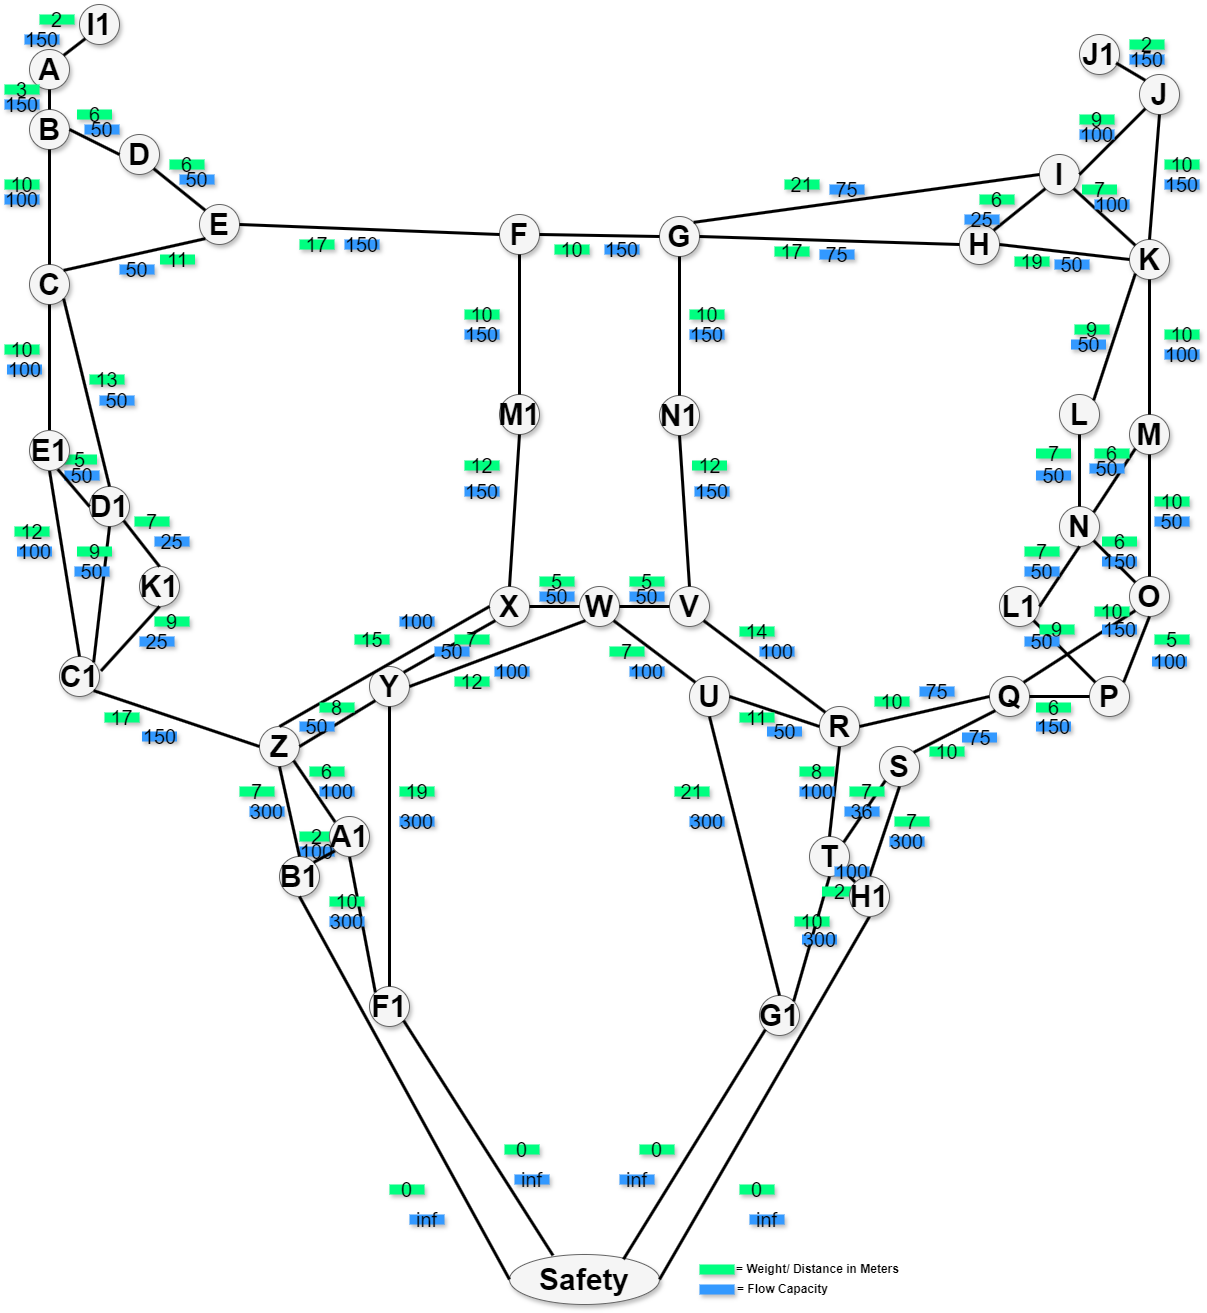

In [14]:
"""
The code is re-used, simply the starting and ending points are changed to visualise
how DFS finds paths, by exploring one direction deeply, before exploring another direction
from the starting point.
"""
class Graph:
    def __init__(self, size):
        self.adj_matrix = [[0] * size for _ in range(size)]
        self.size = size
        self.vertex_data = [''] * size

    def add_edge(self, u, v, c):
        self.adj_matrix[u][v] = c

    def add_vertex_data(self, vertex, data):
        if 0 <= vertex < self.size:
            self.vertex_data[vertex] = data

    def bfs(self, s, t, parent):
        visited = [False] * self.size
        queue = [] 
        queue.append(s)
        visited[s] = True

        while queue:
            u = queue.pop(0) 

            for ind, val in enumerate(self.adj_matrix[u]):
                if not visited[ind] and val > 0:
                    queue.append(ind)
                    visited[ind] = True
                    parent[ind] = u

        return visited[t]
    
    def dfs(self, s, t, visited=None, path=None):
        if visited is None:
            visited = [False] * self.size
        if path is None:
            path = []

        visited[s] = True
        path.append(s)

        if s == t:
            return path

        for ind, val in enumerate(self.adj_matrix[s]):
            if not visited[ind] and val > 0:
                result_path = self.dfs(ind, t, visited, path.copy())
                if result_path:
                    return result_path

        return None
    
    def edmonds_karp(self, source, sink, printed=True):
        parent = [-1] * self.size
        max_flow = 0

        while self.bfs(source, sink, parent):
            path_flow = float("Inf")
            s = sink
            while(s != source):
                path_flow = min(path_flow, self.adj_matrix[parent[s]][s])
                s = parent[s]

            max_flow += path_flow
            v = sink
            while(v != source):
                u = parent[v]
                self.adj_matrix[u][v] -= path_flow
                self.adj_matrix[v][u] += path_flow
                v = parent[v]

            path = []
            v = sink
            while(v != source):
                path.append(v)
                v = parent[v]
            path.append(source)
            path.reverse()
            path_names = [self.vertex_data[node] for node in path]
            if printed == True:
                print("Path:", ", ".join(path_names), ", Flow:", path_flow)

        return max_flow
    
    def ford_fulkerson(self, source, sink, printed=True):
        max_flow = 0

        path = self.dfs(source, sink)
        while path:
            path_flow = float("Inf")
            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                path_flow = min(path_flow, self.adj_matrix[u][v])

            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                self.adj_matrix[u][v] -= path_flow
                self.adj_matrix[v][u] += path_flow

            max_flow += path_flow

            path_names = [self.vertex_data[node] for node in path]
            if printed == True:
                print("Path:", ", ".join(path_names), ", Flow:", path_flow)

            path = self.dfs(source, sink)

        return max_flow


vertex_names = ["A", "B", "C", "D", "E", "F", "G", 
                "H", "I", "J", "K", "L", "M", "N", 
                "O", "P", "Q", "R", "S", "T", "U", 
                "V", "W", "X", "Y", "Z", "A1", "B1", 
                "C1", "D1", "E1", "F1", "G1", "H1", "I1",
                "J1", "K1", "L1", "M1", "N1", "Safety", "Source",  
                "O1", "P1", "Q1", "R1", "S1", "T1", "U1", 
                "V1", "W1", "X1", "Y1", "Z1", "A2", "B2", 
                "C2", "D2", "E2", "F2", "G2", "H2", "I2", 
                "J2", "K2", "L2", "M2", "N2", "O2", "P2", 
                "Q2", "R2", "S2", "T2", "U2", "V2", "W2", 
                "X2", "Y2", "Z2", "A3", "B3", "C3", "D3", 
                "E3", "F3", "G3", "H3", "I3", "J3", "L3", 
                "M3", "N3", "O3", "P3", "Q3", "R3", "S3", 
                "T3", "U3", "V3", "W3", "X3", "Y3", "Z3", 
                "A4", "B4", "C4", "D4", "E4", "F4", "K3"
]


g = Graph(len(vertex_names))

for i, name in enumerate(vertex_names):
    g.add_vertex_data(i, name)
    
def dfs_test(aug, printed=True):
    """Only the edges of the First floor, without the common Safety and Source nodes have been added to the graphical
       representation for this simulation.
       """
    edges_add = [(0, 1, 150), (1, 0, 150), (1, 2, 100), (2, 1, 100), 
                 (1, 3, 50), (3, 1, 50), (2, 4, 50), (4, 2, 50), 
                 (3, 4, 50), (4, 3, 50), (4, 5, 150), (5, 4, 150),    
                 (5, 6, 150), (6, 5, 150), (6, 7, 75), (7, 6, 75),   
                 (6, 8, 75), (8, 6, 75), (7, 8, 25), (8, 7, 25),    
                 (7, 10, 50), (10, 7, 50), (8, 9, 100), (9, 8, 100),   
                 (8, 10, 100), (10, 8, 100), (9, 10, 150), (10, 9, 150),
                 (10, 11, 50), (11, 10, 50), (10, 12, 100), (12, 10, 100), 
                 (11, 13, 50), (13, 11, 50), (12, 13, 50), (13, 12, 50),     
                 (12, 14, 50), (14, 12, 50), (13, 14, 150), (14, 13, 150),     
                 (13, 15, 50), (15, 13, 50), (14, 15, 100), (15, 14, 100), 
                 (14, 16, 150), (16, 14, 150), (15, 16, 150), (16, 15, 150),   
                 (16, 17, 75), (17, 16, 75), (16, 18, 75), (18, 16, 75),    
                 (18, 19, 36), (19, 18, 36), (18, 33, 300), (33, 18, 300),     
                 (19, 33, 100), (33, 19, 100), (19, 32, 300), (32, 19, 300),    
                 (17, 19, 100), (19, 17, 100), (17, 33, 300), (33, 17, 300),     
                 (17, 20, 50), (20, 17, 50), (17, 21, 100), (21, 17, 100),   
                 (20, 21, 50), (21, 20, 50), (20, 22, 100), (22, 20, 100),    
                 (21, 22, 50), (22, 21, 50), (22, 23, 50), (23, 22, 50),     
                 (22, 24, 100), (24, 22, 100), (23, 24, 50), (24, 23, 50), 
                 (23, 25, 100), (25, 23, 100), (24, 25, 50), (25, 24, 50),     
                 (25, 26, 100), (26, 25, 100), (25, 27, 300), (27, 25, 300),   
                 (26, 27, 100), (27, 26, 100), (26, 31, 300), (31, 26, 300),    
                 (25, 28, 150), (28, 25, 150), (28, 29, 50), (29, 28, 50),    
                 (28, 30, 100), (30, 28, 100), (30, 29, 50), (29, 30, 50),    
                 (30, 2, 100), (2, 30, 100), (29, 2, 50), (2, 29, 50),    
                 (0, 34, 150), (34, 0, 150), (5, 38, 150), (38, 5, 150),    
                 (38, 23, 150), (23, 38, 150), (6, 39, 150), (39, 6, 150),    
                 (39, 21, 150), (21, 39, 150), (9, 35, 150), (35, 9, 150),     
                 (13, 37, 50),  (37, 13, 50), (37, 15, 50), (15, 37, 50),     
                 (20, 32, 300), (32, 20, 300), (24, 31, 300), (31, 24, 300),   
                 (28, 36, 25), (36, 28, 25), (36, 29, 25), (29, 36, 25)
                ]
    for u, v, c in edges_add:
        g.add_edge(u, v, c)
        
    source = 5 # Vertex index for "F"
    sink = 24  # Vertex index for "Y"
   
    if aug == Graph.bfs:
        x = g.edmonds_karp(source, sink, printed)
        if printed == True:
            print("The maximum possible flow is %d " % x)
            
    if aug == Graph.dfs:
        y = g.ford_fulkerson(source, sink, printed)
        if printed == True:
            print("The maximum possible flow is %d " % y)

bfs = dfs_test(Graph.bfs)
dfs = dfs_test(Graph.dfs)

Path: F, M1, X, Y , Flow: 50
Path: F, M1, X, W, Y , Flow: 50
Path: F, M1, X, Z, Y , Flow: 50
Path: F, G, N1, V, W, Y , Flow: 50
Path: F, E, C, D1, C1, Z, A1, F1, Y , Flow: 50
Path: F, E, D, B, C, E1, C1, Z, A1, F1, Y , Flow: 50
Path: F, G, N1, V, U, W, X, Z, B1, A1, F1, Y , Flow: 50
The maximum possible flow is 350 
Path: F, E, C, D1, C1, Z, X, W, Y , Flow: 50
Path: F, E, D, B, C, E1, C1, Z, X, Y , Flow: 50
Path: F, G, H, I, J, K, L, N, M, O, P, Q, R, T, G1, U, V, W, X, Z, Y , Flow: 25
Path: F, G, H, K, L, N, M, O, P, Q, R, T, G1, U, V, W, X, Z, Y , Flow: 25
Path: F, G, H, K, M, N, O, P, Q, R, T, G1, U, W, X, Z, A1, F1, Y , Flow: 25
Path: F, G, I, J, K, M, N, O, P, Q, S, T, R, U, W, X, Z, A1, F1, Y , Flow: 25
Path: F, G, I, J, K, M, N, O, Q, S, T, R, U, W, Y , Flow: 11
Path: F, G, I, J, K, M, N, O, Q, S, H1, R, T, G1, U, W, Y , Flow: 39
Path: F, M1, X, Z, A1, F1, Y , Flow: 50
Path: F, M1, X, Z, B1, A1, F1, Y , Flow: 50
The maximum possible flow is 350 


## Global Solutions on Mall Floorplan
Floorplan Source: https://jhmrad.com/map-of-a-house-to-build-inspiration/robert-heine-pharmacy-building-rhph-map/#main 

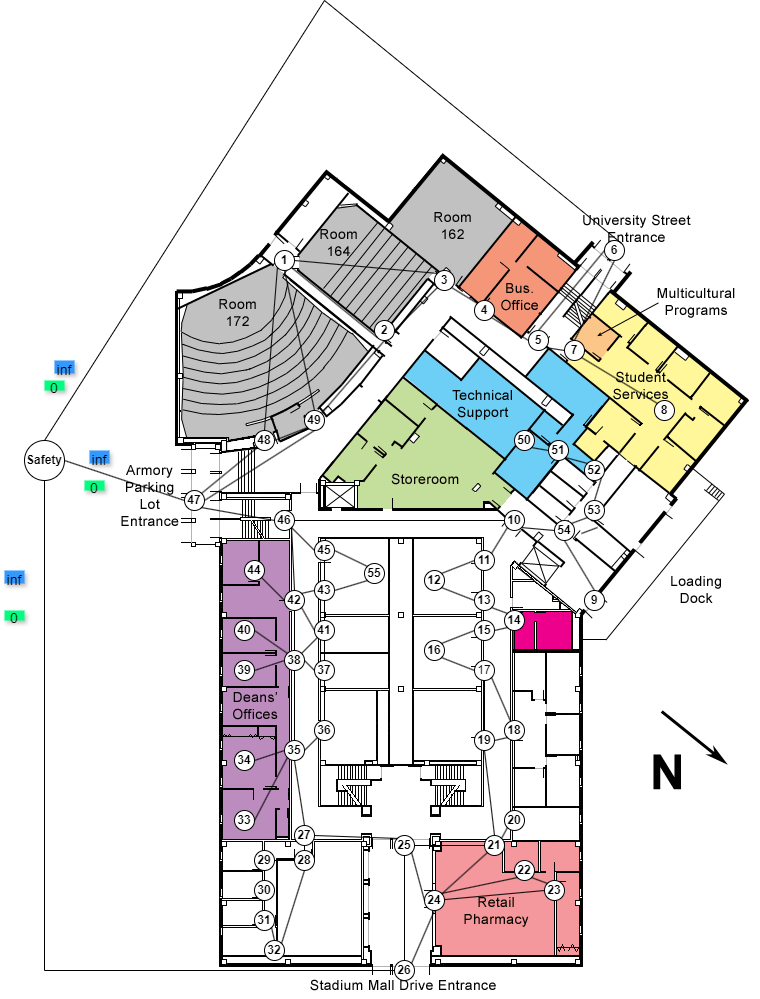

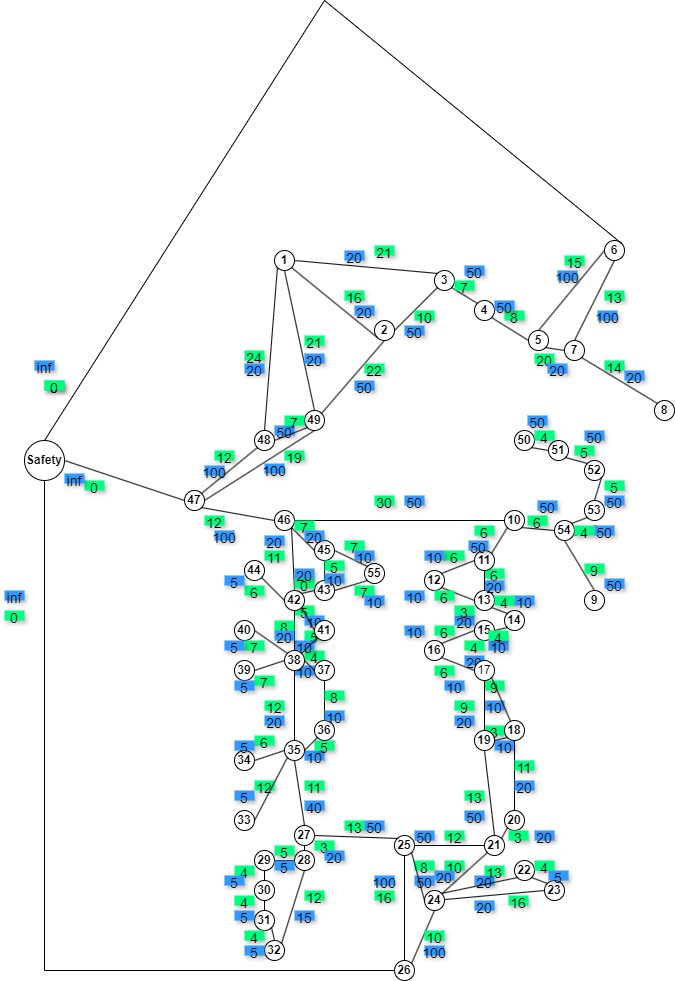

In [15]:
"""
All of the code snippets were taken from the previous implementations, applied to a different floorplan, which had to be 
turned into another graphical representation.
This cell includes the run with A* and Dijkstra as augmenting path finding methods.
"""
class Graph:
    def __init__(self, graph, vertices, edges):
        self.vertices = vertices
        self.edges = edges
        self.vertex_index = {self.vertices[i]: i for i in range(len(vertices))}
        self.index_vertex = {i: self.vertices[i] for i in range(len(vertices))}
        self.capacity = {v: {} for v in vertices}
        self.weights = {v: {} for v in vertices}
        self.ROW = len(graph)

        for edge in edges:
            self.capacity[edge.v1][edge.v2] = edge.capacity
            self.weights[edge.v1][edge.v2] = edge.weight
    
def heuristic(e):
    if e.status == "blocked":
        return e.real_weight*100
    if e.status == "safe":
        return e.real_weight
    else:
        return e.real_weight


def astar(source, sink, graph):

    source_index = graph.vertex_index[source]

    dist = [float('inf')] * graph.ROW
    prev = [None] * graph.ROW
    dist[source_index] = 0              # distance from source to itself is 0

    pq = [(0, source_index)]            # priority queue
    visited = []

    while pq:
        current_dist, u_idx = heapq.heappop(pq)
        if u_idx in visited:
            continue
        visited.append(u_idx)

        u = graph.index_vertex[u_idx]
        for v, capacity in graph.capacity[u].items():
            v_idx = graph.vertex_index[v]
            edge = next((e for e in graph.edges if e.v1 == u and e.v2 == v), None)
            if edge:
                weight = heuristic(edge)
            else:
                weight = float('inf')

            if dist[u_idx] + weight < dist[v_idx] and capacity > 0:
                dist[v_idx] = dist[u_idx] + weight
                prev[v_idx] = u_idx
                heapq.heappush(pq, (dist[v_idx], v_idx))

    return dist, prev

def dijkstra(source, sink, graph):

    source_index = graph.vertex_index[source]

    dist = [float('inf')] * graph.ROW
    prev = [None] * graph.ROW
    dist[source_index] = 0

    pq = [(0, source_index)]
    visited = []

    while pq:
        current_dist, u_idx = heapq.heappop(pq)
        if u_idx in visited:
            continue
        visited.append(u_idx)

        u = graph.index_vertex[u_idx]
        for v, capacity in graph.capacity[u].items():
            v_idx = graph.vertex_index[v]
            weight = graph.weights[u].get(v, float('inf')) # as explained, no heuristic function involved

            if dist[u_idx] + weight < dist[v_idx] and capacity > 0:
                dist[v_idx] = dist[u_idx] + weight
                prev[v_idx] = u_idx
                heapq.heappush(pq, (dist[v_idx], v_idx))

    return dist, prev

def FordFulkerson(graph, source, sink, aug_method, printed=True):
    max_flow = 0
    while True:
        dist, prev = aug_method(source, sink, graph)
        
        path = []
        v = graph.vertex_index[sink]
        while v is not None:
            path.append(graph.index_vertex[v])
            v = prev[v]
        path.reverse()
        path_names = [node for node in path]

        if not path or path[-1] != sink:
            break

        path_flow = float('Inf')
        path_dist = 0
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            path_flow = min(path_flow, graph.capacity[u][v])
            path_dist += graph.weights[u][v]
            
        if path[0] != sink and printed == True:
            print(path_names, path_flow, path_dist)
        else:
            break
            
        if path_flow == 0: # no capacity remains
            break 

        max_flow += path_flow

        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            graph.capacity[u][v] -= path_flow
            graph.capacity[v][u] = graph.capacity.get(v, {}).get(u, 0) + path_flow

    return max_flow

"""This time the points in the graph are simply numbered."""
V1 = Vertex("1")
V2 = Vertex("2")
V3 = Vertex("3")
V4 = Vertex("4")
V5 = Vertex("5")
V6 = Vertex("6")
V7 = Vertex("7")
V8 = Vertex("8")
V9 = Vertex("9")
V10 = Vertex("10")
V11 = Vertex("11")
V12 = Vertex("12")
V13 = Vertex("13")
V14 = Vertex("14")
V15 = Vertex("15")
V16 = Vertex("16")
V17 = Vertex("17")
V18 = Vertex("18")
V19 = Vertex("19")
V20 = Vertex("20")
V21 = Vertex("21")
V22 = Vertex("22")
V23 = Vertex("23")
V24 = Vertex("24")
V25 = Vertex("25")
V26 = Vertex("26")
V27 = Vertex("27")
V28 = Vertex("28")
V29 = Vertex("29")
V30 = Vertex("30")
V31 = Vertex("31")
V32 = Vertex("32")
V33 = Vertex("33")
V34 = Vertex("34")
V35 = Vertex("35")
V36 = Vertex("36")
V37 = Vertex("37")
V38 = Vertex("38")
V39 = Vertex("39")
V40 = Vertex("40")
V41 = Vertex("41")
V42 = Vertex("42")
V43 = Vertex("43")
V44 = Vertex("44")
V45 = Vertex("45")
V46 = Vertex("46")
V47 = Vertex("47")
V48 = Vertex("48")
V49 = Vertex("49")
V50 = Vertex("50")
V51 = Vertex("51")
V52 = Vertex("52")
V53 = Vertex("53")
V54 = Vertex("54")
V55 = Vertex("55")
Safety = Vertex("Safety")
Source = Vertex("Source")

vertices = [V1, V2, V3, V4, V5, V6,
            V7, V8, V9, V10, V11, V12,
            V13, V14, V15, V16, V17, V18,
            V19, V20, V21, V22, V23, V24,
            V25, V26, V27, V28, V29, V30,
            V31, V32, V33, V34, V35, V36,
            V37, V38, V39, V40, V41, V42,
            V43, V44, V45, V46, V47, V48,
            V49, V50, V51, V52, V53, V54,
            V55, Safety, Source
]


edges = [
    Edge(V1, V48, 24, 20), Edge(V48, V1, 24, 20), Edge(V1, V49, 21, 20), Edge(V49, V1, 21, 20),
    Edge(V1, V2, 16, 20), Edge(V2, V1, 16, 20), Edge(V1, V3, 21, 20), Edge(V3, V1, 21, 20),
    Edge(V2, V49, 22, 50), Edge(V49, V2, 22, 50), Edge(V49, V48, 7, 50), Edge(V48, V49, 7, 50),
    Edge(V49, V47, 19, 100), Edge(V47, V49, 19, 100), Edge(V48, V47, 12, 100), Edge(V47, V48, 12, 100),
    Edge(V2, V3, 10, 50),  Edge(V3, V2, 10, 50),  Edge(V3, V4, 7, 50), Edge(V4, V3, 7, 50),
    Edge(V4, V5, 8, 50), Edge(V5, V4, 8, 50), Edge(V5, V6, 15, 100), Edge(V6, V5, 15, 100),
    Edge(V5, V7, 5, 20), Edge(V7, V5, 5, 20),  Edge(V7, V8, 14, 20), Edge(V8, V7, 14, 20),
    Edge(V7, V6, 13, 100), Edge(V6, V7, 13, 100), Edge(V47, V46, 12, 100), Edge(V46, V47, 12, 100), 
    Edge(V46, V10, 30, 50), Edge(V10, V46, 30, 50), Edge(V10, V54, 6, 50), Edge(V54, V10, 6, 50),
    Edge(V54, V9, 9, 50), Edge(V9, V54, 9, 50), Edge(V54, V53, 4, 50), Edge(V53, V54, 4, 50), 
    Edge(V53, V52, 5, 50), Edge(V52, V53, 5, 50), Edge(V52, V51, 5, 50), Edge(V51, V52, 5, 50),
    Edge(V51, V50, 4, 50), Edge(V50, V51, 4, 50), Edge(V10, V11, 6, 50), Edge(V11, V10, 6, 50), 
    Edge(V11, V12, 6, 10), Edge(V12, V11, 6, 10), Edge(V11, V13, 6, 20), Edge(V13, V11, 6, 20),
    Edge(V12, V13, 6, 10), Edge(V13, V12, 6, 10), Edge(V13, V14, 4, 10), Edge(V14, V13, 4, 10), 
    Edge(V13, V15, 3, 20), Edge(V15, V13, 3, 20), Edge(V14, V15, 4, 10), Edge(V15, V14, 4, 10),
    Edge(V15, V16, 6, 10), Edge(V16, V15, 6, 10), Edge(V15, V17, 4, 20), Edge(V17, V15, 4, 20), 
    Edge(V16, V17, 6, 10), Edge(V17, V16, 6, 10), Edge(V17, V18, 9, 10), Edge(V18, V17, 9, 10),
    Edge(V17, V19, 9, 20), Edge(V19, V17, 9, 20), Edge(V18, V19, 3, 10), Edge(V19, V18, 3, 10), 
    Edge(V18, V20, 11, 20), Edge(V20, V18, 11, 20), Edge(V20, V21, 3, 20), Edge(V21, V20, 3, 20),
    Edge(V19, V21, 13, 50), Edge(V21, V19, 13, 50), Edge(V21, V24, 10, 20, "blocked"), Edge(V24, V21, 10, 20, "blocked"), 
    Edge(V21, V25, 12, 50), Edge(V25, V21, 12, 50), Edge(V22, V24, 13, 20), Edge(V24, V22, 13, 20),
    Edge(V22, V23, 4, 5), Edge(V23, V22, 4, 5), Edge(V23, V24, 16, 20), Edge(V24, V23, 16, 20), 
    Edge(V25, V24, 8, 50), Edge(V24, V25, 8, 50), Edge(V24, V26, 10, 100), Edge(V26, V24, 10, 100),
    Edge(V25, V26, 16, 100), Edge(V26, V25, 16, 100), Edge(V25, V27, 13, 50), Edge(V27, V25, 13, 50), 
    Edge(V27, V28, 3, 20), Edge(V28, V27, 3, 20), Edge(V28, V29, 5, 5), Edge(V29, V28, 5, 5),
    Edge(V29, V30, 4, 5), Edge(V30, V29, 4, 5), Edge(V30, V31, 4, 5), Edge(V31, V30, 4, 5), 
    Edge(V31, V32, 4, 5), Edge(V32, V31, 4, 5), Edge(V32, V28, 12, 15), Edge(V28, V32, 12, 15),
    Edge(V27, V35, 11, 40), Edge(V35, V27, 11, 40), Edge(V33, V35, 12, 5), Edge(V35, V33, 12, 5), 
    Edge(V34, V35, 6, 5), Edge(V35, V34, 6, 5), Edge(V35, V36, 5, 10), Edge(V36, V35, 5, 10),
    Edge(V35, V38, 12, 20), Edge(V38, V35, 12, 20), Edge(V36, V37, 8, 10), Edge(V37, V36, 8, 10), 
    Edge(V37, V38, 4, 10), Edge(V38, V37, 4, 10), Edge(V39, V38, 7, 5), Edge(V38, V39, 7, 5),
    Edge(V40, V38, 7, 5), Edge(V38, V40, 7, 5), Edge(V38, V41, 5, 10), Edge(V41, V38, 5, 10), 
    Edge(V38, V42, 8, 20), Edge(V42, V38, 8, 20), Edge(V42, V43, 3, 20), Edge(V43, V42, 3, 20),
    Edge(V42, V44, 6, 5), Edge(V44, V42, 6, 5), Edge(V43, V55, 7, 10), Edge(V55, V43, 7, 10), 
    Edge(V55, V45, 7, 10), Edge(V45, V55, 7, 10), Edge(V43, V45, 5, 10), Edge(V45, V43, 5, 10),
    Edge(V42, V46, 11, 20), Edge(V46, V42, 11, 20), Edge(V45, V46, 7, 20), Edge(V46, V45, 7, 20), 
    Edge(V42, V41, 5, 10), Edge(V41, V42, 5, 10) 
]

"""There are 3 exit points in this floorplan."""
safety_edges = [(Edge(Safety,V47,0, sys.maxsize)), (Edge(V47,Safety,0, sys.maxsize)),
                (Edge(Safety,V26,0, sys.maxsize)), (Edge(V26,Safety,0, sys.maxsize)),
                (Edge(Safety,V6,0, sys.maxsize)), (Edge(V6,Safety,0, sys.maxsize))
]

for safe_edge in safety_edges:
    edges.append(safe_edge)
    
"""
The expected population is fed into the respective points through their connection to the common source node.
The distribution is as follows:
50 evacuees are expected at point 1 which is between rooms 172 and 164, to simulate the population shared between those 2 rooms.
The expected number of evacuees at each of the points 44, 40 and 39 are 1 respectively, 4 at point 34 and 3 at 33, all 
representing the deans' offices. One evacuee is expected at each of the points 29, 30, 31, 2 are expected at 32 and 5 at 28. 
10 evacuees are fed into the points 55, 12, 16, 19 and 5 evacuees at each of the points 41, 37 and 36. 1 evacuee is fed into
each of the points 22 and 23 at the retail pharmacy and 3 into point 21. 20 evacuees are expected in the technical support room
represented by point 50 and 15 are expected at student services (point 8). Finally, 5 evacuees are expected to be located at the 
bus office. The total expected number of evacuees is 170, and this number should be the maximum flow of the network.
"""
source_edges = [(Edge(Source,V1,0, 50)), (Edge(V1,Source,0, 50)),
                (Edge(Source,V44,0, 1)), (Edge(V44,Source,0, 1)),
                (Edge(Source,V40,0, 1)), (Edge(V40,Source,0, 1)),
                (Edge(Source,V39,0, 1)), (Edge(V39,Source,0, 1)),
                (Edge(Source,V34,0, 4)), (Edge(V34,Source,0, 4)),
                (Edge(Source,V33,0, 3)), (Edge(V33,Source,0, 3)),
                (Edge(Source,V55,0, 10)), (Edge(V55,Source,0, 10)),
                (Edge(Source,V41,0, 5)), (Edge(V41,Source,0, 5)),
                (Edge(Source,V37,0, 5)), (Edge(V37,Source,0, 5)),
                (Edge(Source,V36,0, 5)), (Edge(V36,Source,0, 5)),
                (Edge(Source,V29,0, 1)), (Edge(V29,Source,0, 1)),
                (Edge(Source,V30,0, 1)), (Edge(V30,Source,0, 1)),
                (Edge(Source,V31,0, 1)), (Edge(V31,Source,0, 1)),
                (Edge(Source,V32,0, 2)), (Edge(V32,Source,0, 2)),
                (Edge(Source,V28,0, 5)), (Edge(V28,Source,0, 5)),
                (Edge(Source,V23,0, 1)), (Edge(V23,Source,0, 1)),
                (Edge(Source,V22,0, 1)), (Edge(V22,Source,0, 1)),
                (Edge(Source,V21,0, 3)), (Edge(V21,Source,0, 3)),
                (Edge(Source,V19,0, 10)), (Edge(V19,Source,0, 10)),
                (Edge(Source,V16,0, 10)), (Edge(V16,Source,0, 10)),
                (Edge(Source,V12,0, 10)), (Edge(V12,Source,0, 10)),
                (Edge(Source,V50,0, 20)), (Edge(V50,Source,0, 20)),
                (Edge(Source,V8,0, 15)), (Edge(V8,Source,0, 15)),
                (Edge(Source,V4,0, 5)), (Edge(V4,Source,0, 5))
]
               

for source_edge in source_edges:
    edges.append(source_edge)

def test(source, sink, aug):
        matrix = [[0] * len(vertices) for _ in range(len(vertices))]
        g = Graph(matrix, vertices, edges)
        print(f"The maximum possible flow from {source} to {sink} is {FordFulkerson(g, source, sink, aug)}")


test(Source, Safety, dijkstra)
test(Source, Safety, astar)


[Source, 21, 24, 26, Safety] 3 20
[Source, 4, 5, 6, Safety] 5 23
[Source, 22, 24, 26, Safety] 1 23
[Source, 23, 24, 26, Safety] 1 26
[Source, 55, 45, 46, 47, Safety] 10 26
[Source, 8, 7, 6, Safety] 15 27
[Source, 41, 42, 46, 47, Safety] 5 28
[Source, 44, 42, 46, 47, Safety] 1 29
[Source, 28, 27, 25, 26, Safety] 5 32
[Source, 19, 21, 24, 26, Safety] 10 33
[Source, 37, 38, 42, 46, 47, Safety] 5 35
[Source, 1, 48, 47, Safety] 20 36
[Source, 29, 28, 27, 25, 26, Safety] 1 37
[Source, 39, 38, 42, 46, 47, Safety] 1 38
[Source, 40, 38, 42, 46, 47, Safety] 1 38
[Source, 1, 49, 47, Safety] 20 40
[Source, 30, 29, 28, 27, 25, 26, Safety] 1 41
[Source, 36, 37, 38, 42, 46, 47, Safety] 5 43
[Source, 32, 28, 27, 25, 26, Safety] 2 44
[Source, 31, 30, 29, 28, 27, 25, 26, Safety] 1 45
[Source, 34, 35, 27, 25, 26, Safety] 4 46
[Source, 16, 17, 19, 21, 24, 26, Safety] 7 48
[Source, 1, 3, 4, 5, 6, Safety] 10 51
[Source, 33, 35, 27, 25, 26, Safety] 3 52
[Source, 12, 11, 10, 46, 47, Safety] 10 54
[Source, 16,

In [16]:
"""
This cell includes the runthrough with BFS and DFS as the augmenting path finding methods,
applied to the graphical representation of the mall.
"""
class Graph:
    def __init__(self, size):
        self.adj_matrix = [[0] * size for _ in range(size)]
        self.size = size
        self.vertex_data = [''] * size

    def add_edge(self, u, v, c):
        self.adj_matrix[u][v] = c

    def add_vertex_data(self, vertex, data):
        if 0 <= vertex < self.size:
            self.vertex_data[vertex] = data

    def bfs(self, s, t, parent):
        visited = [False] * self.size
        queue = [] 
        queue.append(s)
        visited[s] = True

        while queue:
            u = queue.pop(0) 

            for ind, val in enumerate(self.adj_matrix[u]):
                if not visited[ind] and val > 0:
                    queue.append(ind)
                    visited[ind] = True
                    parent[ind] = u

        return visited[t]
    
    def dfs(self, s, t, visited=None, path=None):
        if visited is None:
            visited = [False] * self.size
        if path is None:
            path = []

        visited[s] = True
        path.append(s)

        if s == t:
            return path

        for ind, val in enumerate(self.adj_matrix[s]):
            if not visited[ind] and val > 0:
                result_path = self.dfs(ind, t, visited, path.copy())
                if result_path:
                    return result_path

        return None
    
    def edmonds_karp(self, source, sink, printed=True):
        parent = [-1] * self.size
        max_flow = 0

        while self.bfs(source, sink, parent):
            path_flow = float("Inf")
            s = sink
            while(s != source):
                path_flow = min(path_flow, self.adj_matrix[parent[s]][s])
                s = parent[s]

            max_flow += path_flow
            v = sink
            while(v != source):
                u = parent[v]
                self.adj_matrix[u][v] -= path_flow
                self.adj_matrix[v][u] += path_flow
                v = parent[v]

            path = []
            v = sink
            while(v != source):
                path.append(v)
                v = parent[v]
            path.append(source)
            path.reverse()
            path_names = [self.vertex_data[node] for node in path]
            if printed == True:
                print("Path:", ", ".join(path_names), ", Flow:", path_flow)

        return max_flow
    
    def ford_fulkerson(self, source, sink, printed=True):
        max_flow = 0

        path = self.dfs(source, sink)
        while path:
            path_flow = float("Inf")
            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                path_flow = min(path_flow, self.adj_matrix[u][v])

            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                self.adj_matrix[u][v] -= path_flow
                self.adj_matrix[v][u] += path_flow

            max_flow += path_flow

            path_names = [self.vertex_data[node] for node in path]
            if printed == True:
                print("Path:", ", ".join(path_names), ", Flow:", path_flow)

            path = self.dfs(source, sink)

        return max_flow


vertex_names = ["1", "2", "3", "4", "5", "6", "7", 
                "8", "9", "10", "11", "12", "13", "14", 
                "15", "16", "17", "18", "19", "20", "21", 
                "22", "23", "24", "25", "26", "27", "28", 
                "29", "30", "31", "32", "33", "34", "35",
                "36", "37", "38", "39", "40", "41", "42",  
                "43", "44", "45", "46", "47", "48", "49", 
                "50", "51", "52", "53", "54", "55", "Safety", 
                "Source"
]

g = Graph(len(vertex_names))

for i, name in enumerate(vertex_names):
    g.add_vertex_data(i, name)
    
def ford_fulkerson_bfs_dfs(aug, printed=True):
    edges_add = [(0, 47, 20), (47, 0, 20), (0, 48, 20), (48, 0, 20),
                (0, 1, 20), (1, 0, 20), (0, 2, 20), (2, 0, 20),
                (1, 48, 50), (48, 1, 50), (48, 47, 50), (47, 48, 50),
                (48, 46, 100), (46, 48, 100), (47, 46, 100), (46, 47, 100),
                (1, 2, 50),  (2, 1, 50),  (2, 3, 50), (3, 2, 50),
                (3, 4, 50), (4, 3, 50), (4, 5, 100), (5, 4, 100),
                (4, 6, 20), (6, 4, 20),  (6, 7, 20), (7, 6, 20),
                (6, 5, 100), (5, 6, 100), (46, 45, 100), (45, 46, 100), 
                (45, 9, 50), (9, 45, 50), (9, 53, 50), (53, 9, 50),
                (53, 8, 50), (8, 53, 50), (53, 52, 50), (52, 53, 50), 
                (52, 51, 50), (51, 52, 50), (51, 50, 50), (50, 51, 50),
                (50, 49, 50), (49, 50, 50), (9, 10, 50), (10, 9, 50), 
                (10, 11, 10), (11, 10, 10), (10, 12, 20), (12, 10, 20),
                (11, 12, 10), (12, 11, 10), (12, 13, 10), (13, 12, 10), 
                (12, 14, 20), (14, 12, 20), (13, 14, 10), (14, 13, 10),
                (14, 15, 10), (15, 14, 10), (14, 16, 20), (16, 14, 20), 
                (15, 16, 10), (16, 15, 10), (16, 17, 10), (17, 16, 10),
                (16, 18, 20), (18, 16, 20), (17, 18, 10), (18, 17, 10), 
                (17, 19, 20), (19, 17, 20), (19, 20, 20), (20, 19, 20),
                (18, 20, 50), (20, 18, 50), (20, 23, 20), (23, 20, 20), 
                (20, 24, 50), (24, 20, 50), (21, 23, 20), (23, 21, 20),
                (21, 22, 5), (22, 21, 5), (22, 23, 20), (23, 22, 20), 
                (24, 23, 50), (23, 24, 50), (23, 25, 100), (25, 23, 100),
                (24, 25, 100), (25, 24, 100), (24, 26, 50), (26, 24, 50), 
                (26, 27, 20), (27, 26, 20), (27, 28, 5), (28, 27, 5),
                (28, 29, 5), (29, 28, 5), (29, 30, 5), (30, 29, 5), 
                (30, 31, 5), (31, 30, 5), (31, 27, 15), (27, 31, 15),
                (26, 34, 40), (34, 26, 40), (32, 34, 5), (34, 32, 5), 
                (33, 34, 5), (34, 33, 5), (34, 35, 10), (35, 34, 10),
                (34, 37, 20), (37, 34, 20), (35, 36, 10), (36, 35, 10), 
                (36, 37, 10), (37, 36, 10), (38, 37, 5), (37, 38, 5),
                (39, 37, 5), (37, 39, 5), (37, 40, 10), (40, 37, 10), 
                (37, 41, 20), (42, 37, 20), (41, 42, 20), (42, 41, 20),
                (41, 43, 5), (43, 41, 5), (42, 54, 10), (54, 42, 10), 
                (54, 44, 10), (44, 54, 10), (42, 44, 10), (44, 42, 10),
                (41, 45, 20), (45, 41, 20), (44, 45, 20), (45, 44, 20), 
                (41, 40, 10), (40, 41, 10),
                 
                 (56,0, 50), (0,56, 50), (56,43, 1), (43,56, 1),
                 (56,39, 1), (39,56, 1), (56,38, 1), (38,56, 1),
                 (56,33, 4), (33,56, 4), (56,32, 3), (32,56, 3),
                 (56,54, 10), (54,56, 10), (56,40, 5), (40,56, 5),
                 (56,36, 5), (36,56, 5), (56,35, 5), (35,56, 5),
                 (56,28, 1), (28,56, 1), (56,29, 1), (29,56, 1),
                 (56,30, 1), (30,56, 1), (56,31, 2), (31,56, 2),
                 (56,27, 5), (27,56, 5), (56,22, 1), (22,56, 1),
                 (56,21, 1), (21,56, 1), (56,20, 3), (20,56, 3),
                 (56,18, 10), (18,56, 10), (56,15, 10), (15,56, 10),
                 (56,11, 10), (11,56, 10), (56,49, 20), (49,56, 20),
                 (56,7, 15), (7,56, 15), (56,3, 5), (3,56, 5),
                 
                 (55, 46, sys.maxsize), (46, 55, sys.maxsize), (55, 25, sys.maxsize), (25, 55, sys.maxsize),
                 (55, 5, sys.maxsize), (5, 55, sys.maxsize)
              
                ]
    
    for u, v, c in edges_add:
        g.add_edge(u, v, c)
        
    source = 56 
    sink = 5
   
    if aug == Graph.bfs:
        x = g.edmonds_karp(source, sink, printed)
        if printed == True:
            print("The maximum possible flow is %d " % x)
            
    if aug == Graph.dfs:
        y = g.ford_fulkerson(source, sink, printed)
        if printed == True:
            print("The maximum possible flow is %d " % y)

bfs = ford_fulkerson_bfs_dfs(Graph.bfs)
dfs = ford_fulkerson_bfs_dfs(Graph.dfs)


Path: Source, 4, 5, 6 , Flow: 5
Path: Source, 8, 7, 6 , Flow: 15
Path: Source, 1, 3, 4, 5, 6 , Flow: 20
Path: Source, 1, 48, 47, Safety, 6 , Flow: 20
Path: Source, 1, 49, 47, Safety, 6 , Flow: 10
Path: Source, 21, 24, 26, Safety, 6 , Flow: 3
Path: Source, 22, 24, 26, Safety, 6 , Flow: 1
Path: Source, 23, 24, 26, Safety, 6 , Flow: 1
Path: Source, 19, 21, 24, 26, Safety, 6 , Flow: 10
Path: Source, 28, 27, 25, 26, Safety, 6 , Flow: 5
Path: Source, 41, 42, 46, 47, Safety, 6 , Flow: 5
Path: Source, 44, 42, 46, 47, Safety, 6 , Flow: 1
Path: Source, 55, 45, 46, 47, Safety, 6 , Flow: 10
Path: Source, 12, 11, 10, 46, 47, Safety, 6 , Flow: 10
Path: Source, 29, 28, 27, 25, 26, Safety, 6 , Flow: 1
Path: Source, 32, 28, 27, 25, 26, Safety, 6 , Flow: 2
Path: Source, 33, 35, 27, 25, 26, Safety, 6 , Flow: 3
Path: Source, 34, 35, 27, 25, 26, Safety, 6 , Flow: 4
Path: Source, 36, 35, 27, 25, 26, Safety, 6 , Flow: 5
Path: Source, 37, 38, 42, 46, 47, Safety, 6 , Flow: 5
Path: Source, 39, 38, 42, 46, 47, S